In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import pickle

from B_data import *
from B_Plotting import Burgers_plot, loss_plot 

# Full PINN
from B_PINN1 import NN1
from B_PINN1_train import pinn1_train
#from B_PINN1_activation import P1
from B_PINN2_ind import NN2
from B_PINN2_train import pinn2_train

# Burgers GPT-PINN
from B_GPT_activation import P

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

# Training Parameter Set
number_of_neurons = 2
nu1_training = np.linspace(1.0, 1.0, number_of_neurons)
nu2_training  = np.linspace(2.0, 2.0, number_of_neurons)

nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

nu_pinn_train = [0.5,1.6]
largest_loss_list = np.ones(number_of_neurons**2)
P_list = np.ones(number_of_neurons**2, dtype=object)
# Domain and Data
Xi, Xf         = -1.0, 1.5
Ti, Tf0         =  0.0, 0.1

Nx_train0, Nt_train0 =  201, 101
Nx_train, Nt_train =  101, 201
Nx_test0, Nt_test0 =1001,11
Nx_test, Nt_test = 101, 201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

# Setting PINN and TGPT-PINN
layers_pinn = np.array([2, 30, 30, 30, 30, 30, 1])

lr_pinn0     = 0.001
epochs_pinn0 = 10000
tol_pinn0    = 5e-4

lr_pinn1     = 0.001
epochs_pinn1 = 20000
tol_pinn1    = 1e-4

lr_pinn2     = 0.0001
epochs_pinn2 = 25000
tol_pinn2   = 1e-4

lr_gpt          = 0.001
epochs_gpt      = 10000
tol_gpt         = 1e-3

pinn_train_times = np.ones(number_of_neurons)

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


******************************************************************
Epoch: 200 | loss: 0.5174270868301392,rMAE: 0.291361004114151, rRMSE:0.2610445022583008,loss_RH:0.00000000,loss_con:2.59582949,loss_R:0.046083834022283554,loss_IC:0.046118658035993576,loss_BC:0.0010156711796298623
Epoch: 400 | loss: 0.29546329379081726,rMAE: 0.2257484644651413, rRMSE:0.20989753305912018,loss_RH:0.00000000,loss_con:2.58091617,loss_R:0.028962234035134315,loss_IC:0.026487354189157486,loss_BC:0.00016275372763630003
Epoch: 600 | loss: 0.19150413572788239,rMAE: 0.18554925918579102, rRMSE:0.18587419390678406,loss_RH:0.00000000,loss_con:2.58307552,loss_R:0.020518409088253975,loss_IC:0.016832595691084862,loss_BC:0.00026597586111165583
Epoch: 800 | loss: 0.1518610119819641,rMAE: 0.15693874657154083, rRMSE:0.16108624637126923,loss_RH:0.00000000,loss_con:2.57019401,loss_R:0.01563876122236252,loss_IC:0.013468190096318722,loss_BC:0.00015403458382934332
Epoch: 1000 | loss: 0.11911701411008835,rMAE: 0.12121357023715973

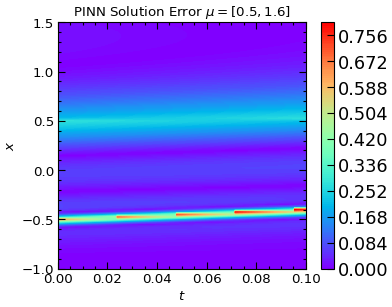

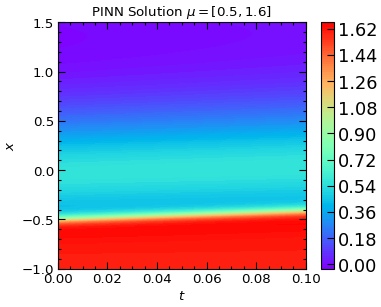

Epoch: 1200 | loss: 0.11277912557125092,rMAE: 0.11544473469257355, rRMSE:0.12150829285383224,loss_RH:0.00000000,loss_con:2.74118137,loss_R:0.00896319281309843,loss_IC:0.008732766844332218,loss_BC:0.0016488268738612533
Epoch: 1400 | loss: 0.07119718939065933,rMAE: 0.08950650691986084, rRMSE:0.10428068786859512,loss_RH:0.00000000,loss_con:2.55922341,loss_R:0.007162099704146385,loss_IC:0.0063960254192352295,loss_BC:7.483024091925472e-06
Epoch: 1600 | loss: 0.0615408830344677,rMAE: 0.08814878761768341, rRMSE:0.09886113554239273,loss_RH:0.00000000,loss_con:2.55535436,loss_R:0.00640880549326539,loss_IC:0.005493820179253817,loss_BC:1.938749846885912e-05
Epoch: 1800 | loss: 0.0559689924120903,rMAE: 0.08529552072286606, rRMSE:0.09577833861112595,loss_RH:0.00000000,loss_con:2.55143785,loss_R:0.0059631625190377235,loss_IC:0.004973996430635452,loss_BC:2.6586656531435438e-05
Epoch: 2000 | loss: 0.05162670835852623,rMAE: 0.08062849938869476, rRMSE:0.0931280106306076,loss_RH:0.00000000,loss_con:2.552

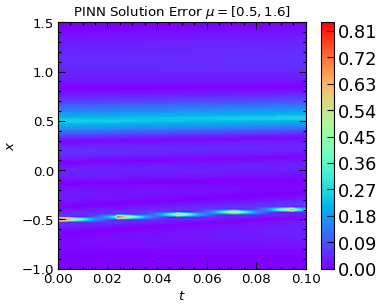

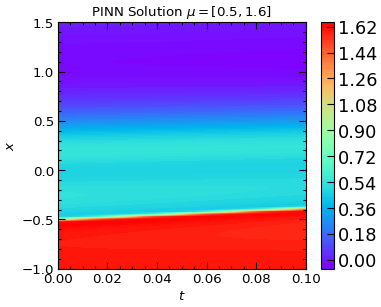

Epoch: 2200 | loss: 0.04799049720168114,rMAE: 0.07564540952444077, rRMSE:0.09067773073911667,loss_RH:0.00000000,loss_con:2.54153371,loss_R:0.005230419337749481,loss_IC:0.004234041087329388,loss_BC:4.196667578071356e-05
Epoch: 2400 | loss: 0.04467012360692024,rMAE: 0.07130835205316544, rRMSE:0.08834061026573181,loss_RH:0.00000000,loss_con:2.55017185,loss_R:0.004940104205161333,loss_IC:0.003945890348404646,loss_BC:2.711171873670537e-05
Epoch: 2600 | loss: 0.04156051576137543,rMAE: 0.06738009303808212, rRMSE:0.08598126471042633,loss_RH:0.00000000,loss_con:2.54827905,loss_R:0.00464714877307415,loss_IC:0.003663030220195651,loss_BC:2.8306045351200737e-05
Epoch: 2800 | loss: 0.03846759721636772,rMAE: 0.06481781601905823, rRMSE:0.08348771929740906,loss_RH:0.00000000,loss_con:2.55099225,loss_R:0.004365288186818361,loss_IC:0.0033865985460579395,loss_BC:2.363250132475514e-05
Epoch: 3000 | loss: 0.03538621962070465,rMAE: 0.06328059732913971, rRMSE:0.08090715855360031,loss_RH:0.00000000,loss_con:2.

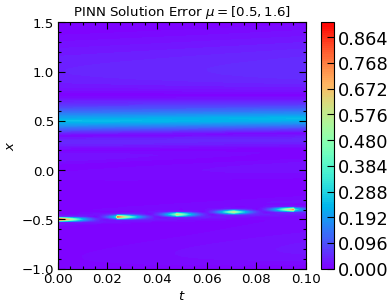

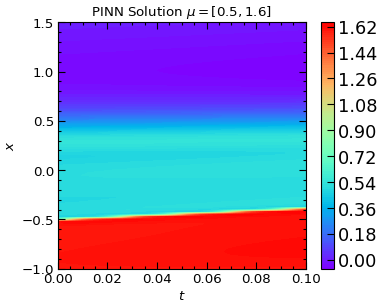

Epoch: 3200 | loss: 0.03224235400557518,rMAE: 0.05931525677442551, rRMSE:0.07822157442569733,loss_RH:0.00000000,loss_con:2.56373596,loss_R:0.0038233904633671045,loss_IC:0.002824821975082159,loss_BC:1.707440969767049e-05
Epoch: 3400 | loss: 0.032186057418584824,rMAE: 0.052089888602495193, rRMSE:0.0749966949224472,loss_RH:0.00000000,loss_con:2.62024617,loss_R:0.003762220498174429,loss_IC:0.0026524504646658897,loss_BC:0.00018993340199813247
Epoch: 3600 | loss: 0.02536979503929615,rMAE: 0.05232377350330353, rRMSE:0.07186076790094376,loss_RH:0.00000000,loss_con:2.55369282,loss_R:0.003176442813128233,loss_IC:0.002206931123510003,loss_BC:1.2404026165313553e-05
Epoch: 3800 | loss: 0.02179999276995659,rMAE: 0.046576108783483505, rRMSE:0.06795839965343475,loss_RH:0.00000000,loss_con:2.55713415,loss_R:0.002819584682583809,loss_IC:0.0018930736696347594,loss_BC:4.967043423675932e-06
Epoch: 4000 | loss: 0.01876543089747429,rMAE: 0.04257578402757645, rRMSE:0.06433118879795074,loss_RH:0.00000000,loss_

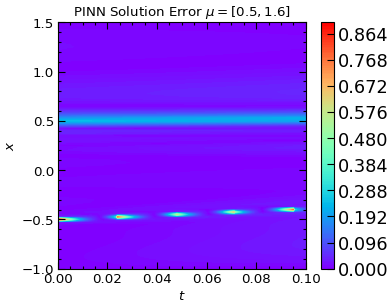

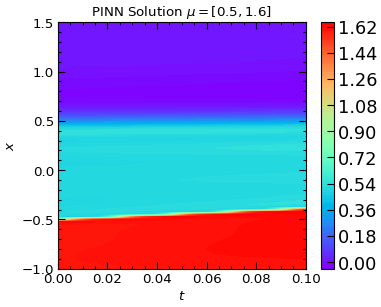

Epoch: 4200 | loss: 0.016659289598464966,rMAE: 0.040690816938877106, rRMSE:0.0615406297147274,loss_RH:0.00000000,loss_con:2.56486464,loss_R:0.002277571940794587,loss_IC:0.001434390782378614,loss_BC:3.780985025514383e-06
Epoch: 4400 | loss: 0.015069006010890007,rMAE: 0.03873253986239433, rRMSE:0.05933268740773201,loss_RH:0.00000000,loss_con:2.56546831,loss_R:0.0021040313877165318,loss_IC:0.0012896318221464753,loss_BC:6.8656863732030615e-06
Epoch: 4600 | loss: 0.013580466620624065,rMAE: 0.03628791868686676, rRMSE:0.057260770350694656,loss_RH:0.00000000,loss_con:2.56482601,loss_R:0.001947461860254407,loss_IC:0.001155488658696413,loss_BC:7.811773684807122e-06
Epoch: 4800 | loss: 0.01221284456551075,rMAE: 0.0341540202498436, rRMSE:0.055330563336610794,loss_RH:0.00000000,loss_con:2.54933643,loss_R:0.0017993039218708873,loss_IC:0.0010294480016455054,loss_BC:1.1905995961569715e-05
Epoch: 5000 | loss: 0.010510356165468693,rMAE: 0.030337022617459297, rRMSE:0.052984703332185745,loss_RH:0.00000000

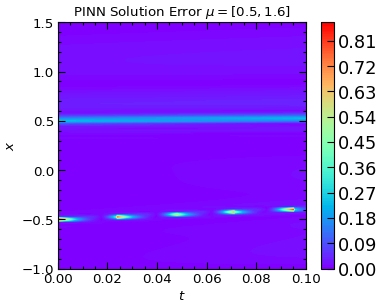

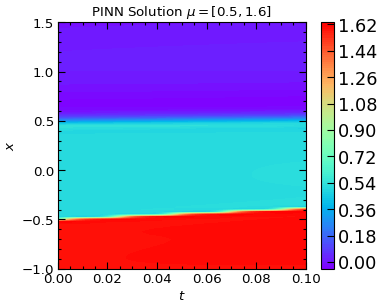

Epoch: 5200 | loss: 0.008908797986805439,rMAE: 0.026903221383690834, rRMSE:0.050718799233436584,loss_RH:0.00000000,loss_con:2.56387568,loss_R:0.0014863255200907588,loss_IC:0.0007371486281044781,loss_BC:5.098575456941035e-06
Epoch: 5400 | loss: 0.007336059119552374,rMAE: 0.023659033700823784, rRMSE:0.04843931272625923,loss_RH:0.00000000,loss_con:2.56299019,loss_R:0.001338966190814972,loss_IC:0.0005962566356174648,loss_BC:3.4526592571637593e-06
Epoch: 5600 | loss: 0.005802242085337639,rMAE: 0.020511917769908905, rRMSE:0.046188835054636,loss_RH:0.00000000,loss_con:2.56278944,loss_R:0.001207857159897685,loss_IC:0.0004573661426547915,loss_BC:2.0723471152450657e-06
Epoch: 5800 | loss: 0.004161824006587267,rMAE: 0.01751331053674221, rRMSE:0.043969348073005676,loss_RH:0.00000000,loss_con:2.56288552,loss_R:0.0010735350660979748,loss_IC:0.0003076705615967512,loss_BC:1.1583225614231196e-06
Epoch: 6000 | loss: 0.002776028821244836,rMAE: 0.014594719745218754, rRMSE:0.04165048897266388,loss_RH:0.000

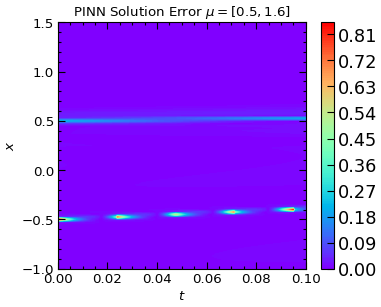

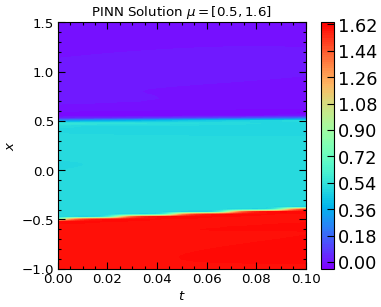

Epoch: 6200 | loss: 0.0018761774990707636,rMAE: 0.013841301202774048, rRMSE:0.040159840136766434,loss_RH:0.00000000,loss_con:2.56010413,loss_R:0.00088968948693946,loss_IC:9.84175203484483e-05,loss_BC:2.312803388804241e-07
Epoch: 6400 | loss: 0.0038472802843898535,rMAE: 0.020205596461892128, rRMSE:0.03933035954833031,loss_RH:0.00000000,loss_con:2.49867487,loss_R:0.000873578479513526,loss_IC:0.00010992940951837227,loss_BC:0.00018744077533483505
Epoch: 6600 | loss: 0.0013330949004739523,rMAE: 0.012462177313864231, rRMSE:0.038150060921907425,loss_RH:0.00000000,loss_con:2.54263878,loss_R:0.0008000168018043041,loss_IC:3.830602872767486e-05,loss_BC:1.500177586422069e-05
Epoch: 6800 | loss: 0.0010971256997436285,rMAE: 0.013019786216318607, rRMSE:0.036937762051820755,loss_RH:0.00000000,loss_con:2.57394767,loss_R:0.0007523241802118719,loss_IC:2.47504922299413e-05,loss_BC:9.729666999191977e-06
Epoch: 7000 | loss: 0.0029239505529403687,rMAE: 0.019779710099101067, rRMSE:0.047801826149225235,loss_RH

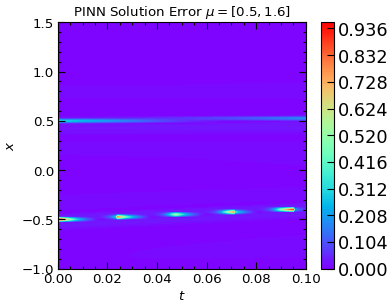

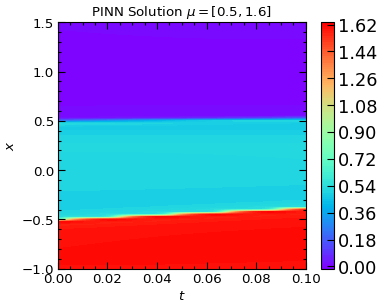

Epoch: 7200 | loss: 0.0009110788814723492,rMAE: 0.011137456633150578, rRMSE:0.03622373193502426,loss_RH:0.00000000,loss_con:2.55974650,loss_R:0.0007219834951683879,loss_IC:1.753572723828256e-05,loss_BC:1.3738115285377717e-06
Epoch: 7400 | loss: 0.0007974376203492284,rMAE: 0.010148895904421806, rRMSE:0.03385118395090103,loss_RH:0.00000000,loss_con:2.55981421,loss_R:0.0006578550091944635,loss_IC:1.308391074417159e-05,loss_BC:8.743469948058191e-07
Epoch: 7600 | loss: 0.000738413305953145,rMAE: 0.009873682633042336, rRMSE:0.03314489126205444,loss_RH:0.00000000,loss_con:2.56023955,loss_R:0.0006249213474802673,loss_IC:1.0663356079021469e-05,loss_BC:6.85839836478408e-07
Epoch: 7800 | loss: 0.0007029309635981917,rMAE: 0.009695684537291527, rRMSE:0.03265969827771187,loss_RH:0.00000000,loss_con:2.55837870,loss_R:0.0006032779347151518,loss_IC:9.267624591302592e-06,loss_BC:6.976802637836954e-07
Epoch: 8000 | loss: 0.0007064624805934727,rMAE: 0.009948856197297573, rRMSE:0.032267797738313675,loss_RH

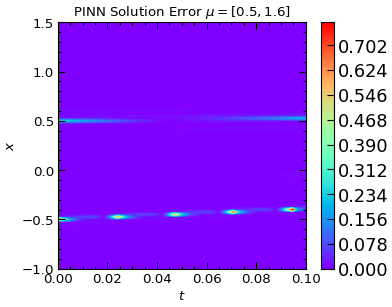

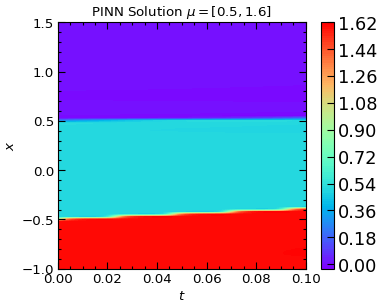

Epoch: 8200 | loss: 0.0006505182827822864,rMAE: 0.00936920940876007, rRMSE:0.03187807649374008,loss_RH:0.00000000,loss_con:2.55987525,loss_R:0.0005730852135457098,loss_IC:7.328009814955294e-06,loss_BC:4.1529736449774646e-07
Epoch: 8400 | loss: 0.0006293878541328013,rMAE: 0.009121309965848923, rRMSE:0.03149913251399994,loss_RH:0.00000000,loss_con:2.56017375,loss_R:0.0005598390125669539,loss_IC:6.571580797753995e-06,loss_BC:3.8330219354065775e-07
Epoch: 8600 | loss: 0.0006136326119303703,rMAE: 0.008868593722581863, rRMSE:0.03113214299082756,loss_RH:0.00000000,loss_con:2.56255460,loss_R:0.0005470032338052988,loss_IC:5.981582035019528e-06,loss_BC:6.813570507802069e-07
Epoch: 8800 | loss: 0.0014265939826145768,rMAE: 0.01298715453594923, rRMSE:0.03133891895413399,loss_RH:0.00000000,loss_con:2.59649324,loss_R:0.0005567131447605789,loss_IC:2.1599969841190614e-05,loss_BC:6.538811430800706e-05
Epoch: 9000 | loss: 0.000572616292629391,rMAE: 0.008376860991120338, rRMSE:0.03019745834171772,loss_RH:

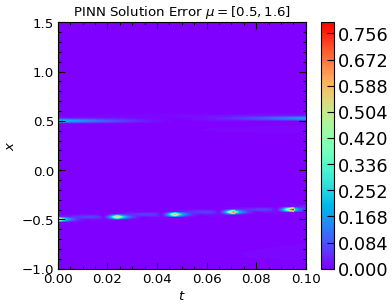

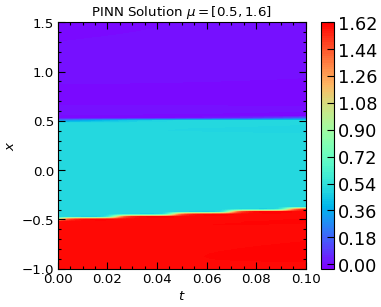

Epoch: 9200 | loss: 0.000553619465790689,rMAE: 0.008095044642686844, rRMSE:0.02972797118127346,loss_RH:0.00000000,loss_con:2.56012869,loss_R:0.0005051370244473219,loss_IC:4.539090241451049e-06,loss_BC:3.09156774846997e-07
Epoch: 9400 | loss: 0.0005409514415077865,rMAE: 0.00781160918995738, rRMSE:0.02929604798555374,loss_RH:0.00000000,loss_con:2.56312680,loss_R:0.0004917584592476487,loss_IC:4.141018507652916e-06,loss_BC:7.782796274113934e-07
Epoch: 9600 | loss: 0.0007978734211064875,rMAE: 0.0091788275167346, rRMSE:0.028993036597967148,loss_RH:0.00000000,loss_con:2.58115268,loss_R:0.00048597512068226933,loss_IC:8.939995495893527e-06,loss_BC:2.224983472842723e-05
Epoch: 9800 | loss: 0.0005014903726987541,rMAE: 0.0072885374538600445, rRMSE:0.02844504453241825,loss_RH:0.00000000,loss_con:2.56003976,loss_R:0.0004640986444428563,loss_IC:3.4672750643949257e-06,loss_BC:2.7189611273570335e-07
Epoch: 9819 | Loss: 0.0004999609082005918 ,rMAE: 0.007267601788043976, rRMSE:0.02840171381831169(Stoppin

In [47]:
print("******************************************************************")
########################### Full PINN Training ############################    
residual_data0 = create_residual_data(Xi, Xf, Ti, Tf0, Nx_train0, Nt_train0, Nx_test0, Nt_test0, dx,dt)
xt_resid0      = residual_data0[0].to(device)
f_hat0         = residual_data0[1].to(device)
xt_test0       = residual_data0[2].to(device)
xt_RHL0      = residual_data0[3].to(device)
xt_RHR0      = residual_data0[4].to(device)
xt_RHt0         = residual_data0[5].to(device)
xt_RHtL0       = residual_data0[6].to(device)

BC_data = create_BC_data(Xi, Xf, Ti, Tf0, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

IC_data0 = create_IC_data(nu_pinn_train,Xi, Xf, Ti, Tf0, IC_pts, IC_simple)
IC_xt0     = IC_data0[0].to(device)
IC_u0      = IC_data0[1].to(device)
#plt.scatter(IC_xt[:,1].detach().cpu(),IC_xt[:,0].detach().cpu(),s=0.1)
xt_en = Move_Time_1D(IC_xt0, Tf0).to(device)

Exact_y0 = exact_u(nu_pinn_train,xt_test0)[:,None].to(device)
###   IFNN2 training   ####
pinn_train_time_1 = time.perf_counter()

PINN0 = NN1(nu_pinn_train, layers_pinn,dt).to(device)
    
pinn1_losses = pinn1_train(PINN0, nu_pinn_train, xt_resid0, IC_xt0, IC_u0, BC1, BC2, xt_RHL0,xt_RHR0,xt_RHt0,xt_RHtL0, f_hat0, Exact_y0, epochs_pinn0, lr_pinn0, tol_pinn0, xt_test0)

pinn_train_time_2 = time.perf_counter()
print(f"PINN Training Time: {(pinn_train_time_2-pinn_train_time_1)/3600} Hours")


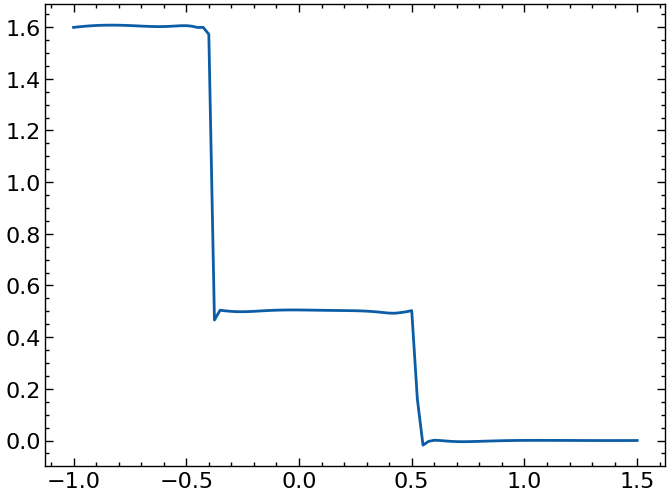

In [48]:
plt.plot(xt_test1[:Nx_test,0].detach().cpu(),PINN0(xt_test1)[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu())

In [81]:
Nx_test0=1001
Nt_test0=2
residual_data0 = create_residual_data(Xi, Xf, Ti, Tf0, Nx_train0, Nt_train0, Nx_test0, Nt_test0, dx,dt)
#xt_resid1      = residual_data1[0].to(device)
#f_hat1         = residual_data1[1].to(device)
xt_test0       = residual_data0[2].to(device)
#xt_RHL1      = residual_data1[3].to(device)
#xt_RHR1      = residual_data1[4].to(device)
#xt_RHt1         = residual_data1[5].to(device)
#xt_RHtL1       = residual_data1[6].to(device)

tensor(0.9200, device='cuda:0') 1.250001311302185 1.25


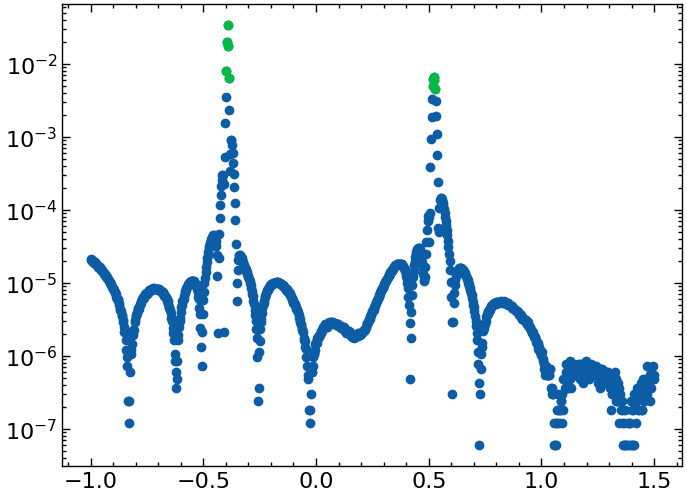

In [84]:
dx=1e-4
cut_x = torch.cat([xt_test0[:Nx_test0, 0].unsqueeze(1), Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
cut_dx1 = torch.cat([xt_test0[:Nx_test0, 0].unsqueeze(1)+dx, Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
cut_dx2 = torch.cat([xt_test0[:Nx_test0, 0].unsqueeze(1) - dx, Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
diff_x=torch.abs(PINN0(cut_dx2)-PINN0(cut_dx1))
plt.scatter(cut_x[:Nx_test0,0].detach().cpu(),diff_x.detach().cpu())
top_values, top_indices = torch.topk(diff_x.squeeze(), k=10)
plt.scatter(cut_x[top_indices,0].detach().cpu(),diff_x[top_indices].detach().cpu())
cut_dx=torch.abs(cut_x[top_indices[-1],0]-cut_x[top_indices[0],0])
cut_t = (Tf0/(1-cut_dx)).item()
print(cut_dx,cut_t,2/nu_pinn_train[1])
plt.yscale('log')

In [90]:
y=diff_x.squeeze()
# Step 1: 找到所有局部极大值的索引
grad = torch.diff(y)  # 一阶差分来获取梯度
local_maxima = (grad[:-1] > 0) & (grad[1:] < 0)  # 局部极大值条件
peak_indices = torch.nonzero(local_maxima)[:, 0] + 1  # 局部极大值索引加 1 来对齐原数组

# Step 2: 找到两个峰值区域，挑选每个峰值区域的最高点
# 将极大值分为两组，按索引划分，假设两峰在不同区域
# （如果位置未知，也可以使用聚类算法对这些峰值进行分组）

# 例如假设前半段和后半段各有一个峰
first_peak_region = peak_indices[peak_indices < len(y) // 2]
second_peak_region = peak_indices[peak_indices >= len(y) // 2]

# Step 3: 获取每个区域的最大值索引
first_peak_index = first_peak_region[y[first_peak_region].argmax()]
second_peak_index = second_peak_region[y[second_peak_region].argmax()]

print("第一个峰的最高值索引:", first_peak_index.item())
print("第二个峰的最高值索引:", second_peak_index.item())

cut_dx=torch.abs(cut_x[second_peak_index,0]-cut_x[first_peak_index,0])
cut_t = (Tf0/(1-cut_dx)).item()
print(cut_dx,cut_t,2/nu_pinn_train[1])


第一个峰的最高值索引: 243
第二个峰的最高值索引: 609
tensor(0.9150, device='cuda:0') 1.1764717102050781 1.25


In [91]:
Ti, Tf         =  0.0, cut_t
Ti2, Tf2       =  cut_t, 1.5

******************************************************************
Epoch: 200 | loss: 0.7945085167884827,rMAE: 0.3628706634044647, rRMSE:0.3895915746688843,loss_RH:0.00000000,loss_con:2.52620530,loss_R:0.09879662096500397,loss_IC:0.06370894610881805,loss_BC:0.005862240679562092
Epoch: 400 | loss: 0.5912314057350159,rMAE: 0.4017242193222046, rRMSE:0.4453016221523285,loss_RH:0.00000000,loss_con:2.62400365,loss_R:0.1144176572561264,loss_IC:0.046983398497104645,loss_BC:0.0006979769677855074
Epoch: 600 | loss: 0.5673777461051941,rMAE: 0.377122163772583, rRMSE:0.4179142117500305,loss_RH:0.00000000,loss_con:2.63183522,loss_R:0.10539538413286209,loss_IC:0.045642007142305374,loss_BC:0.0005562304286286235
Epoch: 800 | loss: 0.3988426923751831,rMAE: 0.2370806187391281, rRMSE:0.266482412815094,loss_RH:0.00000000,loss_con:2.57871675,loss_R:0.049441732466220856,loss_IC:0.03444178029894829,loss_BC:0.0004983159597031772
Epoch: 1000 | loss: 0.2178913652896881,rMAE: 0.19126436114311218, rRMSE:0.22335097

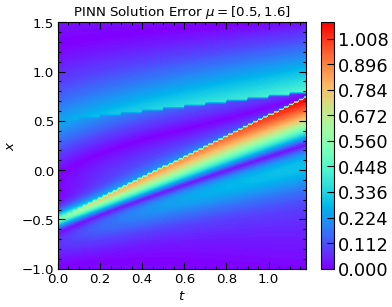

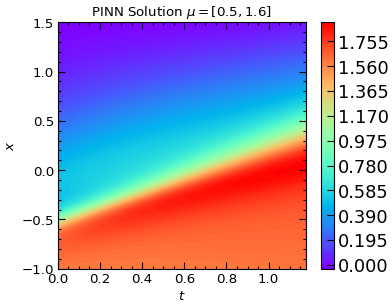

Epoch: 1200 | loss: 0.15260951220989227,rMAE: 0.11373284459114075, rRMSE:0.13560602068901062,loss_RH:0.00000000,loss_con:2.57469177,loss_R:0.01798231527209282,loss_IC:0.01336512342095375,loss_BC:9.759613021742553e-05
Epoch: 1400 | loss: 0.14091335237026215,rMAE: 0.10850232094526291, rRMSE:0.12029154598712921,loss_RH:0.00000000,loss_con:2.57489634,loss_R:0.016444331035017967,loss_IC:0.012362907640635967,loss_BC:8.399399666814134e-05
Epoch: 1600 | loss: 0.1318468302488327,rMAE: 0.10424215346574783, rRMSE:0.11495371162891388,loss_RH:0.00000000,loss_con:2.57043934,loss_R:0.015569758601486683,loss_IC:0.01156411599367857,loss_BC:6.359125109156594e-05
Epoch: 1800 | loss: 0.12458932399749756,rMAE: 0.10518555343151093, rRMSE:0.1138887107372284,loss_RH:0.00000000,loss_con:2.62338352,loss_R:0.014392717741429806,loss_IC:0.010775013826787472,loss_BC:0.0002446467406116426
Epoch: 2000 | loss: 0.11328651756048203,rMAE: 0.09654352813959122, rRMSE:0.10866034775972366,loss_RH:0.00000000,loss_con:2.571617

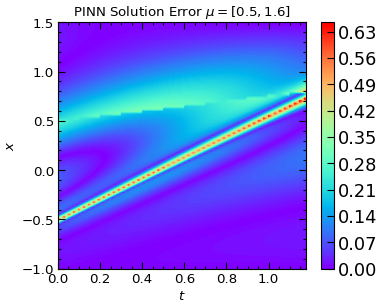

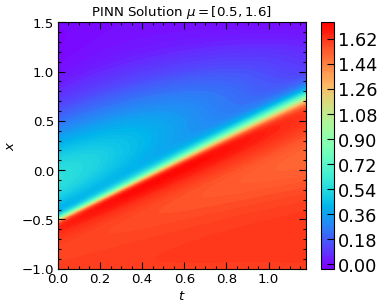

Epoch: 2200 | loss: 0.1031854972243309,rMAE: 0.09263768792152405, rRMSE:0.10551616549491882,loss_RH:0.00000000,loss_con:2.56830406,loss_R:0.013217173516750336,loss_IC:0.008981102146208286,loss_BC:1.5729814549558796e-05
Epoch: 2400 | loss: 0.09266926348209381,rMAE: 0.08955016732215881, rRMSE:0.10244202613830566,loss_RH:0.00000000,loss_con:2.56316161,loss_R:0.01244891807436943,loss_IC:0.008013292215764523,loss_BC:8.742040336073842e-06
Epoch: 2600 | loss: 0.08237981796264648,rMAE: 0.0872892215847969, rRMSE:0.09947424381971359,loss_RH:0.00000000,loss_con:2.55963230,loss_R:0.011684766039252281,loss_IC:0.007057251408696175,loss_BC:1.2253392924321815e-05
Epoch: 2800 | loss: 0.07320982217788696,rMAE: 0.08574037253856659, rRMSE:0.09663861989974976,loss_RH:0.00000000,loss_con:2.55523920,loss_R:0.010983879677951336,loss_IC:0.006199265364557505,loss_BC:2.332938129256945e-05
Epoch: 3000 | loss: 0.06547344475984573,rMAE: 0.0838632881641388, rRMSE:0.09368718415498734,loss_RH:0.00000000,loss_con:2.551

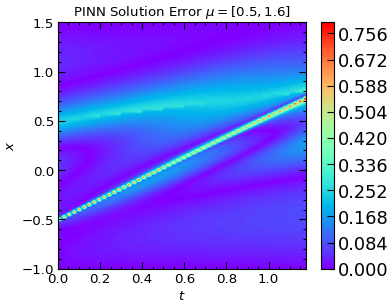

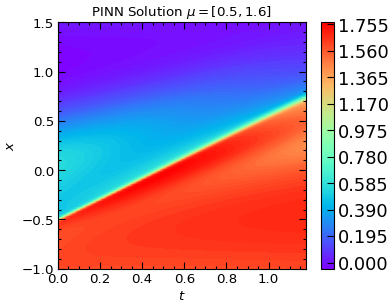

Epoch: 3200 | loss: 0.05916668102145195,rMAE: 0.07982932031154633, rRMSE:0.09033650159835815,loss_RH:0.00000000,loss_con:2.56561542,loss_R:0.009493977762758732,loss_IC:0.004920673090964556,loss_BC:4.659744809032418e-05
Epoch: 3400 | loss: 0.05310951545834541,rMAE: 0.07503029704093933, rRMSE:0.08578139543533325,loss_RH:0.00000000,loss_con:2.54709721,loss_R:0.0084786182269454,loss_IC:0.00440582912415266,loss_BC:5.7260331232100725e-05
Epoch: 3600 | loss: 0.047404944896698,rMAE: 0.06794919818639755, rRMSE:0.08051644265651703,loss_RH:0.00000000,loss_con:2.54767108,loss_R:0.007305490784347057,loss_IC:0.00395564641803503,loss_BC:5.42991328984499e-05
Epoch: 3800 | loss: 0.041265133768320084,rMAE: 0.060370806604623795, rRMSE:0.07450955361127853,loss_RH:0.00000000,loss_con:2.54743886,loss_R:0.00610326835885644,loss_IC:0.0034662303514778614,loss_BC:4.995621566195041e-05
Epoch: 4000 | loss: 0.03667208179831505,rMAE: 0.05686914920806885, rRMSE:0.06907790899276733,loss_RH:0.00000000,loss_con:2.47850

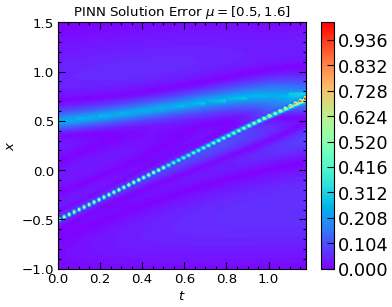

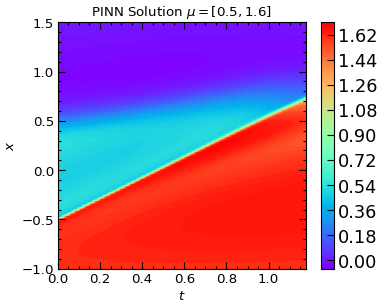

Epoch: 4200 | loss: 0.0320248045027256,rMAE: 0.03701251372694969, rRMSE:0.06030726432800293,loss_RH:0.00000000,loss_con:2.66837358,loss_R:0.004048374015837908,loss_IC:0.002226638374850154,loss_BC:0.0005710048135370016
Epoch: 4400 | loss: 0.017810694873332977,rMAE: 0.037470098584890366, rRMSE:0.05651767551898956,loss_RH:0.00000000,loss_con:2.51880813,loss_R:0.0028087564278393984,loss_IC:0.0014160218415781856,loss_BC:8.417203207500279e-05
Epoch: 4600 | loss: 0.013027673587203026,rMAE: 0.029440436512231827, rRMSE:0.05268900468945503,loss_RH:0.00000000,loss_con:2.55611658,loss_R:0.002437520306557417,loss_IC:0.001056010602042079,loss_BC:3.004713107657153e-06
Epoch: 4800 | loss: 0.01055267732590437,rMAE: 0.026439446955919266, rRMSE:0.05068417638540268,loss_RH:0.00000000,loss_con:2.56079388,loss_R:0.002126804320141673,loss_IC:0.000840058084577322,loss_BC:2.529225639591459e-06
Epoch: 5000 | loss: 0.008700496517121792,rMAE: 0.023602379485964775, rRMSE:0.04917985945940018,loss_RH:0.00000000,loss

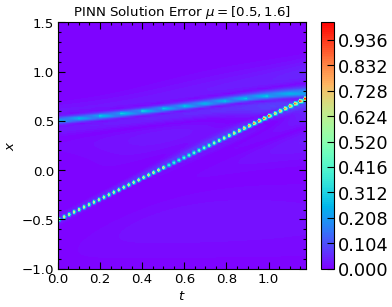

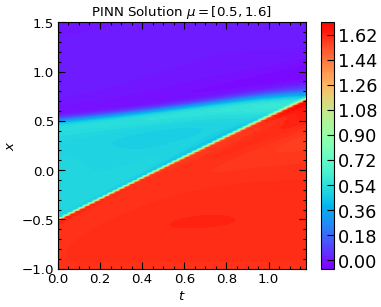

Epoch: 5200 | loss: 0.007237261161208153,rMAE: 0.021232882514595985, rRMSE:0.04801008850336075,loss_RH:0.00000000,loss_con:2.56348634,loss_R:0.0016610095044597983,loss_IC:0.0005556456744670868,loss_BC:1.979490434678155e-06
Epoch: 5400 | loss: 0.011245939880609512,rMAE: 0.02245684526860714, rRMSE:0.04714483395218849,loss_RH:0.00000000,loss_con:2.65083814,loss_R:0.0016994512407109141,loss_IC:0.0005561791476793587,loss_BC:0.000398469710489735
Epoch: 5600 | loss: 0.005027945153415203,rMAE: 0.018366634845733643, rRMSE:0.04594338312745094,loss_RH:0.00000000,loss_con:2.55888772,loss_R:0.0013606250286102295,loss_IC:0.00036536986590363085,loss_BC:1.362119860459643e-06
Epoch: 5800 | loss: 0.004162751138210297,rMAE: 0.01746230013668537, rRMSE:0.04525405168533325,loss_RH:0.00000000,loss_con:2.55894113,loss_R:0.0012555766152217984,loss_IC:0.0002893253113143146,loss_BC:1.3921376194048207e-06
Epoch: 6000 | loss: 0.003397318534553051,rMAE: 0.01682060956954956, rRMSE:0.04539280757308006,loss_RH:0.00000

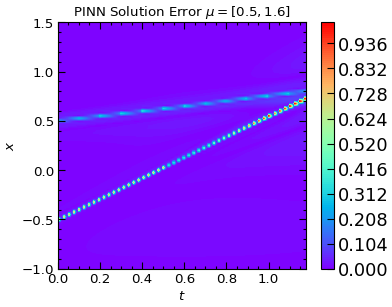

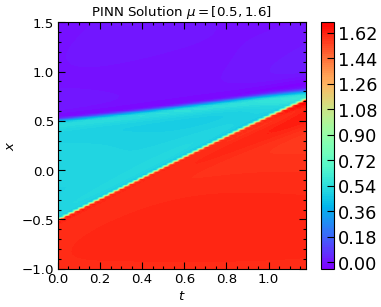

Epoch: 6200 | loss: 0.0028247511945664883,rMAE: 0.016244638711214066, rRMSE:0.044475916773080826,loss_RH:0.00000000,loss_con:2.54747915,loss_R:0.0010814678389579058,loss_IC:0.00016526435501873493,loss_BC:9.063978723133914e-06
Epoch: 6400 | loss: 0.002194824628531933,rMAE: 0.015560251660645008, rRMSE:0.04433637484908104,loss_RH:0.00000000,loss_con:2.55898023,loss_R:0.0010170305613428354,loss_IC:0.00011649289081105962,loss_BC:1.2865234566561412e-06
Epoch: 6600 | loss: 0.0017792144790291786,rMAE: 0.015037915669381618, rRMSE:0.044191960245370865,loss_RH:0.00000000,loss_con:2.55914783,loss_R:0.0009565348154865205,loss_IC:8.103427535388619e-05,loss_BC:1.233688408319722e-06
Epoch: 6800 | loss: 0.0014537293463945389,rMAE: 0.01439608819782734, rRMSE:0.04258279129862785,loss_RH:0.00000000,loss_con:2.55963778,loss_R:0.0008790433639660478,loss_IC:5.6294247769983485e-05,loss_BC:1.1743425147869857e-06
Epoch: 7000 | loss: 0.001243135891854763,rMAE: 0.013921018689870834, rRMSE:0.04241139441728592,loss

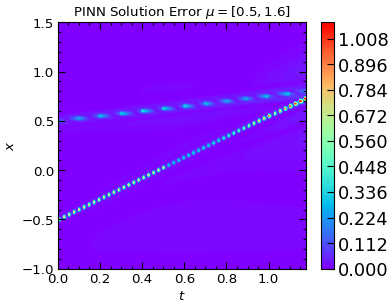

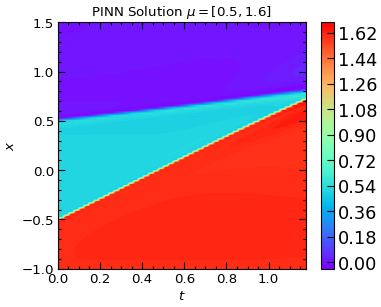

Epoch: 7200 | loss: 0.0012408863985911012,rMAE: 0.013306334614753723, rRMSE:0.04209998995065689,loss_RH:0.00000000,loss_con:2.57507730,loss_R:0.0007978137000463903,loss_IC:3.2177067623706535e-05,loss_BC:1.2130200047977269e-05
Epoch: 7400 | loss: 0.000981388846412301,rMAE: 0.012932756915688515, rRMSE:0.04208742082118988,loss_RH:0.00000000,loss_con:2.56005073,loss_R:0.000747606682125479,loss_IC:2.2369926227838732e-05,loss_BC:1.0082953849632759e-06
Epoch: 7600 | loss: 0.0008982990402728319,rMAE: 0.012485643848776817, rRMSE:0.04223378002643585,loss_RH:0.00000000,loss_con:2.55958152,loss_R:0.0007118652574717999,loss_IC:1.76895409822464e-05,loss_BC:9.538346148474375e-07
Epoch: 7800 | loss: 0.0008266061777248979,rMAE: 0.011870324611663818, rRMSE:0.04084799811244011,loss_RH:0.00000000,loss_con:2.55982566,loss_R:0.0006747127627022564,loss_IC:1.4314050531538669e-05,loss_BC:8.752942335377156e-07
Epoch: 8000 | loss: 0.0007763068424537778,rMAE: 0.011269486509263515, rRMSE:0.0398472361266613,loss_RH

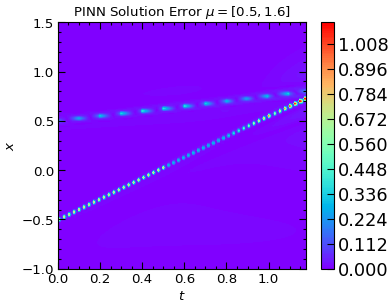

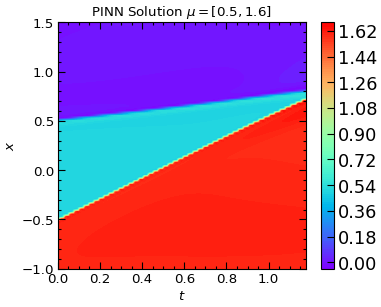

Epoch: 8200 | loss: 0.011229473166167736,rMAE: 0.02267272025346756, rRMSE:0.043632689863443375,loss_RH:0.00000000,loss_con:2.43293262,loss_R:0.0008584369788877666,loss_IC:0.00021517518325708807,loss_BC:0.000821928377263248
Epoch: 8400 | loss: 0.0006826047319918871,rMAE: 0.010642710141837597, rRMSE:0.04109671339392662,loss_RH:0.00000000,loss_con:2.55971098,loss_R:0.0005902829580008984,loss_IC:8.569111741962843e-06,loss_BC:6.630652364947309e-07
Epoch: 8600 | loss: 0.0007112498278729618,rMAE: 0.009960392490029335, rRMSE:0.03880146145820618,loss_RH:0.00000000,loss_con:2.55936313,loss_R:0.0006091852555982769,loss_IC:8.964034350356087e-06,loss_BC:1.2424211490724701e-06
Epoch: 8800 | loss: 0.0006147634703665972,rMAE: 0.014281012117862701, rRMSE:0.039063211530447006,loss_RH:0.00000000,loss_con:2.56131291,loss_R:0.0005421909154392779,loss_IC:6.608358035009587e-06,loss_BC:6.489001975751307e-07
Epoch: 9000 | loss: 0.0005845694686286151,rMAE: 0.009193172678351402, rRMSE:0.038083210587501526,loss_R

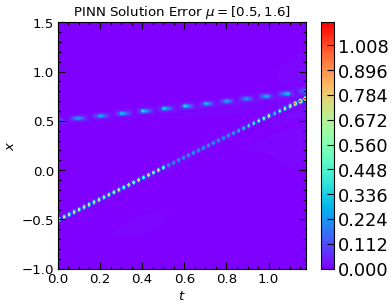

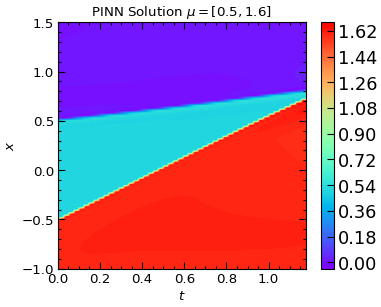

Epoch: 9200 | loss: 0.0005532480427064002,rMAE: 0.008837793953716755, rRMSE:0.03736099228262901,loss_RH:0.00000000,loss_con:2.55824327,loss_R:0.0004961612285114825,loss_IC:5.085245902591851e-06,loss_BC:6.234363922885677e-07
Epoch: 9400 | loss: 0.0005299675976857543,rMAE: 0.00858554057776928, rRMSE:0.037801023572683334,loss_RH:0.00000000,loss_con:2.56105185,loss_R:0.00047821144107729197,loss_IC:4.646674369723769e-06,loss_BC:5.289400633046171e-07
Epoch: 9600 | loss: 0.0005048573948442936,rMAE: 0.008102058432996273, rRMSE:0.03657569736242294,loss_RH:0.00000000,loss_con:2.55973530,loss_R:0.00045884287101216614,loss_IC:4.191659172647633e-06,loss_BC:4.0979531945595227e-07
Epoch: 9800 | loss: 0.0005101992865093052,rMAE: 0.007957246154546738, rRMSE:0.03782505914568901,loss_RH:0.00000000,loss_con:2.55969071,loss_R:0.0004652998468372971,loss_IC:4.133937181904912e-06,loss_BC:3.560090249266068e-07
Epoch: 10000 | loss: 0.0004687180044129491,rMAE: 0.007605744991451502, rRMSE:0.0364166796207428,loss_

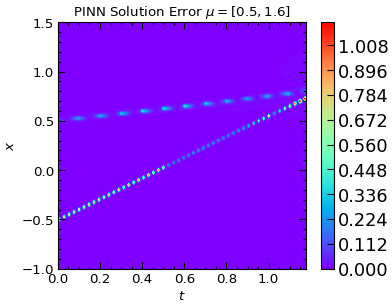

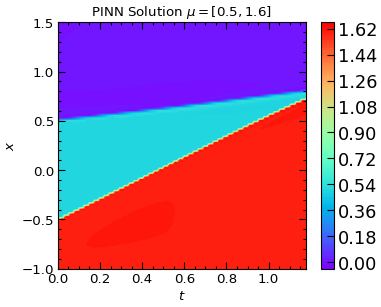

Epoch: 10200 | loss: 0.0004709146451205015,rMAE: 0.00716649554669857, rRMSE:0.03429446369409561,loss_RH:0.00000000,loss_con:2.56154037,loss_R:0.00042799892253242433,loss_IC:3.639920578279998e-06,loss_BC:6.516518169519259e-07
Epoch: 10400 | loss: 0.0004648789472412318,rMAE: 0.006843367591500282, rRMSE:0.03421900048851967,loss_RH:0.00000000,loss_con:2.56302261,loss_R:0.0004219191614538431,loss_IC:3.546507059581927e-06,loss_BC:7.494713258893171e-07
Epoch: 10600 | loss: 0.02341695874929428,rMAE: 0.02506338618695736, rRMSE:0.05141773447394371,loss_RH:0.00000000,loss_con:2.55256867,loss_R:0.002847622148692608,loss_IC:0.0020483785774558783,loss_BC:8.555221938877366e-06
Epoch: 10800 | loss: 0.0037175919860601425,rMAE: 0.018765093758702278, rRMSE:0.04113086313009262,loss_RH:0.00000000,loss_con:2.56192613,loss_R:0.0016151455929502845,loss_IC:0.00020749571558553725,loss_BC:2.7489311378303682e-06
Epoch: 11000 | loss: 0.002011524047702551,rMAE: 0.0142737478017807, rRMSE:0.0371476449072361,loss_RH:0

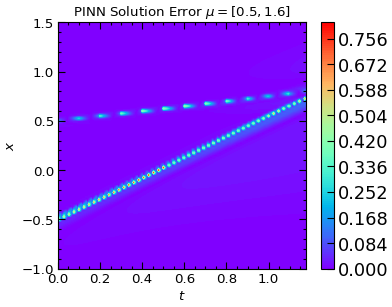

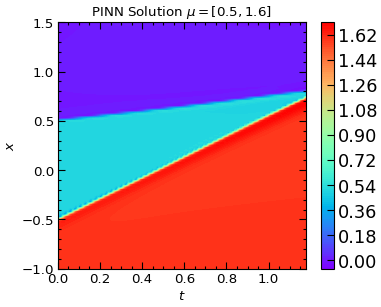

Epoch: 11200 | loss: 0.001445634989067912,rMAE: 0.011428765021264553, rRMSE:0.034657806158065796,loss_RH:0.00000000,loss_con:2.56238985,loss_R:0.0010650818003341556,loss_IC:3.6777855711989105e-05,loss_BC:1.277470573768369e-06
Epoch: 11400 | loss: 0.0013307046610862017,rMAE: 0.011982967145740986, rRMSE:0.033570148050785065,loss_RH:0.00000000,loss_con:2.54354477,loss_R:0.0009532457333989441,loss_IC:2.400305493210908e-05,loss_BC:1.3742845112574287e-05
Epoch: 11600 | loss: 0.0009671289008110762,rMAE: 0.009128591977059841, rRMSE:0.03255532309412956,loss_RH:0.00000000,loss_con:2.56001830,loss_R:0.000862824555952102,loss_IC:1.0227905477222521e-05,loss_BC:2.0253112609225354e-07
Epoch: 11800 | loss: 0.0008546488243155181,rMAE: 0.008488157764077187, rRMSE:0.03196211904287338,loss_RH:0.00000000,loss_con:2.55981278,loss_R:0.0008051921613514423,loss_IC:4.837666892854031e-06,loss_BC:1.0799734440070097e-07
Epoch: 12000 | loss: 0.0008004720439203084,rMAE: 0.007979665882885456, rRMSE:0.0314033329486846

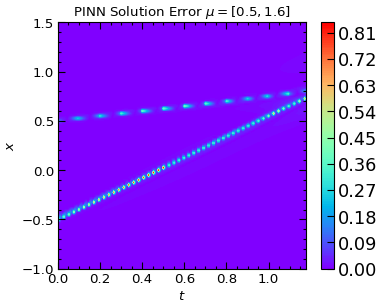

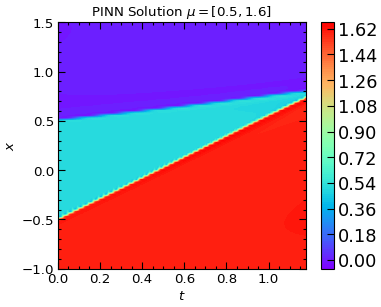

Epoch: 12200 | loss: 0.000772183237131685,rMAE: 0.007538091856986284, rRMSE:0.030897535383701324,loss_RH:0.00000000,loss_con:2.56433582,loss_R:0.0007352391839958727,loss_IC:2.6950256142299622e-06,loss_BC:9.993802905228222e-07
Epoch: 12400 | loss: 0.0008074076613411307,rMAE: 0.007129440549761057, rRMSE:0.030570244416594505,loss_RH:0.00000000,loss_con:2.54846787,loss_R:0.000707687926478684,loss_IC:3.1592016966897063e-06,loss_BC:6.812772880948614e-06
Epoch: 12600 | loss: 0.000694393995217979,rMAE: 0.0069249095395207405, rRMSE:0.03030725196003914,loss_RH:0.00000000,loss_con:2.55947280,loss_R:0.0006777156377211213,loss_IC:1.5741270544822328e-06,loss_BC:9.370707232392306e-08
Epoch: 12800 | loss: 0.0006667445995844901,rMAE: 0.006639725994318724, rRMSE:0.029995188117027283,loss_RH:0.00000000,loss_con:2.55946612,loss_R:0.0006521992618218064,loss_IC:1.3689249271919834e-06,loss_BC:8.560996889173111e-08
Epoch: 13000 | loss: 0.0006459175492636859,rMAE: 0.006515610963106155, rRMSE:0.0300229601562023

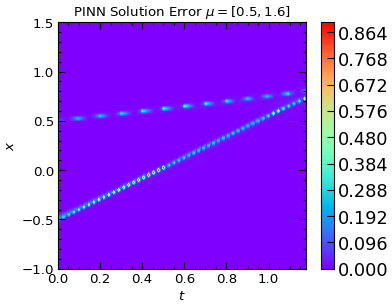

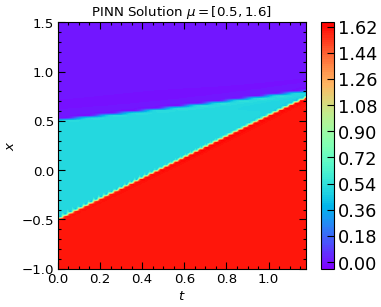

Epoch: 13200 | loss: 0.0006097205332480371,rMAE: 0.006278908345848322, rRMSE:0.02986910566687584,loss_RH:0.00000000,loss_con:2.55989242,loss_R:0.000599176506511867,loss_IC:9.831072702581878e-07,loss_BC:7.129523282856098e-08
Epoch: 13400 | loss: 0.0005829324363730848,rMAE: 0.006095699965953827, rRMSE:0.02966686524450779,loss_RH:0.00000000,loss_con:2.55972362,loss_R:0.0005736596649512649,loss_IC:8.504426318722835e-07,loss_BC:7.683327396534878e-08
Epoch: 13600 | loss: 0.0005574030801653862,rMAE: 0.005903921090066433, rRMSE:0.029169587418437004,loss_RH:0.00000000,loss_con:2.55989742,loss_R:0.0005492590134963393,loss_IC:7.454248702742916e-07,loss_BC:6.898445548131349e-08
Epoch: 13800 | loss: 0.0005551956710405648,rMAE: 0.005843682214617729, rRMSE:0.02924930490553379,loss_RH:0.00000000,loss_con:2.56032395,loss_R:0.0005458985106088221,loss_IC:8.561186746192107e-07,loss_BC:7.359676601481624e-08
Epoch: 14000 | loss: 0.0005009733140468597,rMAE: 0.00578978331759572, rRMSE:0.0293376874178648,loss_

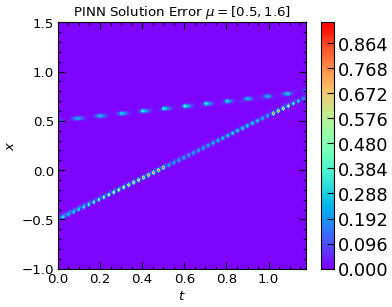

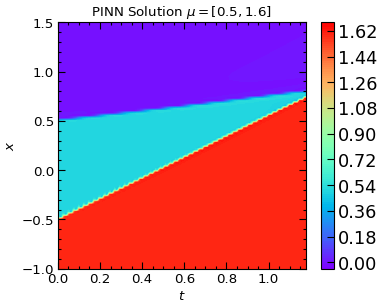

Epoch: 14200 | loss: 0.0004727389896288514,rMAE: 0.005515088327229023, rRMSE:0.028591034933924675,loss_RH:0.00000000,loss_con:2.56171346,loss_R:0.0004635362420231104,loss_IC:7.125574938982027e-07,loss_BC:2.0771724962287408e-07
Epoch: 14400 | loss: 0.00048161984886974096,rMAE: 0.005832464434206486, rRMSE:0.028896568343043327,loss_RH:0.00000000,loss_con:2.56522441,loss_R:0.0004380143072921783,loss_IC:2.618547341626254e-06,loss_BC:1.742006816130015e-06
Epoch: 14600 | loss: 0.0012641994981095195,rMAE: 0.009210321120917797, rRMSE:0.029297474771738052,loss_RH:0.00000000,loss_con:2.59549594,loss_R:0.00043205919791944325,loss_IC:2.1371857656049542e-05,loss_BC:6.184217636473477e-05
Epoch: 14800 | loss: 0.00039216739241965115,rMAE: 0.005051000043749809, rRMSE:0.02866138145327568,loss_RH:0.00000000,loss_con:2.55808854,loss_R:0.0003800259146373719,loss_IC:9.778769936019671e-07,loss_BC:2.362718163340105e-07
Epoch: 15000 | loss: 0.0006108255474828184,rMAE: 0.0059179384261369705, rRMSE:0.028038457036

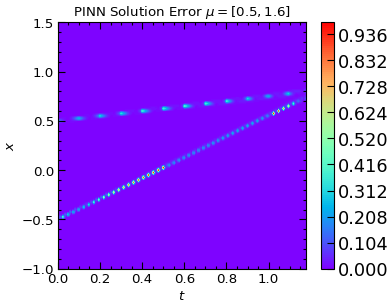

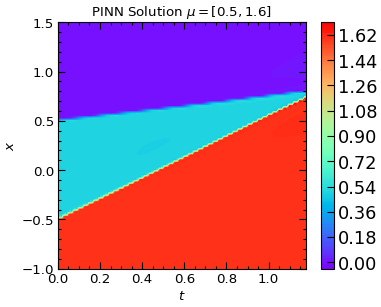

Epoch: 15200 | loss: 0.0004164305282756686,rMAE: 0.005142673384398222, rRMSE:0.02842744253575802,loss_RH:0.00000000,loss_con:2.54899287,loss_R:0.0003297724178992212,loss_IC:2.6874015475186752e-06,loss_BC:5.978407898510341e-06
Epoch: 15400 | loss: 0.00030403814162127674,rMAE: 0.004685550928115845, rRMSE:0.028387973085045815,loss_RH:0.00000000,loss_con:2.55987310,loss_R:0.00029784615617245436,loss_IC:5.757409553552861e-07,loss_BC:4.3456914511352807e-08
Epoch: 15600 | loss: 0.0002839064982254058,rMAE: 0.004537040833383799, rRMSE:0.02795591577887535,loss_RH:0.00000000,loss_con:2.55998635,loss_R:0.0002781809598673135,loss_IC:5.305287231749389e-07,loss_BC:4.202538761433061e-08
Epoch: 15800 | loss: 0.00026595150120556355,rMAE: 0.004534559790045023, rRMSE:0.028814973309636116,loss_RH:0.00000000,loss_con:2.55959153,loss_R:0.00026062800316140056,loss_IC:4.852137749367103e-07,loss_BC:4.713519530241683e-08
Epoch: 16000 | loss: 0.0010792992543429136,rMAE: 0.007338656112551689, rRMSE:0.0276015400886

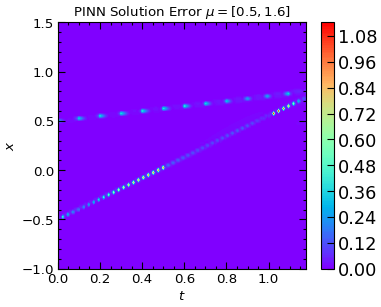

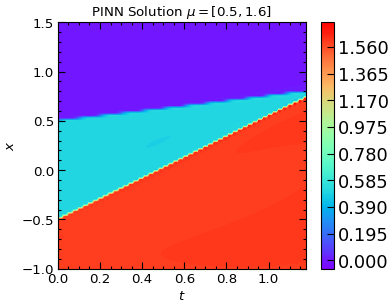

Epoch: 16200 | loss: 0.0004459029296413064,rMAE: 0.00418433453887701, rRMSE:0.028347663581371307,loss_RH:0.00000000,loss_con:2.57790303,loss_R:0.0002319279155926779,loss_IC:5.509311904461356e-06,loss_BC:1.588819213793613e-05
Epoch: 16400 | loss: 0.00021527701755985618,rMAE: 0.004123948980122805, rRMSE:0.02828856371343136,loss_RH:0.00000000,loss_con:2.56014705,loss_R:0.00021208122780080885,loss_IC:2.9205932605691487e-07,loss_BC:2.7519714507207027e-08
Epoch: 16600 | loss: 0.00020291116379667073,rMAE: 0.004032489378005266, rRMSE:0.028235524892807007,loss_RH:0.00000000,loss_con:2.55992866,loss_R:0.00019979574426542968,loss_IC:2.893894475164416e-07,loss_BC:2.215194783161678e-08
Epoch: 16800 | loss: 0.00024101388407871127,rMAE: 0.004486052319407463, rRMSE:0.03092765063047409,loss_RH:0.00000000,loss_con:2.55998015,loss_R:0.0002320438070455566,loss_IC:8.515877425452345e-07,loss_BC:4.5420343042223976e-08
Epoch: 17000 | loss: 0.0001785026106517762,rMAE: 0.003809945657849312, rRMSE:0.027874248102

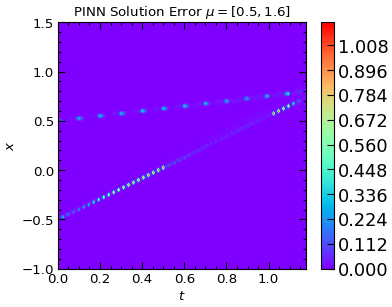

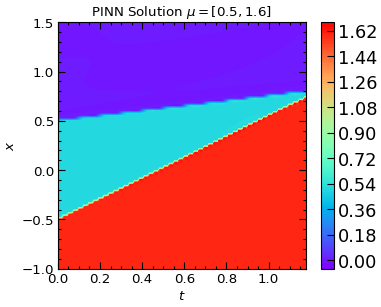

Epoch: 17200 | loss: 0.0008779011550359428,rMAE: 0.009027904830873013, rRMSE:0.04880023002624512,loss_RH:0.00000000,loss_con:2.56805015,loss_R:0.0002509067999199033,loss_IC:5.617073111352511e-05,loss_BC:6.528704489028314e-06
Epoch: 17400 | loss: 0.00021079495490994304,rMAE: 0.0069540501572191715, rRMSE:0.05010661110281944,loss_RH:0.00000000,loss_con:2.56003094,loss_R:0.00019819587760139257,loss_IC:1.159586759058584e-06,loss_BC:1.0032039199359133e-07
Epoch: 17600 | loss: 0.00019470498955342919,rMAE: 0.006617784034460783, rRMSE:0.050697360187768936,loss_RH:0.00000000,loss_con:2.55985928,loss_R:0.00018769533198792487,loss_IC:6.04831654982263e-07,loss_BC:9.61340944627409e-08
Epoch: 17800 | loss: 0.0001883011864265427,rMAE: 0.006474899593740702, rRMSE:0.05086955055594444,loss_RH:0.00000000,loss_con:2.55980134,loss_R:0.00018316763453185558,loss_IC:4.326748239691369e-07,loss_BC:8.067983969795023e-08
Epoch: 18000 | loss: 0.0001832938432926312,rMAE: 0.0063843196257948875, rRMSE:0.05089684203267

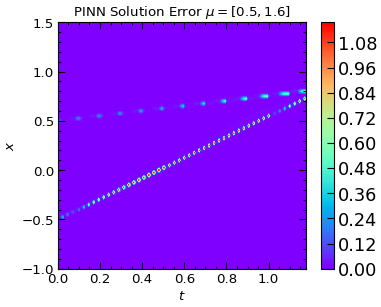

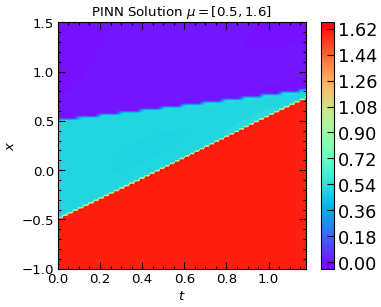

Epoch: 18200 | loss: 0.00018068254576064646,rMAE: 0.006570880766957998, rRMSE:0.0506029948592186,loss_RH:0.00000000,loss_con:2.55857325,loss_R:0.00017615797696635127,loss_IC:3.1063052574609173e-07,loss_BC:1.4182636220994027e-07
Epoch: 18400 | loss: 0.0007577968062832952,rMAE: 0.010482534766197205, rRMSE:0.05069918930530548,loss_RH:0.00000000,loss_con:2.52999902,loss_R:0.00018810140318237245,loss_IC:1.1992246072622947e-05,loss_BC:4.497729241847992e-05
Epoch: 18600 | loss: 0.00016713366494514048,rMAE: 0.006116904318332672, rRMSE:0.05065889656543732,loss_RH:0.00000000,loss_con:2.55975866,loss_R:0.00016474496806040406,loss_IC:2.0263875910586648e-07,loss_BC:3.623021882503963e-08
Epoch: 18800 | loss: 0.00016294878150802106,rMAE: 0.0060609192587435246, rRMSE:0.050645750015974045,loss_RH:0.00000000,loss_con:2.55985355,loss_R:0.00016086599498521537,loss_IC:1.8176818628035107e-07,loss_BC:2.6510083017683428e-08
Epoch: 19000 | loss: 0.0001650492922635749,rMAE: 0.006272844970226288, rRMSE:0.0506489

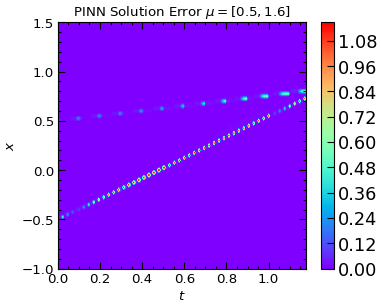

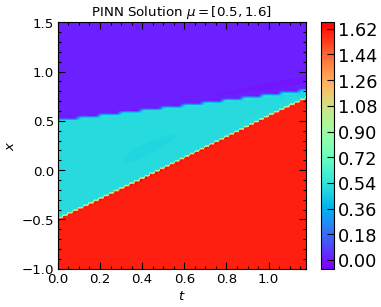

Epoch: 19200 | loss: 0.000167005680850707,rMAE: 0.006025657989084721, rRMSE:0.050632674247026443,loss_RH:0.00000000,loss_con:2.56421542,loss_R:0.00015352816262748092,loss_IC:4.3083795731035934e-07,loss_BC:9.169133363684523e-07
Epoch: 19400 | loss: 0.00017469850718043745,rMAE: 0.007184521295130253, rRMSE:0.05074084922671318,loss_RH:0.00000000,loss_con:2.56588697,loss_R:0.0001503687526565045,loss_IC:6.637804972342565e-07,loss_BC:1.7691945686237887e-06
Epoch: 19600 | loss: 0.00014742789790034294,rMAE: 0.005892795976251364, rRMSE:0.050529785454273224,loss_RH:0.00000000,loss_con:2.55967784,loss_R:0.00014582558651454747,loss_IC:1.418905242189794e-07,loss_BC:1.834128582345329e-08
Epoch: 19800 | loss: 0.00014414962788578123,rMAE: 0.005337349139153957, rRMSE:0.04851808026432991,loss_RH:0.00000000,loss_con:2.56006217,loss_R:0.0001427715178579092,loss_IC:1.2590966491643485e-07,loss_BC:1.190072662637931e-08
Epoch: 20000 | loss: 0.00013709587801713496,rMAE: 0.005288122687488794, rRMSE:0.04852816089

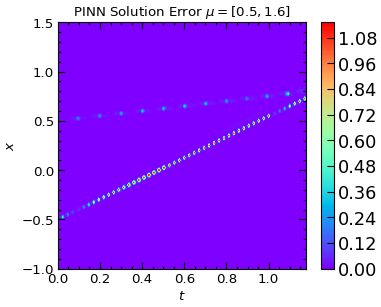

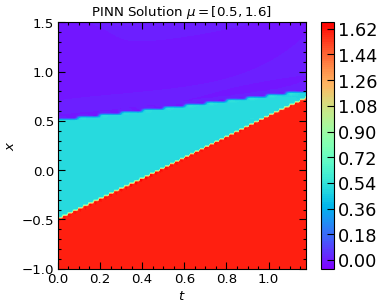

PINN Training Completed

PINN Training Time: 0.4759417710768887 Hours


In [122]:
print("******************************************************************")
########################### Full PINN Training ############################    
residual_data1 = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid1      = residual_data1[0].to(device)
f_hat1         = residual_data1[1].to(device)
xt_test1       = residual_data1[2].to(device)
xt_RHL1      = residual_data1[3].to(device)
xt_RHR1      = residual_data1[4].to(device)
xt_RHt1         = residual_data1[5].to(device)
xt_RHtL1       = residual_data1[6].to(device)
ind = torch.logical_and(xt_resid1[:,0]>-1,xt_resid1[:,0]<1)

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

IC_data1 = create_IC_data(nu_pinn_train,Xi, Xf, Ti, Tf, IC_pts, IC_simple)
IC_xt1     = IC_data1[0].to(device)
IC_u1      = IC_data1[1].to(device)
#plt.scatter(IC_xt[:,1].detach().cpu(),IC_xt[:,0].detach().cpu(),s=0.1)
xt_en = Move_Time_1D(IC_xt1, Tf).to(device)

Exact_y1 = exact_u(nu_pinn_train,xt_test1)[:,None].to(device)
###   IFNN2 training   ####
pinn_train_time_1 = time.perf_counter()

PINN1 = NN1(nu_pinn_train, layers_pinn,dt).to(device)
    
pinn1_losses = pinn1_train(PINN1, nu_pinn_train, xt_resid1, IC_xt1, IC_u1, BC1, BC2, xt_RHL1,xt_RHR1,xt_RHt1,xt_RHtL1, f_hat1, Exact_y1, epochs_pinn1, lr_pinn1, tol_pinn1, xt_test1)

pinn_train_time_2 = time.perf_counter()
print(f"PINN Training Time: {(pinn_train_time_2-pinn_train_time_1)/3600} Hours")


******************************************************************
Epoch: 200 | loss: 0.6515458822250366,rMAE: 0.3770354092121124, rRMSE:0.4233344495296478,loss_RH:0.00000000,loss_con:2.56866074,loss_R:0.10198652744293213,loss_IC:0.0538332536816597,loss_BC:0.001122678630053997
Epoch: 400 | loss: 0.5386091470718384,rMAE: 0.3279465138912201, rRMSE:0.3475779891014099,loss_RH:0.00000000,loss_con:2.62418842,loss_R:0.08960262686014175,loss_IC:0.04419657215476036,loss_BC:0.0007040800992399454
Epoch: 600 | loss: 0.2656116485595703,rMAE: 0.22689323127269745, rRMSE:0.2394246906042099,loss_RH:0.00000000,loss_con:2.59233427,loss_R:0.05436154082417488,loss_IC:0.020381351932883263,loss_BC:0.0007436581654474139
Epoch: 800 | loss: 0.16779953241348267,rMAE: 0.19792193174362183, rRMSE:0.21188884973526,loss_RH:0.00000000,loss_con:2.54478335,loss_R:0.04494711011648178,loss_IC:0.012134659104049206,loss_BC:0.00015058369899634272
Epoch: 1000 | loss: 0.1502472460269928,rMAE: 0.16566389799118042, rRMSE:0.18903

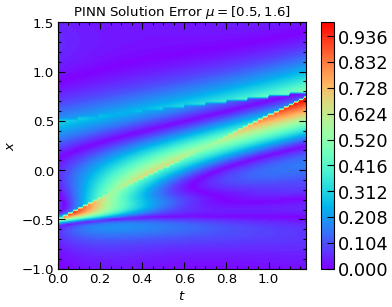

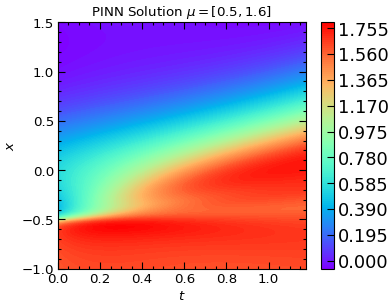

Epoch: 1200 | loss: 0.11411040276288986,rMAE: 0.13420473039150238, rRMSE:0.16997230052947998,loss_RH:0.00000000,loss_con:2.56264329,loss_R:0.02802681364119053,loss_IC:0.008561469614505768,loss_BC:4.6889537770766765e-05
Epoch: 1400 | loss: 0.09192769974470139,rMAE: 0.11622532457113266, rRMSE:0.15406174957752228,loss_RH:0.00000000,loss_con:2.55817389,loss_R:0.022886814549565315,loss_IC:0.006856687366962433,loss_BC:4.7401394112966955e-05
Epoch: 1600 | loss: 0.07561510056257248,rMAE: 0.10636871308088303, rRMSE:0.1420210301876068,loss_RH:0.00000000,loss_con:2.55530286,loss_R:0.019663643091917038,loss_IC:0.005540187004953623,loss_BC:5.495881487149745e-05
Epoch: 1800 | loss: 0.06371313333511353,rMAE: 0.09630897641181946, rRMSE:0.1310058981180191,loss_RH:0.00000000,loss_con:2.55344081,loss_R:0.01716783456504345,loss_IC:0.004596690647304058,loss_BC:5.7838748034555465e-05
Epoch: 2000 | loss: 0.07061731815338135,rMAE: 0.09080558270215988, rRMSE:0.12172532826662064,loss_RH:0.00000000,loss_con:2.40

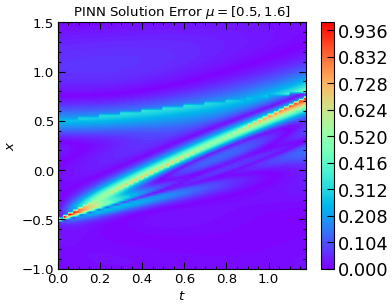

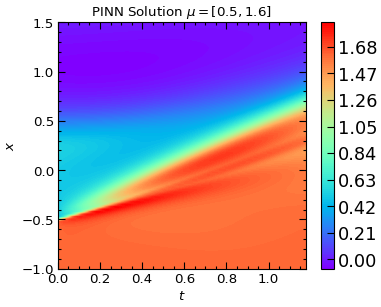

Epoch: 2200 | loss: 0.048443835228681564,rMAE: 0.07919761538505554, rRMSE:0.11213208734989166,loss_RH:0.00000000,loss_con:2.54930425,loss_R:0.013279234059154987,loss_IC:0.0034597357735037804,loss_BC:5.6724307796685025e-05
Epoch: 2400 | loss: 0.04319705069065094,rMAE: 0.07349839061498642, rRMSE:0.1055692583322525,loss_RH:0.00000000,loss_con:2.54679608,loss_R:0.011919895187020302,loss_IC:0.0030761929228901863,loss_BC:5.152265293872915e-05
Epoch: 2600 | loss: 0.04142717644572258,rMAE: 0.06693095713853836, rRMSE:0.10002073645591736,loss_RH:0.00000000,loss_con:2.61722946,loss_R:0.010973394848406315,loss_IC:0.002855919534340501,loss_BC:0.0001894587476272136
Epoch: 2800 | loss: 0.03324861824512482,rMAE: 0.06555303186178207, rRMSE:0.0954136773943901,loss_RH:0.00000000,loss_con:2.53344226,loss_R:0.009855100885033607,loss_IC:0.002278785454109311,loss_BC:6.0566373576875776e-05
Epoch: 3000 | loss: 0.026973161846399307,rMAE: 0.05933495983481407, rRMSE:0.09037479758262634,loss_RH:0.00000000,loss_con

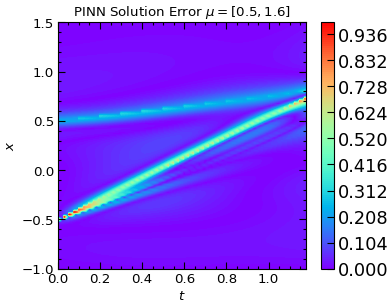

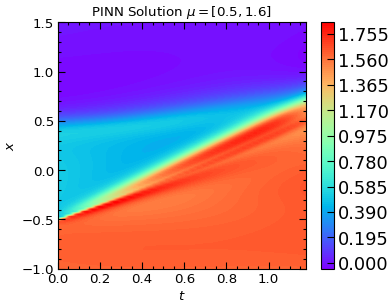

Epoch: 3200 | loss: 0.020898927003145218,rMAE: 0.052307914942502975, rRMSE:0.08533341437578201,loss_RH:0.00000000,loss_con:2.55728769,loss_R:0.007925290614366531,loss_IC:0.00128881202545017,loss_BC:8.551572136639152e-06
Epoch: 3400 | loss: 0.016802426427602768,rMAE: 0.04809365049004555, rRMSE:0.08063915371894836,loss_RH:0.00000000,loss_con:2.56066895,loss_R:0.006992721930146217,loss_IC:0.0009718290530145168,loss_BC:9.141544069279917e-06
Epoch: 3600 | loss: 0.014139175415039062,rMAE: 0.04391278326511383, rRMSE:0.07648315280675888,loss_RH:0.00000000,loss_con:2.56229281,loss_R:0.0062425704672932625,loss_IC:0.0007802490144968033,loss_BC:9.411467544850893e-06
Epoch: 3800 | loss: 0.012066207826137543,rMAE: 0.03994298726320267, rRMSE:0.07276657223701477,loss_RH:0.00000000,loss_con:2.56236911,loss_R:0.005639109760522842,loss_IC:0.0006353382486850023,loss_BC:7.371550964307971e-06
Epoch: 4000 | loss: 0.010424666106700897,rMAE: 0.036460403352975845, rRMSE:0.0695384219288826,loss_RH:0.00000000,los

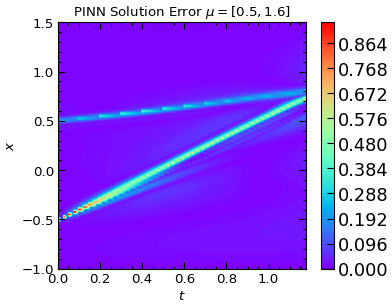

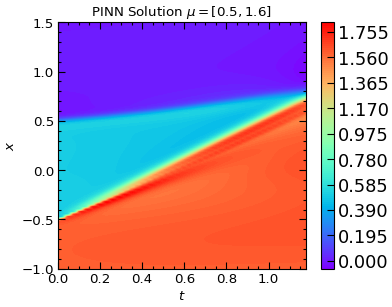

Epoch: 4200 | loss: 0.008850006386637688,rMAE: 0.033609263598918915, rRMSE:0.06672745198011398,loss_RH:0.00000000,loss_con:2.56023240,loss_R:0.0046518039889633656,loss_IC:0.00041646850877441466,loss_BC:3.351686700625578e-06
Epoch: 4400 | loss: 0.007569765206426382,rMAE: 0.03110739216208458, rRMSE:0.06420869380235672,loss_RH:0.00000000,loss_con:2.56006336,loss_R:0.004222620278596878,loss_IC:0.00033229149994440377,loss_BC:2.422968918835977e-06
Epoch: 4600 | loss: 0.006483849138021469,rMAE: 0.028983980417251587, rRMSE:0.06182470545172691,loss_RH:0.00000000,loss_con:2.55968165,loss_R:0.0038752576801925898,loss_IC:0.0002589714131318033,loss_BC:1.8877674392570043e-06
Epoch: 4800 | loss: 0.008064648136496544,rMAE: 0.026758115738630295, rRMSE:0.059636034071445465,loss_RH:0.00000000,loss_con:2.62411618,loss_R:0.0036216198932379484,loss_IC:0.0002444312267471105,loss_BC:0.00019987164705526084
Epoch: 5000 | loss: 0.004640653263777494,rMAE: 0.025012966245412827, rRMSE:0.05755944550037384,loss_RH:0.

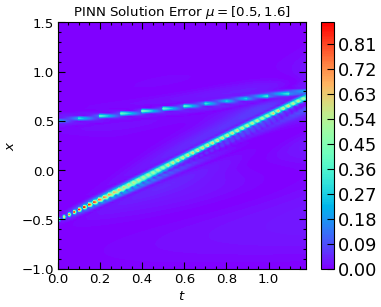

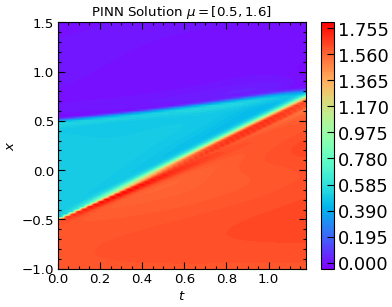

Epoch: 5200 | loss: 0.0039018411189317703,rMAE: 0.023253437131643295, rRMSE:0.05572088435292244,loss_RH:0.00000000,loss_con:2.55951953,loss_R:0.002910197013989091,loss_IC:9.800879342947155e-05,loss_BC:1.155633185589977e-06
Epoch: 5400 | loss: 0.0035630404017865658,rMAE: 0.021401993930339813, rRMSE:0.053578801453113556,loss_RH:0.00000000,loss_con:2.58047819,loss_R:0.0026356354355812073,loss_IC:7.114374602679163e-05,loss_BC:2.1596737497020513e-05
Epoch: 5600 | loss: 0.002785507822409272,rMAE: 0.0201960988342762, rRMSE:0.051499977707862854,loss_RH:0.00000000,loss_con:2.55960608,loss_R:0.0023427538108080626,loss_IC:4.329074363340624e-05,loss_BC:9.84648409030342e-07
Epoch: 5800 | loss: 0.0023948487360030413,rMAE: 0.018784917891025543, rRMSE:0.04910949990153313,loss_RH:0.00000000,loss_con:2.55914950,loss_R:0.0020966429729014635,loss_IC:2.8781601940863766e-05,loss_BC:1.0389790077169891e-06
Epoch: 6000 | loss: 0.002088588196784258,rMAE: 0.017355021089315414, rRMSE:0.045968007296323776,loss_RH:

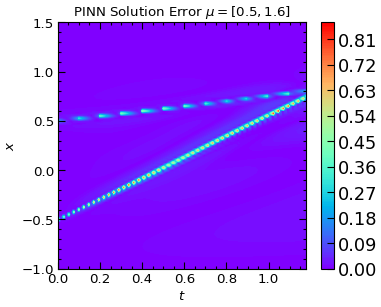

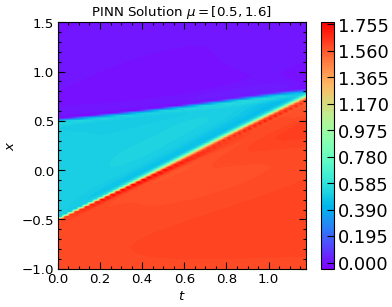

Epoch: 6200 | loss: 0.0017990737687796354,rMAE: 0.01644662767648697, rRMSE:0.042522795498371124,loss_RH:0.00000000,loss_con:2.55908990,loss_R:0.0016504543600603938,loss_IC:1.3909936569689307e-05,loss_BC:9.520075536784134e-07
Epoch: 6400 | loss: 0.0015768838347867131,rMAE: 0.015385274775326252, rRMSE:0.03951890394091606,loss_RH:0.00000000,loss_con:2.55955267,loss_R:0.0014656595885753632,loss_IC:1.019268347590696e-05,loss_BC:9.297406222685822e-07
Epoch: 6600 | loss: 0.0013011693954467773,rMAE: 0.014651017263531685, rRMSE:0.03877519071102142,loss_RH:0.00000000,loss_con:2.55972648,loss_R:0.0012144254287704825,loss_IC:7.801336323609576e-06,loss_BC:8.730648914934136e-07
Epoch: 6800 | loss: 0.0011173177044838667,rMAE: 0.014066966250538826, rRMSE:0.03795470669865608,loss_RH:0.00000000,loss_con:2.55847669,loss_R:0.001040804316289723,loss_IC:6.727905656589428e-06,loss_BC:9.234289564119535e-07
Epoch: 7000 | loss: 0.0009752323385328054,rMAE: 0.013719635084271431, rRMSE:0.03777383267879486,loss_RH:

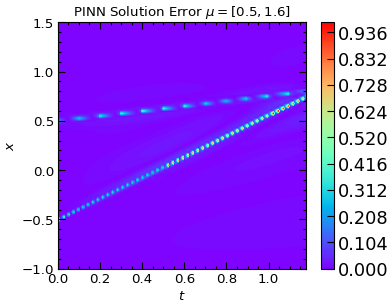

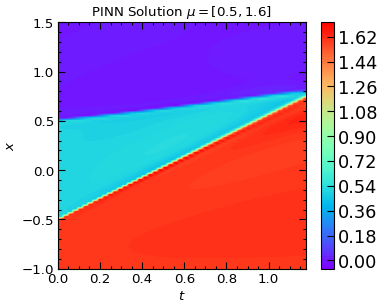

Epoch: 7200 | loss: 0.0008724882500246167,rMAE: 0.0131539860740304, rRMSE:0.037395209074020386,loss_RH:0.00000000,loss_con:2.55951571,loss_R:0.0008118470432236791,loss_IC:5.400391273724381e-06,loss_BC:6.637320097979682e-07
Epoch: 7400 | loss: 0.0007874728762544692,rMAE: 0.012698519043624401, rRMSE:0.037654709070920944,loss_RH:0.00000000,loss_con:2.56186008,loss_R:0.0007311096414923668,loss_IC:4.85507189296186e-06,loss_BC:7.812531066520023e-07
Epoch: 7600 | loss: 0.013835042715072632,rMAE: 0.02069007232785225, rRMSE:0.03917788714170456,loss_RH:0.00000000,loss_con:2.41874957,loss_R:0.0009699768852442503,loss_IC:0.00028250645846128464,loss_BC:0.0010040000779554248
Epoch: 7800 | loss: 0.0006326588918454945,rMAE: 0.011838860809803009, rRMSE:0.03753012418746948,loss_RH:0.00000000,loss_con:2.55960250,loss_R:0.00059026904636994,loss_IC:3.748197741515469e-06,loss_BC:4.907863626613107e-07
Epoch: 8000 | loss: 0.0005918329115957022,rMAE: 0.011313704773783684, rRMSE:0.03787870705127716,loss_RH:0.00

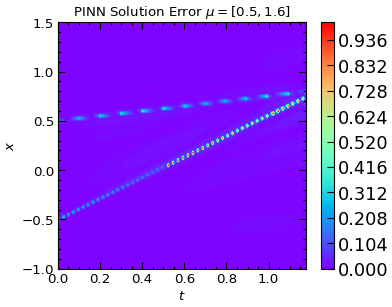

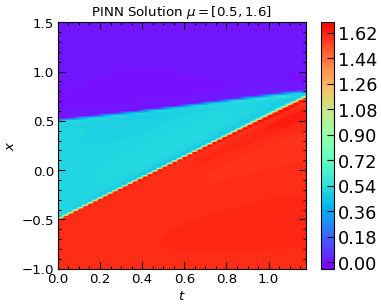

Epoch: 8159 | Loss: 0.0004996491479687393 ,rMAE: 0.01104815024882555, rRMSE:0.03850414231419563(Stopping Criteria Met)
PINN Training Time: 0.1770232426606688 Hours


In [92]:
print("******************************************************************")
########################### Full PINN Training ############################    
residual_data1 = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid1      = residual_data1[0].to(device)
f_hat1         = residual_data1[1].to(device)
xt_test1       = residual_data1[2].to(device)
xt_RHL1      = residual_data1[3].to(device)
xt_RHR1      = residual_data1[4].to(device)
xt_RHt1         = residual_data1[5].to(device)
xt_RHtL1       = residual_data1[6].to(device)
ind = torch.logical_and(xt_resid1[:,0]>-1,xt_resid1[:,0]<1)

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

IC_data1 = create_IC_data(nu_pinn_train,Xi, Xf, Ti, Tf, IC_pts, IC_simple)
IC_xt1     = IC_data1[0].to(device)
IC_u1      = IC_data1[1].to(device)
#plt.scatter(IC_xt[:,1].detach().cpu(),IC_xt[:,0].detach().cpu(),s=0.1)
xt_en = Move_Time_1D(IC_xt1, Tf).to(device)

Exact_y1 = exact_u(nu_pinn_train,xt_test1)[:,None].to(device)
###   IFNN2 training   ####
pinn_train_time_1 = time.perf_counter()

PINN1 = NN1(nu_pinn_train, layers_pinn,dt).to(device)
    
pinn1_losses = pinn1_train(PINN1, nu_pinn_train, xt_resid1, IC_xt1, IC_u1, BC1, BC2, xt_RHL1,xt_RHR1,xt_RHt1,xt_RHtL1, f_hat1, Exact_y1, epochs_pinn1, lr_pinn1, tol_pinn1, xt_test1)

pinn_train_time_2 = time.perf_counter()
print(f"PINN Training Time: {(pinn_train_time_2-pinn_train_time_1)/3600} Hours")


Epoch: 200 | loss: 1.671321988105774,rMAE: 0.34121277928352356, rRMSE:0.3657781481742859,loss_RH:0.00000000,loss_con:2.39358830,loss_R:0.2572918236255646,loss_IC:0.13572250306606293,loss_BC:0.005680520087480545
Epoch: 400 | loss: 1.2007107734680176,rMAE: 0.3439808487892151, rRMSE:0.3742448091506958,loss_RH:0.00000000,loss_con:2.50493217,loss_R:0.26606354117393494,loss_IC:0.09172549843788147,loss_BC:0.001739215455017984
Epoch: 600 | loss: 1.1716609001159668,rMAE: 0.34026038646698, rRMSE:0.3712683320045471,loss_RH:0.00000000,loss_con:2.53233171,loss_R:0.26178857684135437,loss_IC:0.08968214690685272,loss_BC:0.0013050863053649664
Epoch: 800 | loss: 1.1490483283996582,rMAE: 0.3351857364177704, rRMSE:0.3661836087703705,loss_RH:0.00000000,loss_con:2.54651260,loss_R:0.2548936605453491,loss_IC:0.08815997838973999,loss_BC:0.0012554896529763937
Epoch: 1000 | loss: 1.1234434843063354,rMAE: 0.3294699788093567, rRMSE:0.36054301261901855,loss_RH:0.00000000,loss_con:2.55748367,loss_R:0.247440218925476

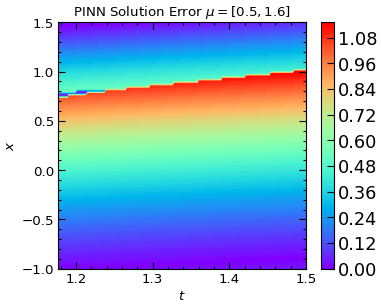

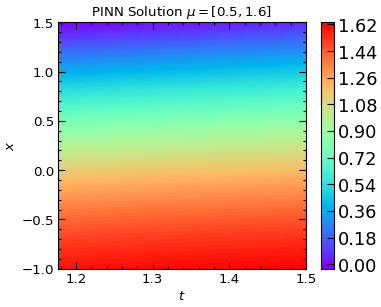

Epoch: 1200 | loss: 1.088914155960083,rMAE: 0.3217453956604004, rRMSE:0.35340315103530884,loss_RH:0.00000000,loss_con:2.56717706,loss_R:0.23800893127918243,loss_IC:0.08387110382318497,loss_BC:0.0012194172013550997
Epoch: 1400 | loss: 1.0300570726394653,rMAE: 0.30810409784317017, rRMSE:0.341659814119339,loss_RH:0.00000000,loss_con:2.57469130,loss_R:0.22266940772533417,loss_IC:0.07956817746162415,loss_BC:0.0011705885408446193
Epoch: 1600 | loss: 0.9093068242073059,rMAE: 0.2762887179851532, rRMSE:0.3151671588420868,loss_RH:0.00000000,loss_con:2.57383895,loss_R:0.18950150907039642,loss_IC:0.07097052782773972,loss_BC:0.001010001520626247
Epoch: 1800 | loss: 0.7180477380752563,rMAE: 0.21703088283538818, rRMSE:0.2681080102920532,loss_RH:0.00000000,loss_con:2.57468891,loss_R:0.13723310828208923,loss_IC:0.05723294988274574,loss_BC:0.0008485145517624915
Epoch: 2000 | loss: 0.5690057277679443,rMAE: 0.17552946507930756, rRMSE:0.22665905952453613,loss_RH:0.00000000,loss_con:2.58204484,loss_R:0.0982

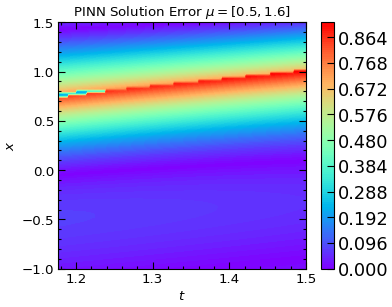

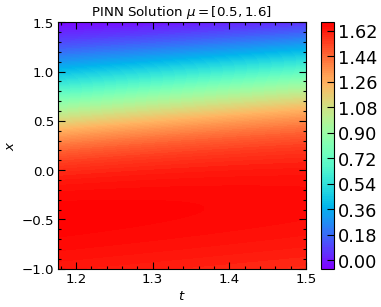

Epoch: 2200 | loss: 0.5171607732772827,rMAE: 0.16981959342956543, rRMSE:0.21222606301307678,loss_RH:0.00000000,loss_con:2.57795453,loss_R:0.08607185631990433,loss_IC:0.04195722937583923,loss_BC:0.0011516609229147434
Epoch: 2400 | loss: 0.48904240131378174,rMAE: 0.1664285808801651, rRMSE:0.20692075788974762,loss_RH:0.00000000,loss_con:2.56746864,loss_R:0.08147389441728592,loss_IC:0.03975531458854675,loss_BC:0.0010015357984229922
Epoch: 2600 | loss: 0.4598478674888611,rMAE: 0.16007235646247864, rRMSE:0.20125651359558105,loss_RH:0.00000000,loss_con:2.55888104,loss_R:0.07653175294399261,loss_IC:0.037633784115314484,loss_BC:0.0006978273158892989
Epoch: 2800 | loss: 0.4250517189502716,rMAE: 0.15106654167175293, rRMSE:0.19344188272953033,loss_RH:0.00000000,loss_con:2.55474377,loss_R:0.07025273889303207,loss_IC:0.0351112000644207,loss_BC:0.00036869425093755126
Epoch: 3000 | loss: 0.3836131989955902,rMAE: 0.13996367156505585, rRMSE:0.18336422741413116,loss_RH:0.00000000,loss_con:2.55449414,loss

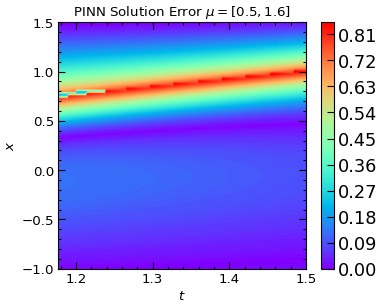

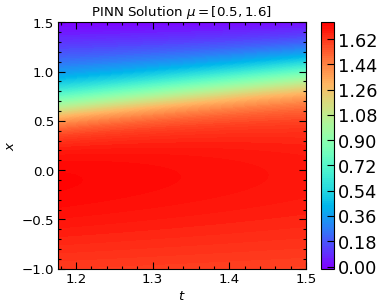

Epoch: 3200 | loss: 0.3386298418045044,rMAE: 0.12801599502563477, rRMSE:0.17177994549274445,loss_RH:0.00000000,loss_con:2.55480719,loss_R:0.05429733917117119,loss_IC:0.028405098244547844,loss_BC:2.8152189770480618e-05
Epoch: 3400 | loss: 0.29463595151901245,rMAE: 0.11586037278175354, rRMSE:0.15946635603904724,loss_RH:0.00000000,loss_con:2.55378556,loss_R:0.046006396412849426,loss_IC:0.02481735497713089,loss_BC:4.560087836580351e-05
Epoch: 3600 | loss: 0.2548557221889496,rMAE: 0.10318213701248169, rRMSE:0.14700154960155487,loss_RH:0.00000000,loss_con:2.55214334,loss_R:0.03825979307293892,loss_IC:0.02154328115284443,loss_BC:0.00011631041707005352
Epoch: 3800 | loss: 0.22119952738285065,rMAE: 0.09040717035531998, rRMSE:0.1352316439151764,loss_RH:0.00000000,loss_con:2.55151033,loss_R:0.03162558376789093,loss_IC:0.018804458901286125,loss_BC:0.0001529367727926001
Epoch: 4000 | loss: 0.19498291611671448,rMAE: 0.07938190549612045, rRMSE:0.12506595253944397,loss_RH:0.00000000,loss_con:2.5521988

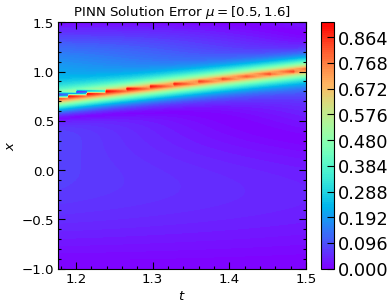

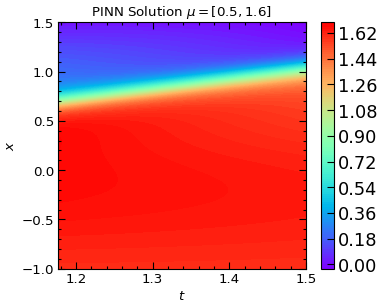

Epoch: 4200 | loss: 0.1762496680021286,rMAE: 0.07102668285369873, rRMSE:0.11661642044782639,loss_RH:0.00000000,loss_con:2.55349898,loss_R:0.022444264963269234,loss_IC:0.015259949490427971,loss_BC:0.00012059083383064717
Epoch: 4400 | loss: 0.16354958713054657,rMAE: 0.06437970697879791, rRMSE:0.10978879779577255,loss_RH:0.00000000,loss_con:2.55547857,loss_R:0.019423911347985268,loss_IC:0.014318263158202171,loss_BC:9.430419595446438e-05
Epoch: 4600 | loss: 0.15515825152397156,rMAE: 0.058545708656311035, rRMSE:0.10412310808897018,loss_RH:0.00000000,loss_con:2.55767703,loss_R:0.017106343060731888,loss_IC:0.013733919709920883,loss_BC:7.127173012122512e-05
Epoch: 4800 | loss: 0.1493111550807953,rMAE: 0.05364862084388733, rRMSE:0.09954612702131271,loss_RH:0.00000000,loss_con:2.55971694,loss_R:0.015243749134242535,loss_IC:0.013351919129490852,loss_BC:5.482127016875893e-05
Epoch: 5000 | loss: 0.14487726986408234,rMAE: 0.04987858235836029, rRMSE:0.09593372046947479,loss_RH:0.00000000,loss_con:2.5

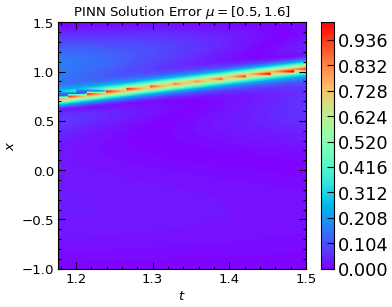

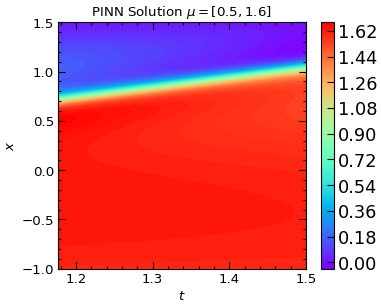

Epoch: 5200 | loss: 0.14103415608406067,rMAE: 0.047095008194446564, rRMSE:0.09310606122016907,loss_RH:0.00000000,loss_con:2.56217027,loss_R:0.012815935537219048,loss_IC:0.012778138741850853,loss_BC:4.368267400423065e-05
Epoch: 5400 | loss: 0.1372848004102707,rMAE: 0.044958148151636124, rRMSE:0.09077771008014679,loss_RH:0.00000000,loss_con:2.56254625,loss_R:0.01198948547244072,loss_IC:0.012483847327530384,loss_BC:4.568417352857068e-05
Epoch: 5600 | loss: 0.13341908156871796,rMAE: 0.04320479929447174, rRMSE:0.08876748383045197,loss_RH:0.00000000,loss_con:2.56257749,loss_R:0.0112970732152462,loss_IC:0.012163915671408176,loss_BC:4.8285332013620064e-05
Epoch: 5800 | loss: 0.12927746772766113,rMAE: 0.041658513247966766, rRMSE:0.08695144206285477,loss_RH:0.00000000,loss_con:2.56238818,loss_R:0.010625761933624744,loss_IC:0.011815492995083332,loss_BC:4.967746281181462e-05
Epoch: 6000 | loss: 0.12488886713981628,rMAE: 0.040259283035993576, rRMSE:0.08526366949081421,loss_RH:0.00000000,loss_con:2.

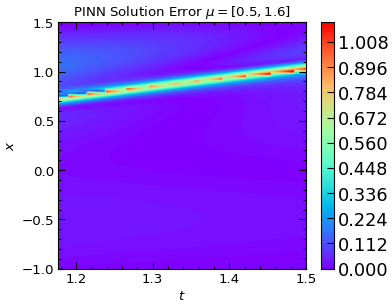

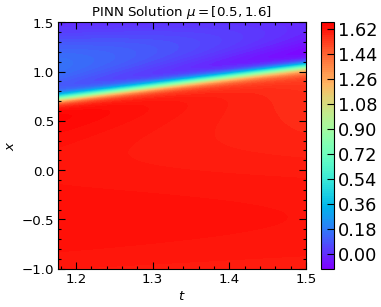

Epoch: 6200 | loss: 0.12013936787843704,rMAE: 0.038954779505729675, rRMSE:0.08366658538579941,loss_RH:0.00000000,loss_con:2.56194448,loss_R:0.009635424241423607,loss_IC:0.011005482636392117,loss_BC:4.491096842684783e-05
Epoch: 6400 | loss: 0.11472254246473312,rMAE: 0.03773012384772301, rRMSE:0.08213536441326141,loss_RH:0.00000000,loss_con:2.55968451,loss_R:0.009186116978526115,loss_IC:0.010513192974030972,loss_BC:4.044954403070733e-05
Epoch: 6600 | loss: 0.10853895545005798,rMAE: 0.03643351420760155, rRMSE:0.0806625485420227,loss_RH:0.00000000,loss_con:2.56242561,loss_R:0.008725476451218128,loss_IC:0.009944647550582886,loss_BC:3.670013029477559e-05
Epoch: 6800 | loss: 0.10151824355125427,rMAE: 0.03541770949959755, rRMSE:0.07906936854124069,loss_RH:0.00000000,loss_con:2.56221390,loss_R:0.00831938162446022,loss_IC:0.009287781082093716,loss_BC:3.210510840290226e-05
Epoch: 7000 | loss: 0.09338460862636566,rMAE: 0.03486974164843559, rRMSE:0.07733126729726791,loss_RH:0.00000000,loss_con:2.56

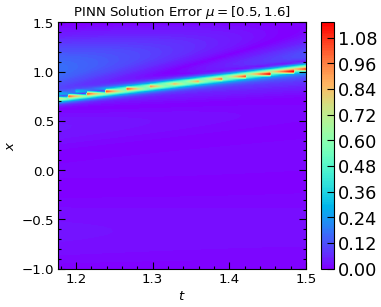

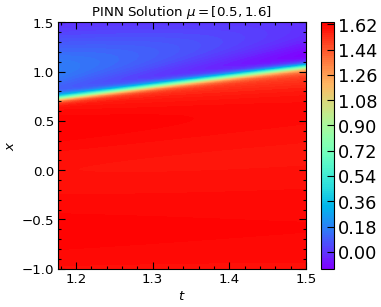

Epoch: 7200 | loss: 0.08401168882846832,rMAE: 0.03454399108886719, rRMSE:0.0753711387515068,loss_RH:0.00000000,loss_con:2.56207871,loss_R:0.007294936571270227,loss_IC:0.007650525774806738,loss_BC:2.1149140593479387e-05
Epoch: 7400 | loss: 0.07389887422323227,rMAE: 0.034566592425107956, rRMSE:0.0731162503361702,loss_RH:0.00000000,loss_con:2.55200648,loss_R:0.0067425877787172794,loss_IC:0.0066950079053640366,loss_BC:2.0620504074031487e-05
Epoch: 7600 | loss: 0.06490245461463928,rMAE: 0.03449123352766037, rRMSE:0.07098639756441116,loss_RH:0.00000000,loss_con:2.55634117,loss_R:0.006145404186099768,loss_IC:0.005859485361725092,loss_BC:1.6219442841247655e-05
Epoch: 7800 | loss: 0.05845825374126434,rMAE: 0.03353520482778549, rRMSE:0.0689740851521492,loss_RH:0.00000000,loss_con:2.56017852,loss_R:0.005557170137763023,loss_IC:0.0052780346013605595,loss_BC:1.2073536709067412e-05
Epoch: 8000 | loss: 0.053677935153245926,rMAE: 0.031523074954748154, rRMSE:0.06719142943620682,loss_RH:0.00000000,loss_

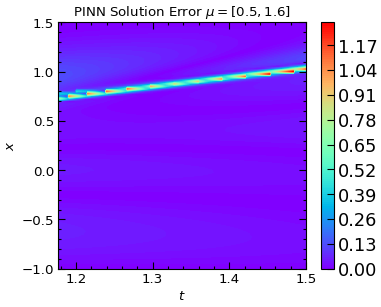

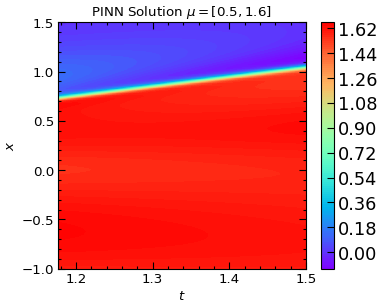

Epoch: 8200 | loss: 0.04964765906333923,rMAE: 0.029271477833390236, rRMSE:0.06579584628343582,loss_RH:0.00000000,loss_con:2.55990243,loss_R:0.004430079832673073,loss_IC:0.004516915418207645,loss_BC:4.842982434638543e-06
Epoch: 8400 | loss: 0.046157367527484894,rMAE: 0.027382565662264824, rRMSE:0.0646330863237381,loss_RH:0.00000000,loss_con:2.55966210,loss_R:0.004061883315443993,loss_IC:0.004206642042845488,loss_BC:2.9064522095723078e-06
Epoch: 8600 | loss: 0.042951200157403946,rMAE: 0.025886423885822296, rRMSE:0.06378162652254105,loss_RH:0.00000000,loss_con:2.55974483,loss_R:0.00369859067723155,loss_IC:0.003923388198018074,loss_BC:1.8727760107140057e-06
Epoch: 8800 | loss: 0.040155865252017975,rMAE: 0.024777308106422424, rRMSE:0.06301885843276978,loss_RH:0.00000000,loss_con:2.55830097,loss_R:0.0034548956900835037,loss_IC:0.003668503137305379,loss_BC:1.593679826328298e-06
Epoch: 9000 | loss: 0.03768481686711311,rMAE: 0.023954110220074654, rRMSE:0.06233601272106171,loss_RH:0.00000000,los

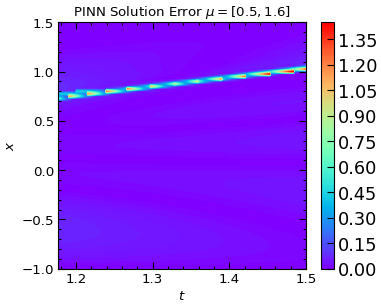

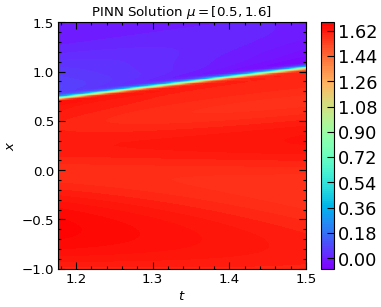

Epoch: 9200 | loss: 0.035452935844659805,rMAE: 0.023271653801202774, rRMSE:0.06146514043211937,loss_RH:0.00000000,loss_con:2.55875707,loss_R:0.003102652495726943,loss_IC:0.00323326513171196,loss_BC:1.7631584796617972e-06
Epoch: 9400 | loss: 0.03344252333045006,rMAE: 0.02276228554546833, rRMSE:0.060574036091566086,loss_RH:0.00000000,loss_con:2.55889153,loss_R:0.003003037301823497,loss_IC:0.003041813848540187,loss_BC:2.1345633740565972e-06
Epoch: 9600 | loss: 0.03144753351807594,rMAE: 0.022291149944067, rRMSE:0.05934888869524002,loss_RH:0.00000000,loss_con:2.55824137,loss_R:0.0028249777387827635,loss_IC:0.0028595151379704475,loss_BC:2.7404407774156425e-06
Epoch: 9800 | loss: 0.029576459899544716,rMAE: 0.02174520678818226, rRMSE:0.05784522369503975,loss_RH:0.00000000,loss_con:2.55807066,loss_R:0.0027394520584493876,loss_IC:0.0026803493965417147,loss_BC:3.35144659402431e-06
Epoch: 10000 | loss: 0.02766103297472,rMAE: 0.021039457991719246, rRMSE:0.05613631010055542,loss_RH:0.00000000,loss_c

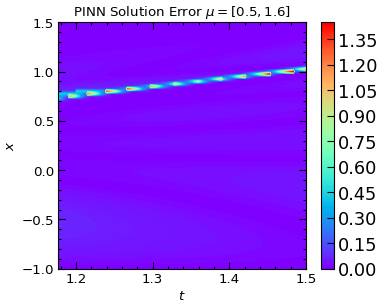

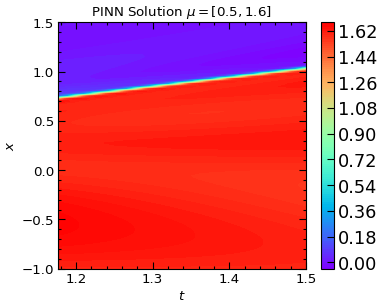

Epoch: 10200 | loss: 0.025602659210562706,rMAE: 0.02003837563097477, rRMSE:0.054030489176511765,loss_RH:0.00000000,loss_con:2.55884600,loss_R:0.0024760824162513018,loss_IC:0.002308195922523737,loss_BC:4.46178819402121e-06
Epoch: 10400 | loss: 0.02346225082874298,rMAE: 0.018682267516851425, rRMSE:0.05199897289276123,loss_RH:0.00000000,loss_con:2.55900216,loss_R:0.002335040830075741,loss_IC:0.0021077869459986687,loss_BC:4.934150638291612e-06
Epoch: 10600 | loss: 0.021223142743110657,rMAE: 0.01689908653497696, rRMSE:0.04977100342512131,loss_RH:0.00000000,loss_con:2.55931354,loss_R:0.0021856846287846565,loss_IC:0.0018987911753356457,loss_BC:4.954579708282836e-06
Epoch: 10800 | loss: 0.018991908058524132,rMAE: 0.015013729222118855, rRMSE:0.047836411744356155,loss_RH:0.00000000,loss_con:2.55954576,loss_R:0.0020195022225379944,loss_IC:0.001692730002105236,loss_BC:4.510458438744536e-06
Epoch: 11000 | loss: 0.01703321747481823,rMAE: 0.01385963149368763, rRMSE:0.04665248095989227,loss_RH:0.00000

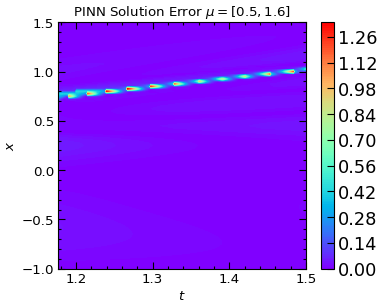

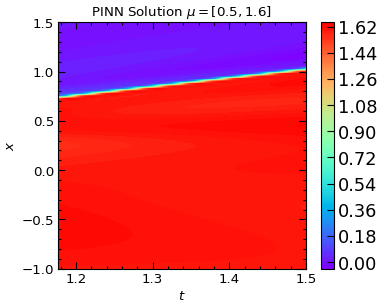

Epoch: 11200 | loss: 0.015477912500500679,rMAE: 0.013454392552375793, rRMSE:0.04489893093705177,loss_RH:0.00000000,loss_con:2.56012058,loss_R:0.0018647294491529465,loss_IC:0.0013582910178229213,loss_BC:3.027299499080982e-06
Epoch: 11400 | loss: 0.014342403039336205,rMAE: 0.013445194810628891, rRMSE:0.04331532120704651,loss_RH:0.00000000,loss_con:2.56001544,loss_R:0.001849520136602223,loss_IC:0.0012468950590118766,loss_BC:2.3932263957249233e-06
Epoch: 11600 | loss: 0.01347763929516077,rMAE: 0.013479738496243954, rRMSE:0.04168115183711052,loss_RH:0.00000000,loss_con:2.56330276,loss_R:0.0018298352370038629,loss_IC:0.0011622793972492218,loss_BC:2.500967411833699e-06
Epoch: 11800 | loss: 0.012748630717396736,rMAE: 0.01361626572906971, rRMSE:0.04107333719730377,loss_RH:0.00000000,loss_con:2.56011605,loss_R:0.0017961004050448537,loss_IC:0.0010935590835288167,loss_BC:1.6939300166995963e-06
Epoch: 12000 | loss: 0.012198034673929214,rMAE: 0.014225599355995655, rRMSE:0.043392911553382874,loss_RH:

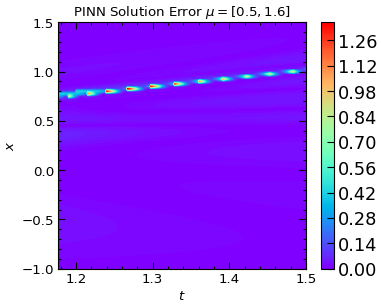

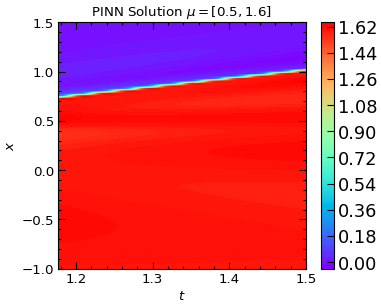

Epoch: 12200 | loss: 0.011513518169522285,rMAE: 0.014044972136616707, rRMSE:0.04282407462596893,loss_RH:0.00000000,loss_con:2.55855417,loss_R:0.001740343519486487,loss_IC:0.0009759117965586483,loss_BC:1.4056108739168849e-06
Epoch: 12400 | loss: 0.010944890789687634,rMAE: 0.014133123680949211, rRMSE:0.0431460477411747,loss_RH:0.00000000,loss_con:2.55547857,loss_R:0.0016837507719174027,loss_IC:0.0009239400969818234,loss_BC:2.1738815121352673e-06
Epoch: 12600 | loss: 0.010508180595934391,rMAE: 0.013814451172947884, rRMSE:0.04197406396269798,loss_RH:0.00000000,loss_con:2.57154250,loss_R:0.0016681442502886057,loss_IC:0.0008763964287936687,loss_BC:7.607227416883688e-06
Epoch: 12800 | loss: 0.009937435388565063,rMAE: 0.013830360025167465, rRMSE:0.041968196630477905,loss_RH:0.00000000,loss_con:2.55955076,loss_R:0.0016519419150426984,loss_IC:0.0008275455329567194,loss_BC:1.0037746278612758e-06
Epoch: 13000 | loss: 0.009446355514228344,rMAE: 0.01383928582072258, rRMSE:0.04388085752725601,loss_RH

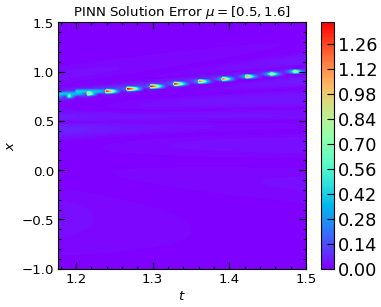

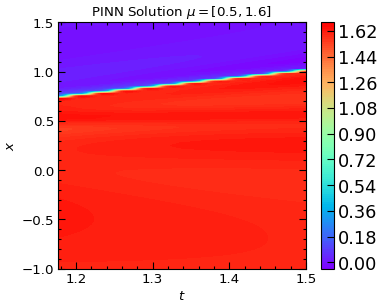

Epoch: 13200 | loss: 0.008984122425317764,rMAE: 0.013670770451426506, rRMSE:0.04431546479463577,loss_RH:0.00000000,loss_con:2.55950236,loss_R:0.0016076193423941731,loss_IC:0.0007368294754996896,loss_BC:8.208537565224105e-07
Epoch: 13400 | loss: 0.008513861335814,rMAE: 0.013433711603283882, rRMSE:0.04416460916399956,loss_RH:0.00000000,loss_con:2.55948615,loss_R:0.0015699317445978522,loss_IC:0.0006936219288036227,loss_BC:7.710447675890464e-07
Epoch: 13600 | loss: 0.008034774102270603,rMAE: 0.01326040830463171, rRMSE:0.04442471265792847,loss_RH:0.00000000,loss_con:2.55954957,loss_R:0.0015129033708944917,loss_IC:0.0006514762062579393,loss_BC:7.10879305643175e-07
Epoch: 13800 | loss: 0.007589681539684534,rMAE: 0.013093364425003529, rRMSE:0.044426798820495605,loss_RH:0.00000000,loss_con:2.55955911,loss_R:0.0014767510583624244,loss_IC:0.0006106123328208923,loss_BC:6.806513965784688e-07
Epoch: 14000 | loss: 0.007156741805374622,rMAE: 0.012944755144417286, rRMSE:0.044510699808597565,loss_RH:0.0

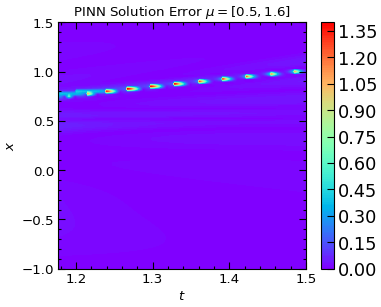

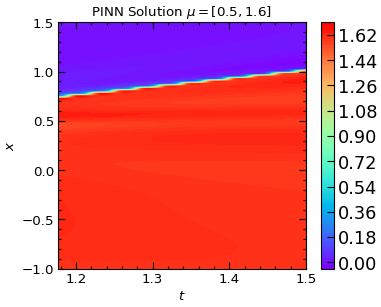

Epoch: 14200 | loss: 0.006831249222159386,rMAE: 0.012860612943768501, rRMSE:0.044975750148296356,loss_RH:0.00000000,loss_con:2.55919337,loss_R:0.0015047888737171888,loss_IC:0.0005319919437170029,loss_BC:6.540837489410478e-07
Epoch: 14400 | loss: 0.006375938653945923,rMAE: 0.013439841568470001, rRMSE:0.051274269819259644,loss_RH:0.00000000,loss_con:2.55827570,loss_R:0.0014299030881375074,loss_IC:0.0004938894999213517,loss_BC:7.141005653465982e-07
Epoch: 14600 | loss: 0.00596433924511075,rMAE: 0.01336158998310566, rRMSE:0.05147393047809601,loss_RH:0.00000000,loss_con:2.55977917,loss_R:0.001398370019160211,loss_IC:0.0004560407833196223,loss_BC:5.561560101341456e-07
Epoch: 14800 | loss: 0.005554770585149527,rMAE: 0.013386769220232964, rRMSE:0.05164370313286781,loss_RH:0.00000000,loss_con:2.55935168,loss_R:0.0013761819573119283,loss_IC:0.00041729636723175645,loss_BC:5.625215067084355e-07
Epoch: 15000 | loss: 0.0051405169069767,rMAE: 0.012736114673316479, rRMSE:0.04579620808362961,loss_RH:0.

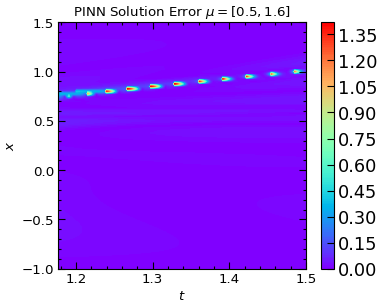

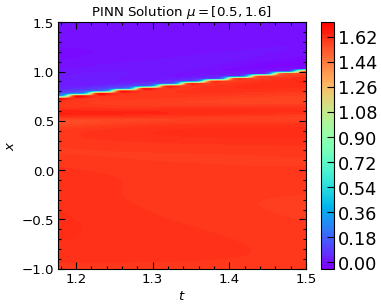

Epoch: 15200 | loss: 0.005020732991397381,rMAE: 0.01279861107468605, rRMSE:0.04671088606119156,loss_RH:0.00000000,loss_con:2.55934477,loss_R:0.001315884292125702,loss_IC:0.00036993305548094213,loss_BC:5.51808625459671e-07
Epoch: 15400 | loss: 0.004914342425763607,rMAE: 0.01274239644408226, rRMSE:0.04674703627824783,loss_RH:0.00000000,loss_con:2.55933785,loss_R:0.0013036266900599003,loss_IC:0.0003605283854994923,loss_BC:5.431874114947277e-07
Epoch: 15600 | loss: 0.004795027896761894,rMAE: 0.012676643207669258, rRMSE:0.04679377004504204,loss_RH:0.00000000,loss_con:2.55935049,loss_R:0.0012900280999019742,loss_IC:0.0003499664308037609,loss_BC:5.335748483048519e-07
Epoch: 15800 | loss: 0.004666990600526333,rMAE: 0.012603064067661762, rRMSE:0.04683632403612137,loss_RH:0.00000000,loss_con:2.55934548,loss_R:0.001275816815905273,loss_IC:0.00033858942333608866,loss_BC:5.279780452838168e-07
Epoch: 16000 | loss: 0.004532442893832922,rMAE: 0.012526057660579681, rRMSE:0.046868644654750824,loss_RH:0.

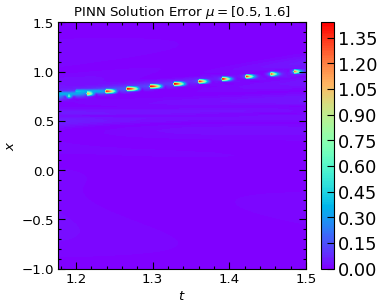

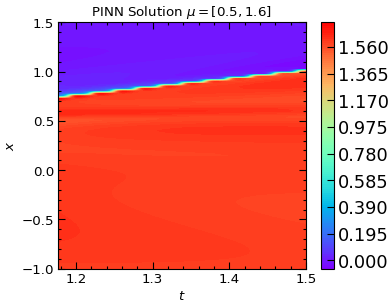

Epoch: 16200 | loss: 0.004392966628074646,rMAE: 0.01244828850030899, rRMSE:0.04688374325633049,loss_RH:0.00000000,loss_con:2.55935740,loss_R:0.0012469423236325383,loss_IC:0.0003140798071399331,loss_BC:5.226503958510875e-07
Epoch: 16400 | loss: 0.004271838814020157,rMAE: 0.012349199503660202, rRMSE:0.046560678631067276,loss_RH:0.00000000,loss_con:2.55935550,loss_R:0.001250940840691328,loss_IC:0.00030156003776937723,loss_BC:5.297745246934937e-07
Epoch: 16600 | loss: 0.004140226170420647,rMAE: 0.012337053194642067, rRMSE:0.04659244790673256,loss_RH:0.00000000,loss_con:2.55925202,loss_R:0.0012464903993532062,loss_IC:0.000288836337858811,loss_BC:5.372369287215406e-07
Epoch: 16800 | loss: 0.00400392385199666,rMAE: 0.012330260127782822, rRMSE:0.046633824706077576,loss_RH:0.00000000,loss_con:2.55762553,loss_R:0.0012327571166679263,loss_IC:0.0002763326920103282,loss_BC:7.840019407012733e-07
Epoch: 17000 | loss: 0.0038651106879115105,rMAE: 0.012255645357072353, rRMSE:0.04662519693374634,loss_RH:

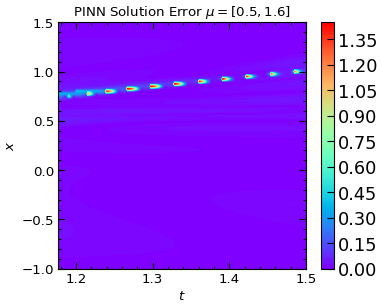

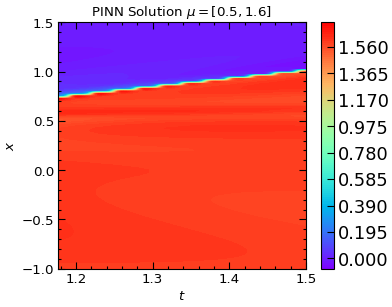

Epoch: 17200 | loss: 0.003731126431375742,rMAE: 0.01222783699631691, rRMSE:0.04666227102279663,loss_RH:0.00000000,loss_con:2.55956721,loss_R:0.0012087736977264285,loss_IC:0.0002517207176424563,loss_BC:5.145474233358982e-07
Epoch: 17400 | loss: 0.003600066527724266,rMAE: 0.012213444337248802, rRMSE:0.04668562486767769,loss_RH:0.00000000,loss_con:2.55951834,loss_R:0.0011967128375545144,loss_IC:0.00023982190759852529,loss_BC:5.134666594130977e-07
Epoch: 17600 | loss: 0.003472014795988798,rMAE: 0.012201085686683655, rRMSE:0.046714503318071365,loss_RH:0.00000000,loss_con:2.55929852,loss_R:0.001184712746180594,loss_IC:0.000228208999033086,loss_BC:5.211971370044921e-07
Epoch: 17800 | loss: 0.003347038757055998,rMAE: 0.012181147001683712, rRMSE:0.04672563821077347,loss_RH:0.00000000,loss_con:2.55927491,loss_R:0.0011730410624295473,loss_IC:0.0002168835053453222,loss_BC:5.162559091331786e-07
Epoch: 18000 | loss: 0.0032253460958600044,rMAE: 0.012152769602835178, rRMSE:0.04677247628569603,loss_RH:

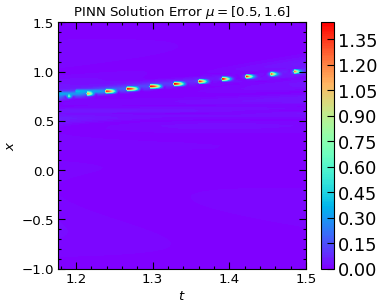

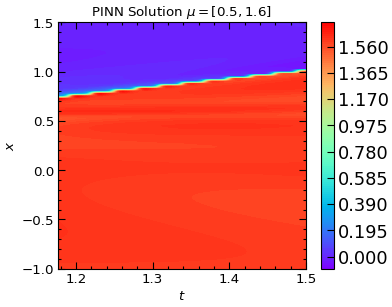

Epoch: 18200 | loss: 0.0031066839583218098,rMAE: 0.012113122269511223, rRMSE:0.04676887020468712,loss_RH:0.00000000,loss_con:2.55952525,loss_R:0.0011502341367304325,loss_IC:0.00019516158499754965,loss_BC:4.8337903990614e-07
Epoch: 18400 | loss: 0.00299184862524271,rMAE: 0.012082738801836967, rRMSE:0.04682360962033272,loss_RH:0.00000000,loss_con:2.55890799,loss_R:0.0011386893456801772,loss_IC:0.00018479595019016415,loss_BC:5.199718771109474e-07
Epoch: 18600 | loss: 0.0028802985325455666,rMAE: 0.012001308612525463, rRMSE:0.04681214690208435,loss_RH:0.00000000,loss_con:2.56044030,loss_R:0.0011281539918854833,loss_IC:0.00017475688946433365,loss_BC:4.5757440148008754e-07
Epoch: 18800 | loss: 0.002771297935396433,rMAE: 0.011977894231677055, rRMSE:0.04686731845140457,loss_RH:0.00000000,loss_con:2.55936646,loss_R:0.0011164493625983596,loss_IC:0.00016503008373547345,loss_BC:4.5477645471692085e-07
Epoch: 19000 | loss: 0.0026661246083676815,rMAE: 0.011922134086489677, rRMSE:0.04685017466545105,lo

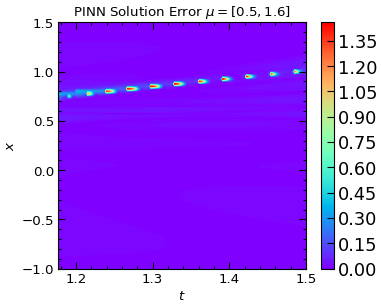

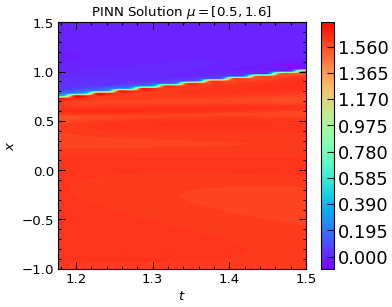

Epoch: 19200 | loss: 0.002564498223364353,rMAE: 0.011861388571560383, rRMSE:0.04688692465424538,loss_RH:0.00000000,loss_con:2.55947518,loss_R:0.0010942219523712993,loss_IC:0.00014660872693639249,loss_BC:4.1888716850735364e-07
Epoch: 19400 | loss: 0.002466570120304823,rMAE: 0.011770406737923622, rRMSE:0.04687162861227989,loss_RH:0.00000000,loss_con:2.56023312,loss_R:0.0010834059212356806,loss_IC:0.00013792449317406863,loss_BC:3.9192872236526455e-07
Epoch: 19600 | loss: 0.0023912466131150723,rMAE: 0.011700634844601154, rRMSE:0.046552255749702454,loss_RH:0.00000000,loss_con:2.55936050,loss_R:0.001088858349248767,loss_IC:0.00012983911437913775,loss_BC:3.9972971421775583e-07
Epoch: 19800 | loss: 0.002304717432707548,rMAE: 0.011581621132791042, rRMSE:0.0465378537774086,loss_RH:0.00000000,loss_con:2.56108880,loss_R:0.001079284236766398,loss_IC:0.00012212040019221604,loss_BC:4.22927143972629e-07
Epoch: 20000 | loss: 0.0022181840613484383,rMAE: 0.011561354622244835, rRMSE:0.04658149182796478,lo

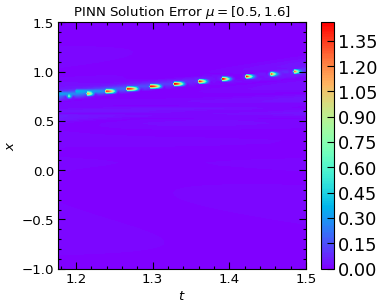

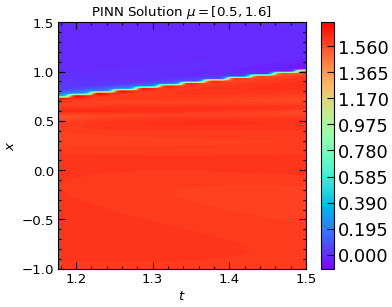

Epoch: 20200 | loss: 0.0021356530487537384,rMAE: 0.011491651646792889, rRMSE:0.04657962918281555,loss_RH:0.00000000,loss_con:2.55960727,loss_R:0.0010578351793810725,loss_IC:0.00010744111204985529,loss_BC:3.4068926879626815e-07
Epoch: 20400 | loss: 0.002055876888334751,rMAE: 0.011404192075133324, rRMSE:0.046569887548685074,loss_RH:0.00000000,loss_con:2.55964541,loss_R:0.0010471681598573923,loss_IC:0.00010054840822704136,loss_BC:3.224587317163241e-07
Epoch: 20600 | loss: 0.001978709828108549,rMAE: 0.011324441060423851, rRMSE:0.04656337946653366,loss_RH:0.00000000,loss_con:2.55927157,loss_R:0.00103623210452497,loss_IC:9.392268839292228e-05,loss_BC:3.250845850288897e-07
Epoch: 20800 | loss: 0.0019043590873479843,rMAE: 0.011217158287763596, rRMSE:0.046603381633758545,loss_RH:0.00000000,loss_con:2.55965328,loss_R:0.001025435165502131,loss_IC:8.760418859310448e-05,loss_BC:2.8820363695558626e-07
Epoch: 21000 | loss: 0.0018581408075988293,rMAE: 0.011205682530999184, rRMSE:0.04756641760468483,lo

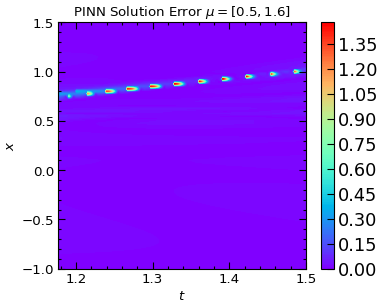

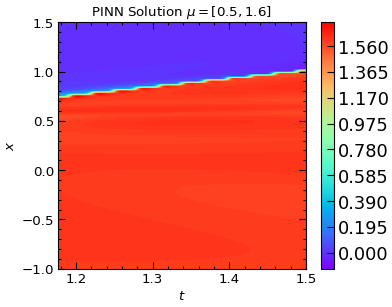

Epoch: 21200 | loss: 0.0017920288955792785,rMAE: 0.011135183274745941, rRMSE:0.047616586089134216,loss_RH:0.00000000,loss_con:2.55894279,loss_R:0.0010260411072522402,loss_IC:7.629257015651092e-05,loss_BC:3.0621208679804113e-07
Epoch: 21400 | loss: 0.0017276509897783399,rMAE: 0.011010915040969849, rRMSE:0.04766780883073807,loss_RH:0.00000000,loss_con:2.55957007,loss_R:0.0010151299647986889,loss_IC:7.100487709976733e-05,loss_BC:2.4722200464566413e-07
Epoch: 21600 | loss: 0.0016664068680256605,rMAE: 0.010913236998021603, rRMSE:0.047694575041532516,loss_RH:0.00000000,loss_con:2.55936527,loss_R:0.0010040558408945799,loss_IC:6.599065818591043e-05,loss_BC:2.4444156565550657e-07
Epoch: 21800 | loss: 0.0016082834918051958,rMAE: 0.010773669928312302, rRMSE:0.04775149002671242,loss_RH:0.00000000,loss_con:2.56089854,loss_R:0.0009933282854035497,loss_IC:6.12451258348301e-05,loss_BC:2.504016265447717e-07
Epoch: 22000 | loss: 0.0015515893464908004,rMAE: 0.010686919093132019, rRMSE:0.04774012789130211

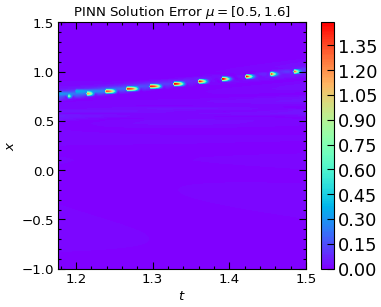

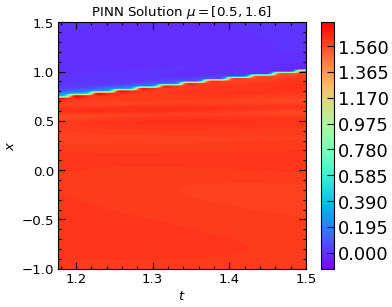

Epoch: 22200 | loss: 0.001498243073001504,rMAE: 0.010582853108644485, rRMSE:0.04781493917107582,loss_RH:0.00000000,loss_con:2.55980372,loss_R:0.0009711142629384995,loss_IC:5.2527335355989635e-05,loss_BC:1.8555147107690573e-07
Epoch: 22400 | loss: 0.0014475120697170496,rMAE: 0.010477157309651375, rRMSE:0.04784267395734787,loss_RH:0.00000000,loss_con:2.55973339,loss_R:0.0009601492783986032,loss_IC:4.856242594541982e-05,loss_BC:1.738588650823658e-07
Epoch: 22600 | loss: 0.0013995361514389515,rMAE: 0.010375012643635273, rRMSE:0.04785531014204025,loss_RH:0.00000000,loss_con:2.55950379,loss_R:0.0009492226527072489,loss_IC:4.4861477363156155e-05,loss_BC:1.6987027606774063e-07
Epoch: 22800 | loss: 0.0013539348728954792,rMAE: 0.010261686518788338, rRMSE:0.047871969640254974,loss_RH:0.00000000,loss_con:2.55977416,loss_R:0.0009384317672811449,loss_IC:4.140216333325952e-05,loss_BC:1.481470519593131e-07
Epoch: 23000 | loss: 0.001311040949076414,rMAE: 0.01016706321388483, rRMSE:0.0478907972574234,lo

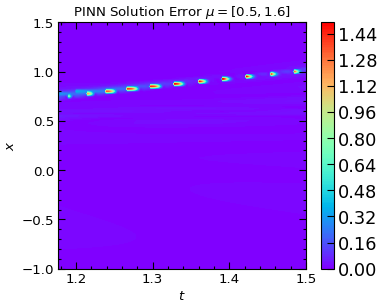

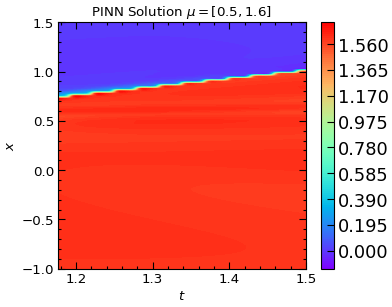

Epoch: 23200 | loss: 0.001270292908884585,rMAE: 0.010065512731671333, rRMSE:0.047937218099832535,loss_RH:0.00000000,loss_con:2.55990887,loss_R:0.0009170340490527451,loss_IC:3.520183963701129e-05,loss_BC:1.2404467497617588e-07
Epoch: 23400 | loss: 0.001231966307386756,rMAE: 0.009972368367016315, rRMSE:0.04796413704752922,loss_RH:0.00000000,loss_con:2.55980754,loss_R:0.0009064868208952248,loss_IC:3.243317041778937e-05,loss_BC:1.1477628447664756e-07
Epoch: 23600 | loss: 0.0012151440605521202,rMAE: 0.009870979003608227, rRMSE:0.048030294477939606,loss_RH:0.00000000,loss_con:2.56086564,loss_R:0.0009147104574367404,loss_IC:2.990316534123849e-05,loss_BC:1.402026299501813e-07
Epoch: 23800 | loss: 0.001182647654786706,rMAE: 0.009814524091780186, rRMSE:0.04821784421801567,loss_RH:0.00000000,loss_con:2.55981541,loss_R:0.0009051694069057703,loss_IC:2.764938835753128e-05,loss_BC:9.843559212185937e-08
Epoch: 24000 | loss: 0.0011523975990712643,rMAE: 0.009731944650411606, rRMSE:0.04826723039150238,lo

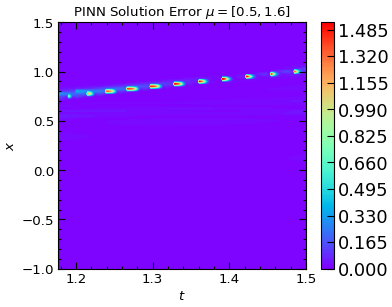

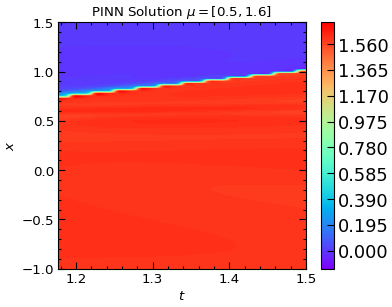

Epoch: 24200 | loss: 0.0011236381251364946,rMAE: 0.009646360762417316, rRMSE:0.048299580812454224,loss_RH:0.00000000,loss_con:2.55992770,loss_R:0.0008863224647939205,loss_IC:2.364839383517392e-05,loss_BC:8.316931854324139e-08
Epoch: 24400 | loss: 0.0010963550303131342,rMAE: 0.009562059305608273, rRMSE:0.04832528159022331,loss_RH:0.00000000,loss_con:2.55995893,loss_R:0.000876898062415421,loss_IC:2.186920028179884e-05,loss_BC:7.649002498055779e-08
Epoch: 24600 | loss: 0.0010713983792811632,rMAE: 0.00948282890021801, rRMSE:0.048343513160943985,loss_RH:0.00000000,loss_con:2.55873060,loss_R:0.0008674441487528384,loss_IC:2.0247487555025145e-05,loss_BC:1.4793482705499628e-07
Epoch: 24800 | loss: 0.001045982469804585,rMAE: 0.009393041022121906, rRMSE:0.04836370795965195,loss_RH:0.00000000,loss_con:2.55987692,loss_R:0.0008581327856518328,loss_IC:1.871974382083863e-05,loss_BC:6.522829920641016e-08
Epoch: 25000 | loss: 0.001023028395138681,rMAE: 0.00931346882134676, rRMSE:0.04840075224637985,loss

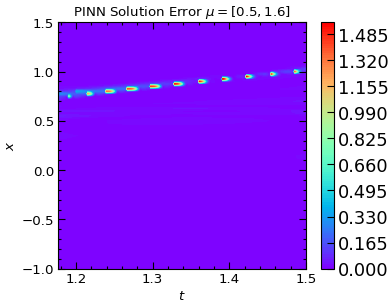

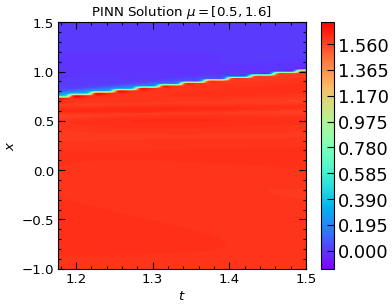

PINN Training Completed

PINN2 Training Time: 0.6315943073583508 Hours


In [126]:
residual_data2 = create_residual_data(Xi, Xf, Ti2, Tf2, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid2      = residual_data2[0].to(device)
f_hat2         = residual_data2[1].to(device)
xt_test2       = residual_data2[2].to(device)
xt_RHL2      = residual_data2[3].to(device)
xt_RHR2      = residual_data2[4].to(device)
xt_RHt2         = residual_data2[5].to(device)
xt_RHtL2       = residual_data2[6].to(device)

BC_data2 = create_BC_data(Xi, Xf, Ti2, Tf2, BC_pts)
BC_bottom2     = BC_data2[0].to(device)
BC_top2        = BC_data2[1].to(device)

IC_data2 = create_IC_data(nu_pinn_train,Xi, Xf, Ti2, Tf2, IC_pts, IC_simple)
IC_xt2     = IC_data2[0].to(device)
IC_u2      = IC_data2[1].to(device)

Exact_y2 = exact_u(nu_pinn_train,xt_test2)[:,None].to(device)
###   IFNN2 training   ####
pinn2_train_time_1 = time.perf_counter()
PINN2 = NN2(nu_pinn_train,layers_pinn,dt,cut_t).to(device)
    
pinn2_losses = pinn2_train(PINN2, nu_pinn_train,PINN1, xt_resid2, IC_xt2, IC_u2, BC_bottom2, BC_top2, xt_RHL2,xt_RHR2,xt_RHt2,xt_RHtL2, f_hat2,Exact_y2, epochs_pinn2, lr_pinn2, tol_pinn2, xt_test2)
pinn2_train_time_2 = time.perf_counter()
print(f"PINN2 Training Time: {(pinn2_train_time_2-pinn2_train_time_1)/3600} Hours")

Epoch: 200 | loss: 1.7802672386169434,rMAE: 0.3403571844100952, rRMSE:0.36206942796707153,loss_RH:0.00000000,loss_con:2.36679459,loss_R:0.2606489956378937,loss_IC:0.1454187035560608,loss_BC:0.006543130148202181
Epoch: 400 | loss: 1.1726118326187134,rMAE: 0.3428315222263336, rRMSE:0.37090882658958435,loss_RH:0.00000000,loss_con:2.48611712,loss_R:0.2698827385902405,loss_IC:0.0883602574467659,loss_BC:0.0019126511178910732
Epoch: 600 | loss: 1.1314151287078857,rMAE: 0.3402828276157379, rRMSE:0.3707302510738373,loss_RH:0.00000000,loss_con:2.52661800,loss_R:0.268664687871933,loss_IC:0.08514431864023209,loss_BC:0.0011307277018204331
Epoch: 800 | loss: 1.1142593622207642,rMAE: 0.33499759435653687, rRMSE:0.3666507303714752,loss_RH:0.00000000,loss_con:2.54840350,loss_R:0.2628001868724823,loss_IC:0.08411958813667297,loss_BC:0.0010263249278068542
Epoch: 1000 | loss: 1.096937894821167,rMAE: 0.3288561701774597, rRMSE:0.361349493265152,loss_RH:0.00000000,loss_con:2.56281996,loss_R:0.2554834187030792,

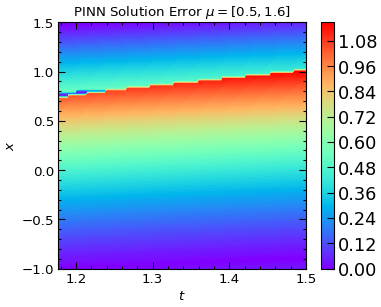

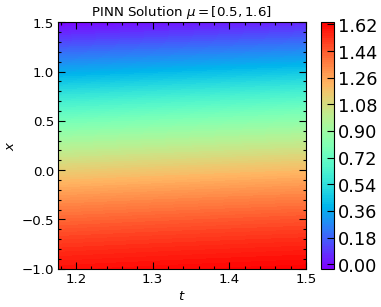

Epoch: 1200 | loss: 1.0769673585891724,rMAE: 0.32143309712409973, rRMSE:0.3546355068683624,loss_RH:0.00000000,loss_con:2.57169676,loss_R:0.2466260939836502,loss_IC:0.0820627361536026,loss_BC:0.0009713813196867704
Epoch: 1400 | loss: 1.0510082244873047,rMAE: 0.31181538105010986, rRMSE:0.3458724319934845,loss_RH:0.00000000,loss_con:2.57639122,loss_R:0.23506169021129608,loss_IC:0.08066042512655258,loss_BC:0.0009342266712337732
Epoch: 1600 | loss: 1.0148528814315796,rMAE: 0.29855862259864807, rRMSE:0.33403342962265015,loss_RH:0.00000000,loss_con:2.57774544,loss_R:0.2198050171136856,loss_IC:0.07862929254770279,loss_BC:0.0008754887385293841
Epoch: 1800 | loss: 0.9612683653831482,rMAE: 0.2794785797595978, rRMSE:0.3176877796649933,loss_RH:0.00000000,loss_con:2.57643342,loss_R:0.19933873414993286,loss_IC:0.07541009783744812,loss_BC:0.0007828623056411743
Epoch: 2000 | loss: 0.880607008934021,rMAE: 0.2516827881336212, rRMSE:0.29529711604118347,loss_RH:0.00000000,loss_con:2.57325029,loss_R:0.17314

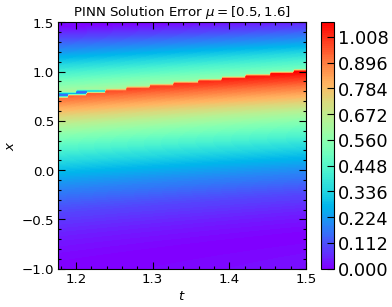

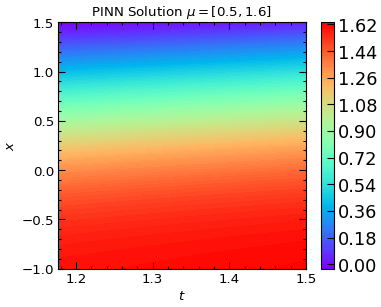

Epoch: 2200 | loss: 0.7669431567192078,rMAE: 0.21562400460243225, rRMSE:0.26715341210365295,loss_RH:0.00000000,loss_con:2.57176256,loss_R:0.1424609273672104,loss_IC:0.06194674223661423,loss_BC:0.0005014787893742323
Epoch: 2400 | loss: 0.6469814777374268,rMAE: 0.1875937581062317, rRMSE:0.2388402223587036,loss_RH:0.00000000,loss_con:2.57634044,loss_R:0.11500827223062515,loss_IC:0.052681028842926025,loss_BC:0.0005162894376553595
Epoch: 2600 | loss: 0.5727518200874329,rMAE: 0.1775623857975006, rRMSE:0.2209908664226532,loss_RH:0.00000000,loss_con:2.58029461,loss_R:0.09911078959703445,loss_IC:0.046574439853429794,loss_BC:0.0007896621827967465
Epoch: 2800 | loss: 0.5407781004905701,rMAE: 0.1756591498851776, rRMSE:0.21387167274951935,loss_RH:0.00000000,loss_con:2.57683015,loss_R:0.09272845834493637,loss_IC:0.04383283481001854,loss_BC:0.0009721288224682212
Epoch: 3000 | loss: 0.520583987236023,rMAE: 0.1725841611623764, rRMSE:0.20979982614517212,loss_RH:0.00000000,loss_con:2.56997371,loss_R:0.08

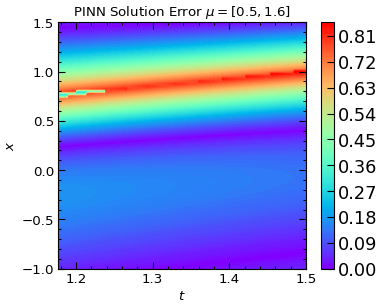

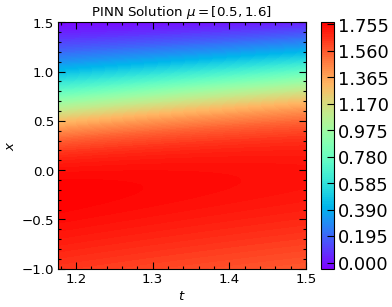

Epoch: 3200 | loss: 0.5000921487808228,rMAE: 0.16675972938537598, rRMSE:0.2054007649421692,loss_RH:0.00000000,loss_con:2.56277490,loss_R:0.08516451716423035,loss_IC:0.040746890008449554,loss_BC:0.0007458750624209642
Epoch: 3400 | loss: 0.47422388195991516,rMAE: 0.15771298110485077, rRMSE:0.19934271275997162,loss_RH:0.00000000,loss_con:2.55569816,loss_R:0.07990960031747818,loss_IC:0.03897476568818092,loss_BC:0.0004566650022752583
Epoch: 3600 | loss: 0.43550577759742737,rMAE: 0.14319321513175964, rRMSE:0.18997353315353394,loss_RH:0.00000000,loss_con:2.54981041,loss_R:0.07202007621526718,loss_IC:0.03618516027927399,loss_BC:0.00016340852016583085
Epoch: 3800 | loss: 0.3759385943412781,rMAE: 0.11900977790355682, rRMSE:0.17506113648414612,loss_RH:0.00000000,loss_con:2.55032825,loss_R:0.060329370200634,loss_IC:0.03154259920120239,loss_BC:1.8321014067623764e-05
Epoch: 4000 | loss: 0.30739474296569824,rMAE: 0.09172254055738449, rRMSE:0.15652725100517273,loss_RH:0.00000000,loss_con:2.55609417,lo

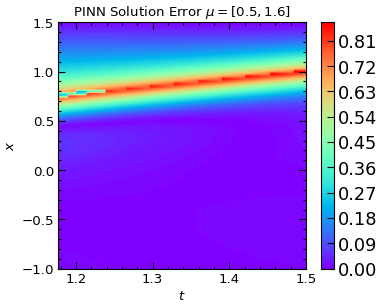

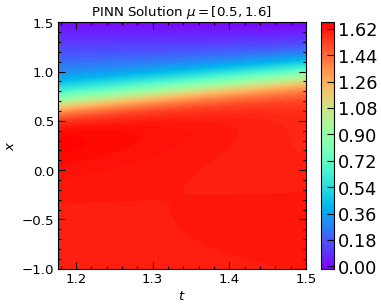

Epoch: 4200 | loss: 0.2508407235145569,rMAE: 0.078714519739151, rRMSE:0.13922151923179626,loss_RH:0.00000000,loss_con:2.56012416,loss_R:0.03700903058052063,loss_IC:0.021251484751701355,loss_BC:0.00013168330769985914
Epoch: 4400 | loss: 0.21116966009140015,rMAE: 0.06993835419416428, rRMSE:0.12516695261001587,loss_RH:0.00000000,loss_con:2.56277609,loss_R:0.029674053192138672,loss_IC:0.017986685037612915,loss_BC:0.00016287463949993253
Epoch: 4600 | loss: 0.18429763615131378,rMAE: 0.06417609751224518, rRMSE:0.1144806295633316,loss_RH:0.00000000,loss_con:2.56429386,loss_R:0.024630414322018623,loss_IC:0.015817807987332344,loss_BC:0.0001489150308771059
Epoch: 4800 | loss: 0.16609930992126465,rMAE: 0.06110931932926178, rRMSE:0.10664752870798111,loss_RH:0.00000000,loss_con:2.56486678,loss_R:0.021186435595154762,loss_IC:0.014381161890923977,loss_BC:0.00011012535105692223
Epoch: 5000 | loss: 0.15385447442531586,rMAE: 0.05960110202431679, rRMSE:0.10100525617599487,loss_RH:0.00000000,loss_con:2.564

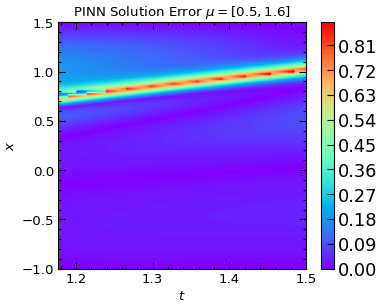

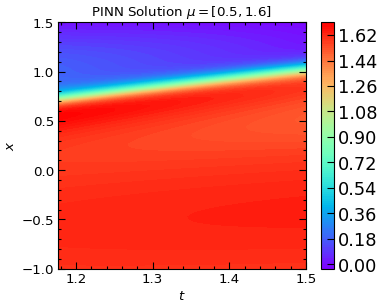

Epoch: 5200 | loss: 0.14580038189888,rMAE: 0.05853237956762314, rRMSE:0.0968034639954567,loss_RH:0.00000000,loss_con:2.56466746,loss_R:0.01708196848630905,loss_IC:0.012821616604924202,loss_BC:5.022461118642241e-05
Epoch: 5400 | loss: 0.13999010622501373,rMAE: 0.05706026405096054, rRMSE:0.09334715455770493,loss_RH:0.00000000,loss_con:2.56429100,loss_R:0.015620908699929714,loss_IC:0.012394309975206852,loss_BC:4.2610306991264224e-05
Epoch: 5600 | loss: 0.13519854843616486,rMAE: 0.05485213175415993, rRMSE:0.09023313224315643,loss_RH:0.00000000,loss_con:2.56383038,loss_R:0.01435141172260046,loss_IC:0.012042117305099964,loss_BC:4.2597272113198414e-05
Epoch: 5800 | loss: 0.1306130588054657,rMAE: 0.051971063017845154, rRMSE:0.08723494410514832,loss_RH:0.00000000,loss_con:2.56339169,loss_R:0.013211795128881931,loss_IC:0.011695611290633678,loss_BC:4.4515240006148815e-05
Epoch: 6000 | loss: 0.1257961094379425,rMAE: 0.04868507757782936, rRMSE:0.08431737869977951,loss_RH:0.00000000,loss_con:2.56297

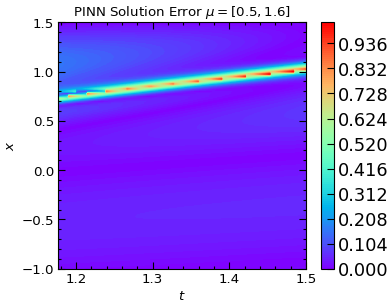

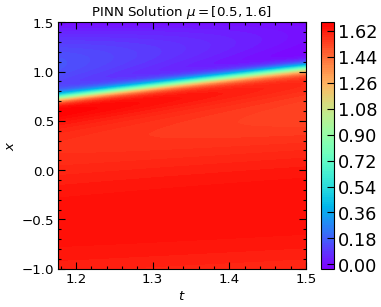

Epoch: 6200 | loss: 0.12063415348529816,rMAE: 0.04526548460125923, rRMSE:0.08140543103218079,loss_RH:0.00000000,loss_con:2.56260395,loss_R:0.011139343492686749,loss_IC:0.010904309339821339,loss_BC:4.5171826059231535e-05
Epoch: 6400 | loss: 0.11496169865131378,rMAE: 0.04199214652180672, rRMSE:0.07861758023500443,loss_RH:0.00000000,loss_con:2.56227994,loss_R:0.010212264023721218,loss_IC:0.010432644747197628,loss_BC:4.229904152452946e-05
Epoch: 6600 | loss: 0.10862977802753448,rMAE: 0.039129141718149185, rRMSE:0.07584279030561447,loss_RH:0.00000000,loss_con:2.56197453,loss_R:0.009298546239733696,loss_IC:0.009895900264382362,loss_BC:3.7223075196379796e-05
Epoch: 6800 | loss: 0.1017480343580246,rMAE: 0.03689899668097496, rRMSE:0.07338755577802658,loss_RH:0.00000000,loss_con:2.56164336,loss_R:0.008515906520187855,loss_IC:0.009292127564549446,loss_BC:3.108445162069984e-05
Epoch: 7000 | loss: 0.0944538488984108,rMAE: 0.035288140177726746, rRMSE:0.07105317711830139,loss_RH:0.00000000,loss_con:2

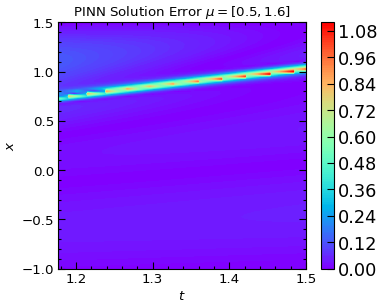

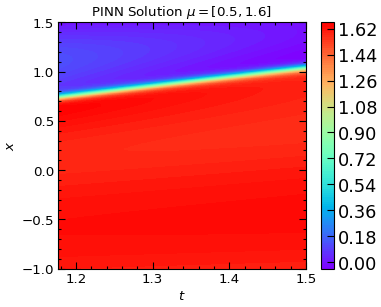

Epoch: 7200 | loss: 0.08733585476875305,rMAE: 0.034157853573560715, rRMSE:0.06909037381410599,loss_RH:0.00000000,loss_con:2.56286502,loss_R:0.007184700109064579,loss_IC:0.007994882762432098,loss_BC:2.0232979295542464e-05
Epoch: 7400 | loss: 0.08079326152801514,rMAE: 0.03319917991757393, rRMSE:0.06687550991773605,loss_RH:0.00000000,loss_con:2.56073022,loss_R:0.0066975983791053295,loss_IC:0.007393209263682365,loss_BC:1.6357458662241697e-05
Epoch: 7600 | loss: 0.07472217082977295,rMAE: 0.03232075273990631, rRMSE:0.06488669663667679,loss_RH:0.00000000,loss_con:2.54884195,loss_R:0.0061333030462265015,loss_IC:0.006838757079094648,loss_BC:2.0129407857893966e-05
Epoch: 7800 | loss: 0.06903613358736038,rMAE: 0.031132176518440247, rRMSE:0.06327098608016968,loss_RH:0.00000000,loss_con:2.56957102,loss_R:0.005642211530357599,loss_IC:0.006323034409433603,loss_BC:1.635714215808548e-05
Epoch: 8000 | loss: 0.06379589438438416,rMAE: 0.03007342666387558, rRMSE:0.061001695692539215,loss_RH:0.00000000,loss

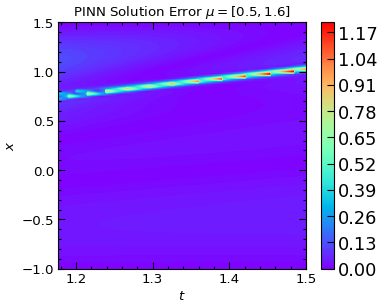

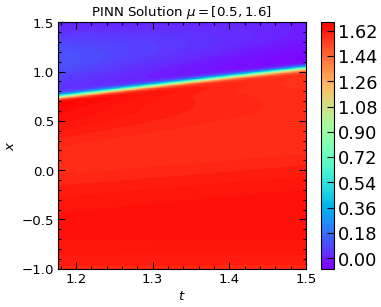

Epoch: 8200 | loss: 0.05890122428536415,rMAE: 0.02882995642721653, rRMSE:0.059035491198301315,loss_RH:0.00000000,loss_con:2.55968881,loss_R:0.0046998560428619385,loss_IC:0.005412782542407513,loss_BC:7.354019544436596e-06
Epoch: 8400 | loss: 0.05443209037184715,rMAE: 0.027402300387620926, rRMSE:0.05646310746669769,loss_RH:0.00000000,loss_con:2.55919027,loss_R:0.004304868634790182,loss_IC:0.00500757759436965,loss_BC:5.14475777890766e-06
Epoch: 8600 | loss: 0.05023404210805893,rMAE: 0.026010077446699142, rRMSE:0.05503159016370773,loss_RH:0.00000000,loss_con:2.55893826,loss_R:0.003938181791454554,loss_IC:0.004626153502613306,loss_BC:3.432189714658307e-06
Epoch: 8800 | loss: 0.04623017460107803,rMAE: 0.024541832506656647, rRMSE:0.05234291031956673,loss_RH:0.00000000,loss_con:2.55855370,loss_R:0.003611319698393345,loss_IC:0.004259628709405661,loss_BC:2.2569479369849432e-06
Epoch: 9000 | loss: 0.04235024377703667,rMAE: 0.02331169694662094, rRMSE:0.050699710845947266,loss_RH:0.00000000,loss_co

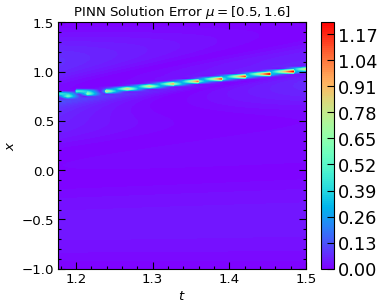

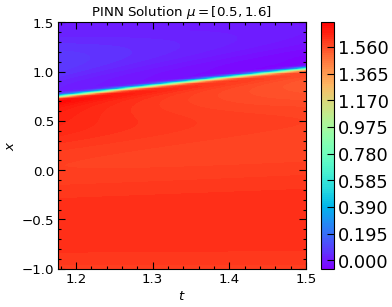

Epoch: 9200 | loss: 0.03816922754049301,rMAE: 0.022214770317077637, rRMSE:0.048915911465883255,loss_RH:0.00000000,loss_con:2.55866003,loss_R:0.0031505359802395105,loss_IC:0.0035008813720196486,loss_BC:9.875362820821465e-07
Epoch: 9400 | loss: 0.03312767669558525,rMAE: 0.021085793152451515, rRMSE:0.04799075052142143,loss_RH:0.00000000,loss_con:2.55809188,loss_R:0.002936989301815629,loss_IC:0.003018423216417432,loss_BC:6.456965593315545e-07
Epoch: 9600 | loss: 0.027048999443650246,rMAE: 0.019607752561569214, rRMSE:0.04666348174214363,loss_RH:0.00000000,loss_con:2.55904722,loss_R:0.0028147962875664234,loss_IC:0.002423114376142621,loss_BC:3.0597399813814263e-07
Epoch: 9800 | loss: 0.021088512614369392,rMAE: 0.018514616414904594, rRMSE:0.045323509722948074,loss_RH:0.00000000,loss_con:2.55941534,loss_R:0.0027558226138353348,loss_IC:0.0018326028948649764,loss_BC:6.659852829216106e-07
Epoch: 10000 | loss: 0.016687296330928802,rMAE: 0.018271910026669502, rRMSE:0.04432243853807449,loss_RH:0.0000

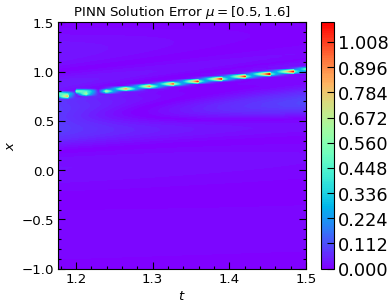

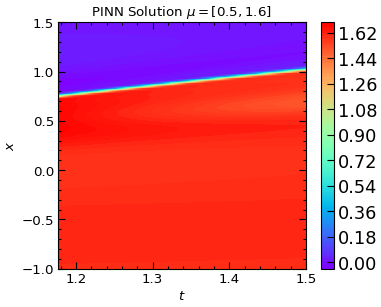

Epoch: 10200 | loss: 0.014192740432918072,rMAE: 0.01824823208153248, rRMSE:0.04347705841064453,loss_RH:0.00000000,loss_con:2.56002688,loss_R:0.00264919176697731,loss_IC:0.001153832650743425,loss_BC:5.222238996793749e-07
Epoch: 10400 | loss: 0.012674319557845592,rMAE: 0.0180608369410038, rRMSE:0.04203365370631218,loss_RH:0.00000000,loss_con:2.56002021,loss_R:0.002568455645814538,loss_IC:0.0010103362146764994,loss_BC:2.5021125793500687e-07
Epoch: 10600 | loss: 0.01155952550470829,rMAE: 0.017863823100924492, rRMSE:0.04273312911391258,loss_RH:0.00000000,loss_con:2.55987883,loss_R:0.0024782174732536077,loss_IC:0.0009079899173229933,loss_BC:1.4088436728343368e-07
Epoch: 10800 | loss: 0.01059254352003336,rMAE: 0.01739184744656086, rRMSE:0.04121491312980652,loss_RH:0.00000000,loss_con:2.55877733,loss_R:0.0023447489365935326,loss_IC:0.0008245725184679031,loss_BC:2.0700714742361015e-07
Epoch: 11000 | loss: 0.009784161113202572,rMAE: 0.016843022778630257, rRMSE:0.040508054196834564,loss_RH:0.0000

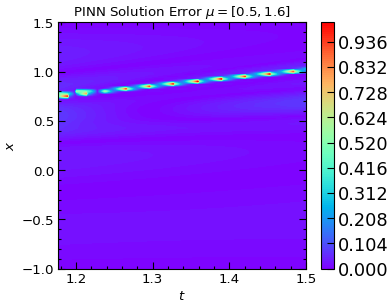

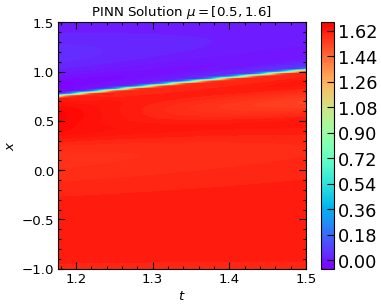

Epoch: 11200 | loss: 0.009022587910294533,rMAE: 0.016324015334248543, rRMSE:0.04027392342686653,loss_RH:0.00000000,loss_con:2.56011367,loss_R:0.0021507025230675936,loss_IC:0.0006869594799354672,loss_BC:2.290784095748677e-07
Epoch: 11400 | loss: 0.008541237562894821,rMAE: 0.015525167807936668, rRMSE:0.03953836113214493,loss_RH:0.00000000,loss_con:2.57349277,loss_R:0.002148568630218506,loss_IC:0.0006301215034909546,loss_BC:9.145419426204171e-06
Epoch: 11600 | loss: 0.007738232612609863,rMAE: 0.015172484330832958, rRMSE:0.038963284343481064,loss_RH:0.00000000,loss_con:2.56214213,loss_R:0.002016865648329258,loss_IC:0.0005715417210012674,loss_BC:5.950122954345716e-07
Epoch: 11800 | loss: 0.00714669656008482,rMAE: 0.01466754637658596, rRMSE:0.03845462203025818,loss_RH:0.00000000,loss_con:2.55957365,loss_R:0.0019459554459899664,loss_IC:0.0005196037236601114,loss_BC:4.703857143795176e-07
Epoch: 12000 | loss: 0.0066009219735860825,rMAE: 0.014217758551239967, rRMSE:0.03806711360812187,loss_RH:0.

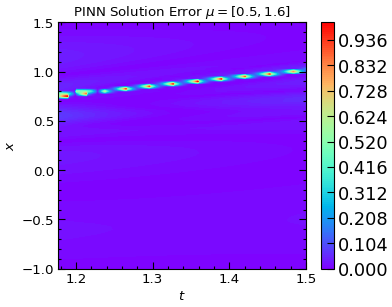

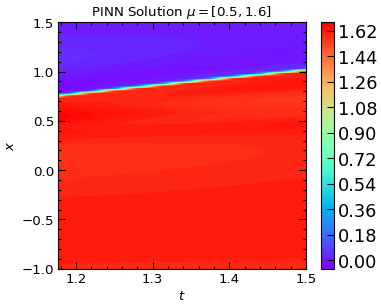

Epoch: 12200 | loss: 0.006077632773667574,rMAE: 0.013820835389196873, rRMSE:0.0376393161714077,loss_RH:0.00000000,loss_con:2.56034231,loss_R:0.0018350589089095592,loss_IC:0.00042374033364467323,loss_BC:5.170640520191228e-07
Epoch: 12400 | loss: 0.005580115132033825,rMAE: 0.013435076922178268, rRMSE:0.03721170872449875,loss_RH:0.00000000,loss_con:2.55982614,loss_R:0.001788449240848422,loss_IC:0.0003786472661886364,loss_BC:5.1936149247922e-07
Epoch: 12600 | loss: 0.00507432920858264,rMAE: 0.013057655654847622, rRMSE:0.03685704618692398,loss_RH:0.00000000,loss_con:2.56092381,loss_R:0.001720718340948224,loss_IC:0.00033482658909633756,loss_BC:5.345008275980945e-07
Epoch: 12800 | loss: 0.004676753655076027,rMAE: 0.01271536573767662, rRMSE:0.03631788492202759,loss_RH:0.00000000,loss_con:2.55935860,loss_R:0.0017509020399302244,loss_IC:0.0002920831320807338,loss_BC:5.020275466449675e-07
Epoch: 13000 | loss: 0.004198006354272366,rMAE: 0.01239749789237976, rRMSE:0.036008626222610474,loss_RH:0.000

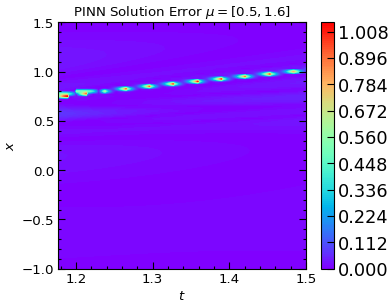

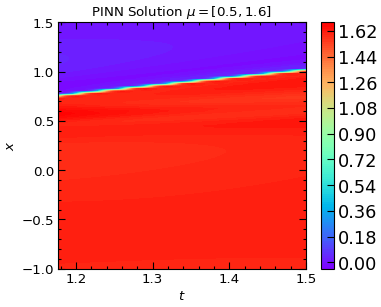

Epoch: 13200 | loss: 0.003747958689928055,rMAE: 0.012107050977647305, rRMSE:0.035598963499069214,loss_RH:0.00000000,loss_con:2.56011653,loss_R:0.0016321555012837052,loss_IC:0.00021121113968547434,loss_BC:3.691780534609279e-07
Epoch: 13400 | loss: 0.003268043976277113,rMAE: 0.01178338099271059, rRMSE:0.03450830653309822,loss_RH:0.00000000,loss_con:2.56009078,loss_R:0.0015206563984975219,loss_IC:0.00017443073738832027,loss_BC:3.0800609351899766e-07
Epoch: 13600 | loss: 0.0028960288036614656,rMAE: 0.0115123325958848, rRMSE:0.03425813466310501,loss_RH:0.00000000,loss_con:2.55976176,loss_R:0.0014818781055510044,loss_IC:0.00014116715465206653,loss_BC:2.47926521979025e-07
Epoch: 13800 | loss: 0.0025583028327673674,rMAE: 0.011124367825686932, rRMSE:0.03395029902458191,loss_RH:0.00000000,loss_con:2.56502485,loss_R:0.0014210442313924432,loss_IC:0.00011232383985770866,loss_BC:1.402015413987101e-06
Epoch: 14000 | loss: 0.0022694978397339582,rMAE: 0.010879015550017357, rRMSE:0.03293246403336525,los

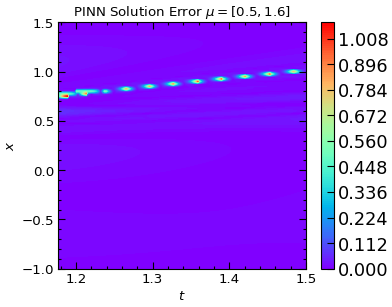

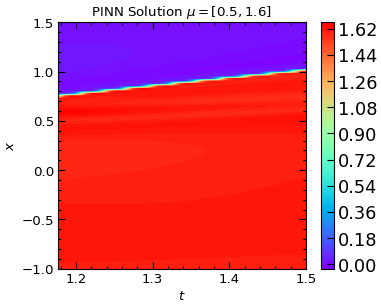

Epoch: 14200 | loss: 0.001996934413909912,rMAE: 0.010548547841608524, rRMSE:0.032301366329193115,loss_RH:0.00000000,loss_con:2.55970097,loss_R:0.0013151578605175018,loss_IC:6.805435259593651e-05,loss_BC:1.2328978016284964e-07
Epoch: 14400 | loss: 0.0018010495696216822,rMAE: 0.010223865509033203, rRMSE:0.03175756335258484,loss_RH:0.00000000,loss_con:2.55965400,loss_R:0.0012723504332825541,loss_IC:5.2732069889316335e-05,loss_BC:1.3783980534753937e-07
Epoch: 14600 | loss: 0.0016463787760585546,rMAE: 0.009851023554801941, rRMSE:0.031861089169979095,loss_RH:0.00000000,loss_con:2.56236410,loss_R:0.0012321408139541745,loss_IC:4.1070659790420905e-05,loss_BC:3.531371248755022e-07
Epoch: 14800 | loss: 0.0015046531334519386,rMAE: 0.009540152736008167, rRMSE:0.0316215418279171,loss_RH:0.00000000,loss_con:2.56171322,loss_R:0.001181766390800476,loss_IC:3.20727085636463e-05,loss_BC:2.1597145405394258e-07
Epoch: 15000 | loss: 0.0013808619696646929,rMAE: 0.009234840050339699, rRMSE:0.031556062400341034

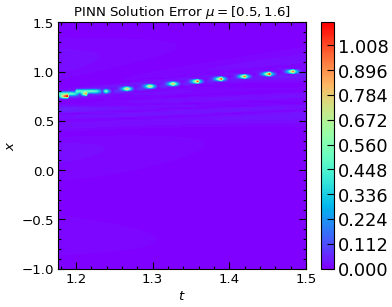

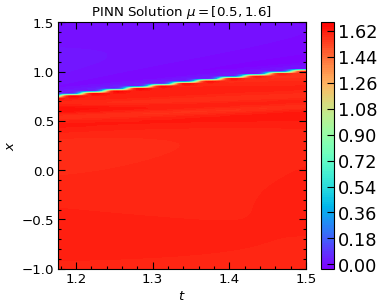

Epoch: 15200 | loss: 0.0013553088065236807,rMAE: 0.00918410811573267, rRMSE:0.03153945878148079,loss_RH:0.00000000,loss_con:2.55997062,loss_R:0.0011130485218018293,loss_IC:2.4152681362465955e-05,loss_BC:7.334394069857808e-08
Epoch: 15400 | loss: 0.0013233470963314176,rMAE: 0.009080292657017708, rRMSE:0.03146502375602722,loss_RH:0.00000000,loss_con:2.55996227,loss_R:0.001097257947549224,loss_IC:2.253307684441097e-05,loss_BC:7.583439298741723e-08
Epoch: 15600 | loss: 0.0012889931676909328,rMAE: 0.008942335844039917, rRMSE:0.031382735818624496,loss_RH:0.00000000,loss_con:2.55996656,loss_R:0.0010798940202221274,loss_IC:2.0833245798712596e-05,loss_BC:7.667132706501434e-08
Epoch: 15800 | loss: 0.0012537920847535133,rMAE: 0.00877663865685463, rRMSE:0.031300149857997894,loss_RH:0.00000000,loss_con:2.55996728,loss_R:0.001061542658135295,loss_IC:1.9149731087964028e-05,loss_BC:7.52097264467011e-08
Epoch: 16000 | loss: 0.0012187506072223186,rMAE: 0.008587894029915333, rRMSE:0.0312186349183321,loss

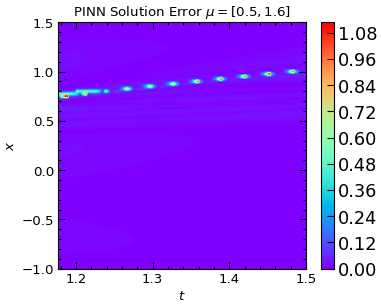

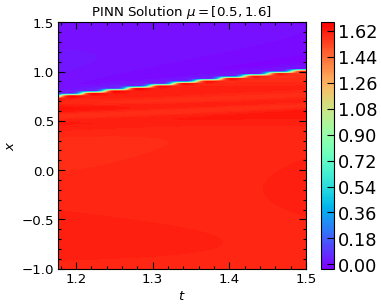

Epoch: 16200 | loss: 0.0011843524407595396,rMAE: 0.008384644985198975, rRMSE:0.031117169186472893,loss_RH:0.00000000,loss_con:2.55998826,loss_R:0.0010235647205263376,loss_IC:1.601233634573873e-05,loss_BC:6.643626448976647e-08
Epoch: 16400 | loss: 0.001151012722402811,rMAE: 0.008172542788088322, rRMSE:0.031036339700222015,loss_RH:0.00000000,loss_con:2.55998898,loss_R:0.001004412886686623,loss_IC:1.4599667338188738e-05,loss_BC:6.031402222106408e-08
Epoch: 16600 | loss: 0.0011188884964212775,rMAE: 0.007952718995511532, rRMSE:0.030946707352995872,loss_RH:0.00000000,loss_con:2.55998898,loss_R:0.0009853633819147944,loss_IC:1.3299340025696438e-05,loss_BC:5.316708140412629e-08
Epoch: 16800 | loss: 0.0011694679269567132,rMAE: 0.0077181532979011536, rRMSE:0.030513254925608635,loss_RH:0.00000000,loss_con:2.56003165,loss_R:0.0010478351032361388,loss_IC:1.2115547178837005e-05,loss_BC:4.773739803454191e-08
Epoch: 17000 | loss: 0.0011394890025258064,rMAE: 0.007519439794123173, rRMSE:0.030406495556235

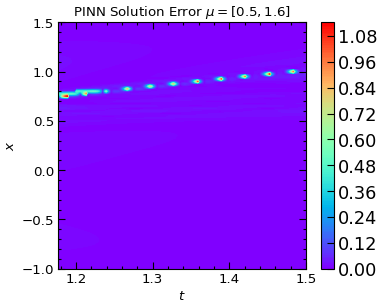

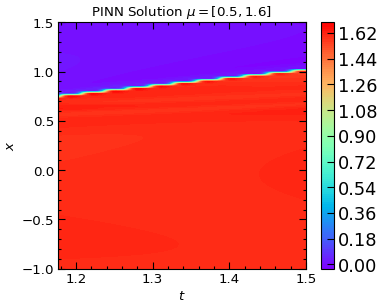

Epoch: 17200 | loss: 0.0011164339957758784,rMAE: 0.007321246434003115, rRMSE:0.030251789838075638,loss_RH:0.00000000,loss_con:2.56008983,loss_R:0.0010142158716917038,loss_IC:1.0184806342294905e-05,loss_BC:3.7000539521159226e-08
Epoch: 17400 | loss: 0.0010897909523919225,rMAE: 0.007164568640291691, rRMSE:0.030191650614142418,loss_RH:0.00000000,loss_con:2.56003094,loss_R:0.0009955530986189842,loss_IC:9.389272236148827e-06,loss_BC:3.45142225910422e-08
Epoch: 17600 | loss: 0.0010648338356986642,rMAE: 0.007022772450000048, rRMSE:0.030098751187324524,loss_RH:0.00000000,loss_con:2.55992389,loss_R:0.0009777969680726528,loss_IC:8.672864169056993e-06,loss_BC:3.082626065520344e-08
Epoch: 17800 | loss: 0.0010412961710244417,rMAE: 0.006895263213664293, rRMSE:0.030042260885238647,loss_RH:0.00000000,loss_con:2.56010032,loss_R:0.0009607778629288077,loss_IC:8.024761882552411e-06,loss_BC:2.7069347652286524e-08
Epoch: 18000 | loss: 0.0010196020593866706,rMAE: 0.006786845158785582, rRMSE:0.029985297471284

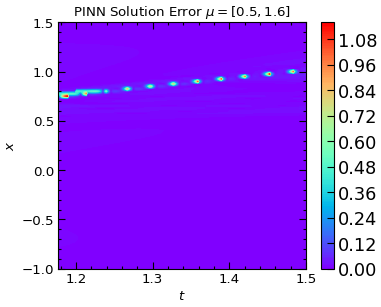

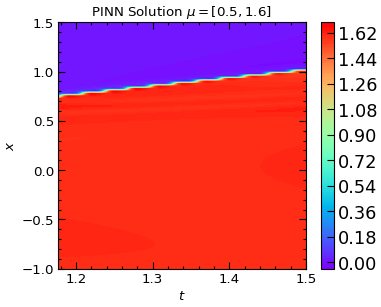

Epoch: 18200 | loss: 0.0009982134215533733,rMAE: 0.006677404046058655, rRMSE:0.02991621196269989,loss_RH:0.00000000,loss_con:2.55994010,loss_R:0.0009289511363022029,loss_IC:6.903102530486649e-06,loss_BC:2.3120508174656607e-08
Epoch: 18400 | loss: 0.0009783906862139702,rMAE: 0.006574051454663277, rRMSE:0.029856862500309944,loss_RH:0.00000000,loss_con:2.55954194,loss_R:0.0009139187168329954,loss_IC:6.414675226551481e-06,loss_BC:3.2519409387532505e-08
Epoch: 18600 | loss: 0.0009593572467565536,rMAE: 0.006481497082859278, rRMSE:0.029796231538057327,loss_RH:0.00000000,loss_con:2.55994129,loss_R:0.0008995328680612147,loss_IC:5.961909209872829e-06,loss_BC:2.0526186972347205e-08
Epoch: 18800 | loss: 0.0009416581015102565,rMAE: 0.006389477290213108, rRMSE:0.02972494624555111,loss_RH:0.00000000,loss_con:2.55935383,loss_R:0.0008856932981871068,loss_IC:5.553678420255892e-06,loss_BC:4.279961629549689e-08
Epoch: 19000 | loss: 0.0009241435909643769,rMAE: 0.00630385335534811, rRMSE:0.02968510426580906

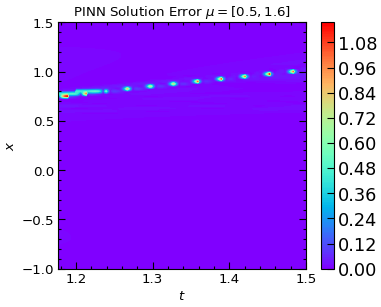

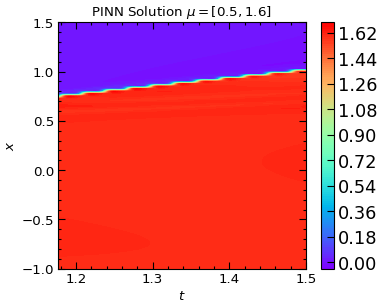

Epoch: 19200 | loss: 0.0009077618597075343,rMAE: 0.006219201255589724, rRMSE:0.029623860493302345,loss_RH:0.00000000,loss_con:2.55988264,loss_R:0.0008594516548328102,loss_IC:4.811096914636437e-06,loss_BC:1.992373199755093e-08
Epoch: 19400 | loss: 0.0008920502732507885,rMAE: 0.006140779238194227, rRMSE:0.029572635889053345,loss_RH:0.00000000,loss_con:2.56004977,loss_R:0.0008470279281027615,loss_IC:4.483498742047232e-06,loss_BC:1.8737807749857893e-08
Epoch: 19600 | loss: 0.0008770120330154896,rMAE: 0.006067108362913132, rRMSE:0.029558904469013214,loss_RH:0.00000000,loss_con:2.56007528,loss_R:0.0008350116549991071,loss_IC:4.180484211246949e-06,loss_BC:1.955575257284181e-08
Epoch: 19800 | loss: 0.0008633728139102459,rMAE: 0.005988488905131817, rRMSE:0.029516717419028282,loss_RH:0.00000000,loss_con:2.55900192,loss_R:0.0008234691340476274,loss_IC:3.916180958185578e-06,loss_BC:7.418600489472738e-08
Epoch: 20000 | loss: 0.0008487159502692521,rMAE: 0.005922256037592888, rRMSE:0.0294813234359025

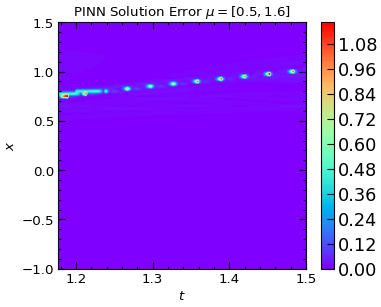

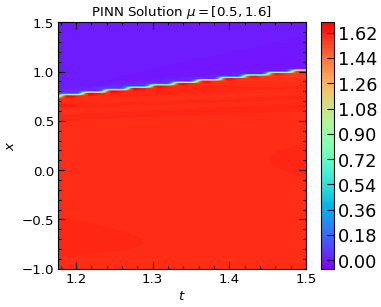

Epoch: 20200 | loss: 0.0008353560697287321,rMAE: 0.005854532588273287, rRMSE:0.029428668320178986,loss_RH:0.00000000,loss_con:2.56005549,loss_R:0.0008011321187950671,loss_IC:3.400629111638409e-06,loss_BC:2.1767396773952896e-08
Epoch: 20400 | loss: 0.0008225070778280497,rMAE: 0.005784763488918543, rRMSE:0.029370572417974472,loss_RH:0.00000000,loss_con:2.55988216,loss_R:0.0007904891390353441,loss_IC:3.1777458389115054e-06,loss_BC:2.404772914132991e-08
Epoch: 20600 | loss: 0.0008061293628998101,rMAE: 0.005715994164347649, rRMSE:0.02934076078236103,loss_RH:0.00000000,loss_con:2.55995655,loss_R:0.0007761433371342719,loss_IC:2.9750290195806883e-06,loss_BC:2.3571601559524424e-08
Epoch: 20800 | loss: 0.0007940613431856036,rMAE: 0.0056577869690954685, rRMSE:0.029281554743647575,loss_RH:0.00000000,loss_con:2.56073451,loss_R:0.0007656005909666419,loss_IC:2.7965152185061015e-06,loss_BC:4.955850840815401e-08
Epoch: 21000 | loss: 0.0007821047911420465,rMAE: 0.00558978458866477, rRMSE:0.0292494744062

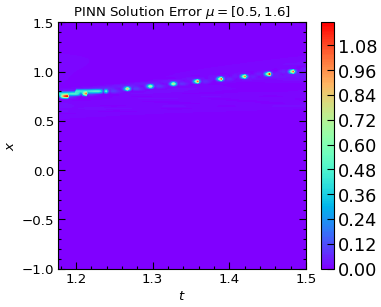

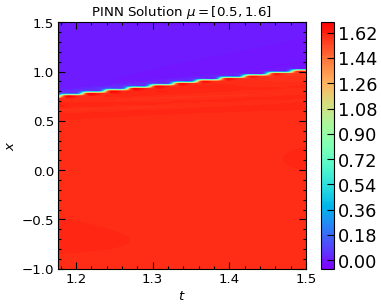

Epoch: 21200 | loss: 0.0007708510966040194,rMAE: 0.005534307099878788, rRMSE:0.029217153787612915,loss_RH:0.00000000,loss_con:2.56108594,loss_R:0.0007453324506059289,loss_IC:2.4693301838851767e-06,loss_BC:8.253440597627559e-08
Epoch: 21400 | loss: 0.0007588974549435079,rMAE: 0.005463182460516691, rRMSE:0.029196277260780334,loss_RH:0.00000000,loss_con:2.56009078,loss_R:0.000735616369638592,loss_IC:2.3004336071608122e-06,loss_BC:2.767750828525095e-08
Epoch: 21600 | loss: 0.000747992133256048,rMAE: 0.005400173366069794, rRMSE:0.02915063500404358,loss_RH:0.00000000,loss_con:2.55999970,loss_R:0.000726099475286901,loss_IC:2.1601888420264004e-06,loss_BC:2.9076996810317723e-08
Epoch: 21800 | loss: 0.0007374262786470354,rMAE: 0.005338912829756737, rRMSE:0.02910846471786499,loss_RH:0.00000000,loss_con:2.55997109,loss_R:0.0007168228039517999,loss_IC:2.0311019852670142e-06,loss_BC:2.9247210875382734e-08
Epoch: 22000 | loss: 0.000727236270904541,rMAE: 0.005281807854771614, rRMSE:0.02911132760345935

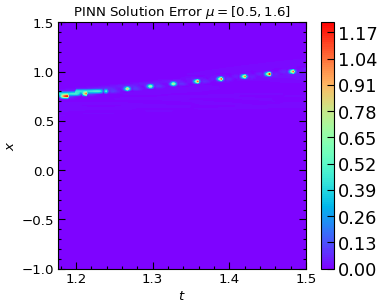

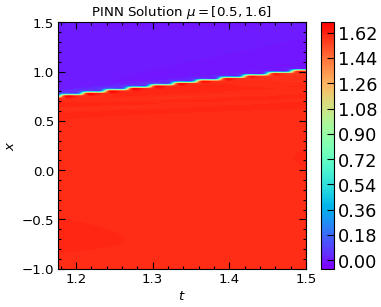

Epoch: 22200 | loss: 0.0007171793840825558,rMAE: 0.005224911496043205, rRMSE:0.02907397970557213,loss_RH:0.00000000,loss_con:2.56005502,loss_R:0.0006988666136749089,loss_IC:1.8000060890699388e-06,loss_BC:3.126949366105691e-08
Epoch: 22400 | loss: 0.0007074862951412797,rMAE: 0.005168778356164694, rRMSE:0.0290580615401268,loss_RH:0.00000000,loss_con:2.56000090,loss_R:0.0006901975721120834,loss_IC:1.6971787317743292e-06,loss_BC:3.1691307356140896e-08
Epoch: 22600 | loss: 0.0006980682956054807,rMAE: 0.005111906677484512, rRMSE:0.028982682153582573,loss_RH:0.00000000,loss_con:2.55985975,loss_R:0.000681709498167038,loss_IC:1.602307293069316e-06,loss_BC:3.356975497581516e-08
Epoch: 22800 | loss: 0.0006888714269734919,rMAE: 0.00506184808909893, rRMSE:0.028980549424886703,loss_RH:0.00000000,loss_con:2.55996084,loss_R:0.0006733952322974801,loss_IC:1.5141346239033737e-06,loss_BC:3.3483726014083004e-08
Epoch: 23000 | loss: 0.0006799967377446592,rMAE: 0.005010723136365414, rRMSE:0.02895307727158069

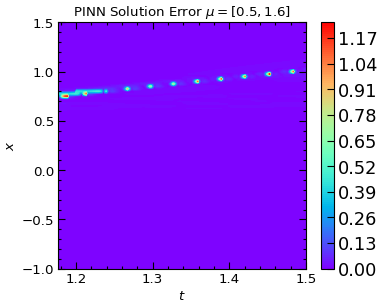

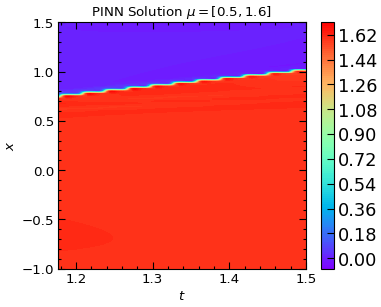

Epoch: 23200 | loss: 0.0006714026676490903,rMAE: 0.0049609048292040825, rRMSE:0.02889762818813324,loss_RH:0.00000000,loss_con:2.55949497,loss_R:0.0006573235732503235,loss_IC:1.3603537354356376e-06,loss_BC:4.7556838467244233e-08
Epoch: 23400 | loss: 0.0006626910180784762,rMAE: 0.0049142311327159405, rRMSE:0.028903301805257797,loss_RH:0.00000000,loss_con:2.55985665,loss_R:0.0006494668778032064,loss_IC:1.2869937791037955e-06,loss_BC:3.542213633522806e-08
Epoch: 23600 | loss: 0.0006543485214933753,rMAE: 0.0048655299469828606, rRMSE:0.02883274294435978,loss_RH:0.00000000,loss_con:2.55993795,loss_R:0.0006417836993932724,loss_IC:1.2219734344398603e-06,loss_BC:3.450664110005164e-08
Epoch: 23800 | loss: 0.0006462100427597761,rMAE: 0.004823118448257446, rRMSE:0.028837498277425766,loss_RH:0.00000000,loss_con:2.56024623,loss_R:0.0006342048291116953,loss_IC:1.1632622545221238e-06,loss_BC:3.726171016182889e-08
Epoch: 24000 | loss: 0.0006387551547959447,rMAE: 0.004781228024512529, rRMSE:0.02878059260

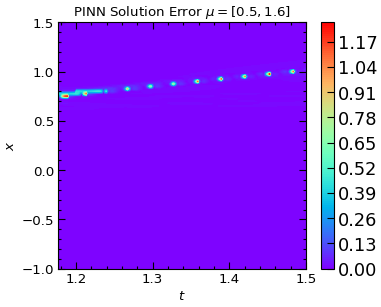

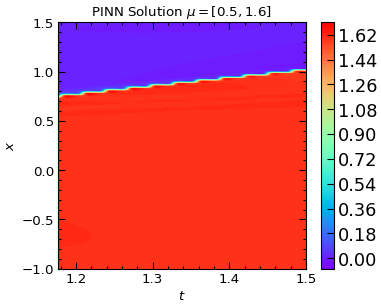

Epoch: 24200 | loss: 0.0006303419359028339,rMAE: 0.004743572790175676, rRMSE:0.028775524348020554,loss_RH:0.00000000,loss_con:2.56010413,loss_R:0.0006194425513967872,loss_IC:1.0547609008426662e-06,loss_BC:3.517631341765082e-08
Epoch: 24400 | loss: 0.0006314382189884782,rMAE: 0.004710073582828045, rRMSE:0.02870772033929825,loss_RH:0.00000000,loss_con:2.55988383,loss_R:0.000620957522187382,loss_IC:1.0121710829480435e-06,loss_BC:3.5897826933251054e-08
Epoch: 24600 | loss: 0.0006245082477107644,rMAE: 0.0046728262677788734, rRMSE:0.028684064745903015,loss_RH:0.00000000,loss_con:2.55998206,loss_R:0.0006144096259959042,loss_IC:9.743663440531236e-07,loss_BC:3.5498718631288284e-08
Epoch: 24800 | loss: 0.0006175612797960639,rMAE: 0.004636432975530624, rRMSE:0.028665361925959587,loss_RH:0.00000000,loss_con:2.56007600,loss_R:0.0006078339065425098,loss_IC:9.373044917992956e-07,loss_BC:3.543303606079462e-08
Epoch: 25000 | loss: 0.0006105730426497757,rMAE: 0.004602270666509867, rRMSE:0.02862974070012

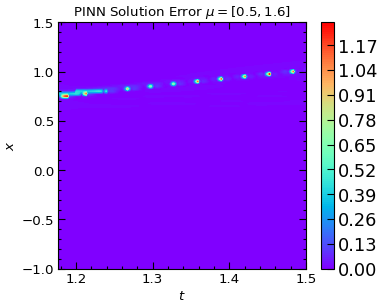

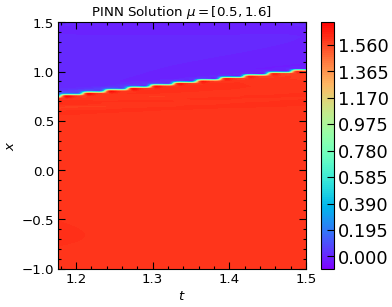

PINN Training Completed

PINN2 Training Time: 0.5557166194747616 Hours


In [95]:
residual_data2 = create_residual_data(Xi, Xf, Ti2, Tf2, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid2      = residual_data2[0].to(device)
f_hat2         = residual_data2[1].to(device)
xt_test2       = residual_data2[2].to(device)
xt_RHL2      = residual_data2[3].to(device)
xt_RHR2      = residual_data2[4].to(device)
xt_RHt2         = residual_data2[5].to(device)
xt_RHtL2       = residual_data2[6].to(device)

BC_data2 = create_BC_data(Xi, Xf, Ti2, Tf2, BC_pts)
BC_bottom2     = BC_data2[0].to(device)
BC_top2        = BC_data2[1].to(device)

IC_data2 = create_IC_data(nu_pinn_train,Xi, Xf, Ti2, Tf2, IC_pts, IC_simple)
IC_xt2     = IC_data2[0].to(device)
IC_u2      = IC_data2[1].to(device)

Exact_y2 = exact_u(nu_pinn_train,xt_test2)[:,None].to(device)
###   IFNN2 training   ####
pinn2_train_time_1 = time.perf_counter()
PINN2 = NN2(nu_pinn_train,layers_pinn,dt,cut_t).to(device)
    
pinn2_losses = pinn2_train(PINN2, nu_pinn_train,PINN1, xt_resid2, IC_xt2, IC_u2, BC_bottom2, BC_top2, xt_RHL2,xt_RHR2,xt_RHt2,xt_RHtL2, f_hat2,Exact_y2, epochs_pinn2, lr_pinn2, tol_pinn2, xt_test2)
pinn2_train_time_2 = time.perf_counter()
print(f"PINN2 Training Time: {(pinn2_train_time_2-pinn2_train_time_1)/3600} Hours")

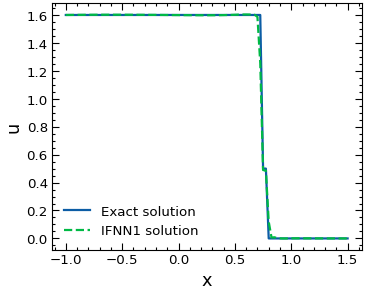

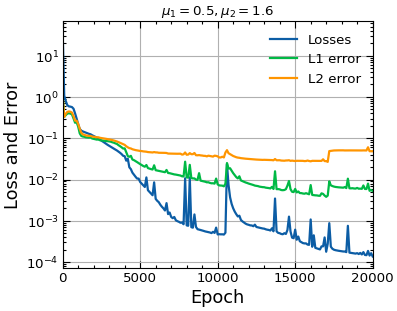

In [124]:
###   Plot1   ###
plt.figure(dpi=80, figsize=(5,4))
plt.plot(xt_test1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),Exact_y1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),label='Exact solution')
plt.plot(xt_test1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),PINN1(xt_test1)[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),'--',label = 'IFNN1 solution')
plt.xlabel("x",     fontsize=16)
plt.ylabel("u",     fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#20
plt.show()

#Burgers_plot(xt_test1, Exact_y1, Nx_test,Nt_test, title=fr"Step1 Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test1, PINN1(xt_test1),Nx_test,Nt_test, title=fr"IFNN1 Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test1, abs(PINN1(xt_test1)-Exact_y1), Nx_test,Nt_test,title=fr"IFNN1 Error  $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

plt.figure(dpi=80, figsize=(5,4))    
plt.plot(pinn1_losses[0], pinn1_losses[1], label="Losses")
plt.plot(pinn1_losses[0], pinn1_losses[2], label="L1 error")
plt.plot(pinn1_losses[0], pinn1_losses[3], label="L2 error")
#plt.plot(pinn1_losses[0], pinn1_losses[4], label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss and Error", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
plt.xlim(0,max(pinn1_losses[0]))
plt.yscale('log')
plt.title(fr"$\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()
##########################################

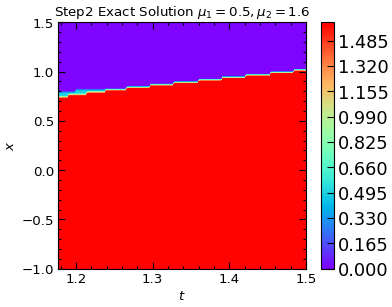

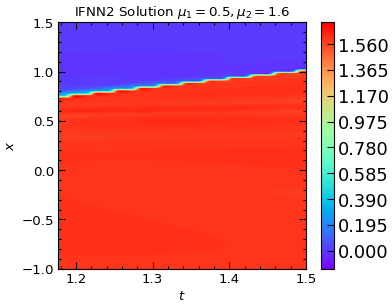

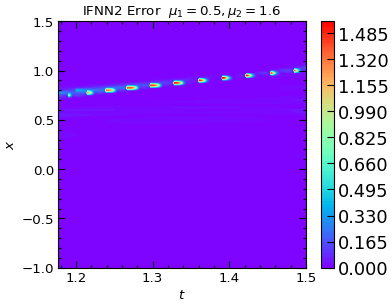

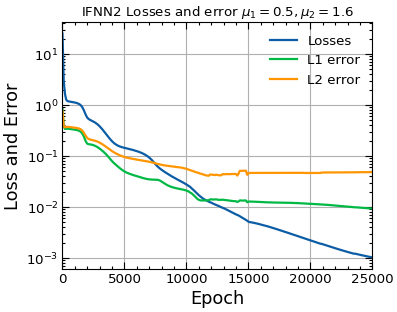

In [127]:
###     Plot2    ###
Burgers_plot(xt_test2, Exact_y2, Nx_test,Nt_test, title=fr"Step2 Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(xt_test2, PINN2(xt_test2),Nx_test,Nt_test, title=fr"IFNN2 Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(xt_test2, abs(PINN2(xt_test2)-Exact_y2), Nx_test,Nt_test,title=fr"IFNN2 Error  $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

plt.figure(dpi=80, figsize=(5,4))    
plt.plot(pinn2_losses[0], pinn2_losses[1], linewidth=2, label="Losses")
plt.plot(pinn2_losses[0], pinn2_losses[2], linewidth=2, label="L1 error")
plt.plot(pinn2_losses[0], pinn2_losses[3], linewidth=2, label="L2 error")
#plt.plot(pinn2_losses[0], pinn2_losses[4], linewidth=2, label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss and Error", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
plt.xlim(0,max(pinn2_losses[0]))
plt.yscale('log')
plt.title(fr"IFNN2 Losses and error $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)
plt.show()
###########################################

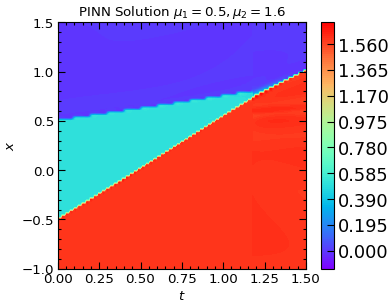

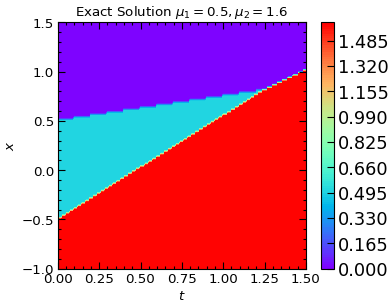

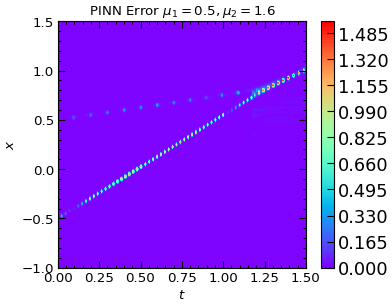

PINN at mu_1=0.5,mu_2=1.6 with the rMAE = 0.007677523419260979 and rRMSE = 0.048454441130161285


In [128]:
###   Plot   ###
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0),Nx_test,2*Nt_test, title=fr"PINN Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((Exact_y1,Exact_y2),0),Nx_test,2*Nt_test, title=fr"Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((abs(PINN1(xt_test1)-Exact_y1),abs(PINN2(xt_test2)-Exact_y2)),0),Nx_test,2*Nt_test, title=fr"PINN Error $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

rMAE = max(sum(abs(torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)-torch.cat((Exact_y1,Exact_y2),0)))/sum(abs(torch.cat((Exact_y1,Exact_y2),0))))
rRMSE = torch.sqrt(sum((torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)-torch.cat((Exact_y1,Exact_y2),0))**2)/sum((torch.cat((Exact_y1,Exact_y2),0))**2)).item()
print(f"PINN at mu_1={round(nu_pinn_train[0],3)},mu_2={round(nu_pinn_train[1],3)} with the rMAE = {rMAE} and rRMSE = {rRMSE}")

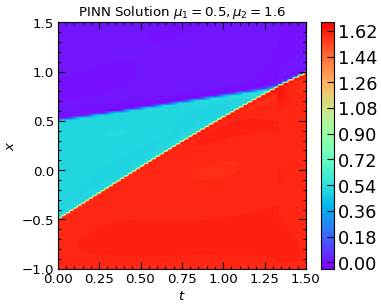

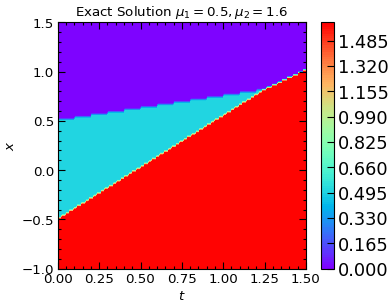

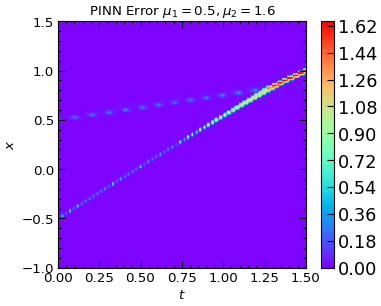

PINN at mu_1=0.5,mu_2=1.6 with the rMAE = 0.015303639695048332 and rRMSE = 0.09935519099235535


In [41]:
###   Plot   ###
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0),Nx_test,2*Nt_test, title=fr"PINN Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((Exact_y1,Exact_y2),0),Nx_test,2*Nt_test, title=fr"Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((abs(PINN1(xt_test1)-Exact_y1),abs(PINN2(xt_test2)-Exact_y2)),0),Nx_test,2*Nt_test, title=fr"PINN Error $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

rMAE = max(sum(abs(torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)-torch.cat((Exact_y1,Exact_y2),0)))/sum(abs(torch.cat((Exact_y1,Exact_y2),0))))
rRMSE = torch.sqrt(sum((torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)-torch.cat((Exact_y1,Exact_y2),0))**2)/sum((torch.cat((Exact_y1,Exact_y2),0))**2)).item()
print(f"PINN at mu_1={round(nu_pinn_train[0],3)},mu_2={round(nu_pinn_train[1],3)} with the rMAE = {rMAE} and rRMSE = {rRMSE}")

In [132]:
###   Save1   ###
w1 = PINN1.linears[0].weight.detach().cpu()
w2 = PINN1.linears[1].weight.detach().cpu()
w3 = PINN1.linears[2].weight.detach().cpu()
w4 = PINN1.linears[3].weight.detach().cpu()
w5 = PINN1.linears[4].weight.detach().cpu()
w6 = PINN1.linears[5].weight.detach().cpu()

b1 = PINN1.linears[0].bias.detach().cpu()
b2 = PINN1.linears[1].bias.detach().cpu()
b3 = PINN1.linears[2].bias.detach().cpu()
b4 = PINN1.linears[3].bias.detach().cpu()
b5 = PINN1.linears[4].bias.detach().cpu()
b6 = PINN1.linears[5].bias.detach().cpu()

IFNN1=P(layers_pinn, w1, w2, w3, w4,w5,w6, b1, b2, b3, b4,b5,b6).to(device)
#     with open('IFNN1_0109.pkl', 'wb') as f:
#          pickle.dump(IFNN1, f)
#     with open('IFNN2_loss_0109.pkl', 'wb') as f:
#          pickle.dump((pinn2_losses), f)

###   Save2   ###
m1 = PINN2.linears[0].weight.detach().cpu()
m2 = PINN2.linears[1].weight.detach().cpu()
m3 = PINN2.linears[2].weight.detach().cpu()
m4 = PINN2.linears[3].weight.detach().cpu()
m5 = PINN2.linears[4].weight.detach().cpu()
m6 = PINN2.linears[5].weight.detach().cpu()

n1 = PINN2.linears[0].bias.detach().cpu()
n2 = PINN2.linears[1].bias.detach().cpu()
n3 = PINN2.linears[2].bias.detach().cpu()
n4 = PINN2.linears[3].bias.detach().cpu()
n5 = PINN2.linears[4].bias.detach().cpu()
n6 = PINN2.linears[5].bias.detach().cpu()
IFNN2 = P(layers_pinn, m1,m2,m3,m4,m5,m6,n1,n2,n3,n4,n5,n6).to(device)
#     with open('IFNN2_0109.pkl', 'wb') as f:
#          pickle.dump(IFNN2, f)

#     with open('IFNN2_loss_0109.pkl', 'wb') as f:
#          pickle.dump((pinn2_losses), f)

with open('IFNN_shock2_0516_cut1.pkl','wb') as f:
    pickle.dump((IFNN1,IFNN2,pinn1_losses,pinn2_losses), f)

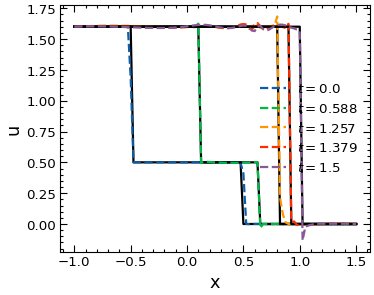

In [129]:
plt.figure(dpi=80, figsize=(5,4))

for ind in range(1, Nt_test,100):
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
for ind in range(Nt_test+51, 2*Nt_test+1,75):
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round(Ti2+(ind-1-Nt_test)*(Tf2-Ti2)/(Nt_test-1),3)}$")

plt.xlabel("x",     fontsize=16)
plt.ylabel("u", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

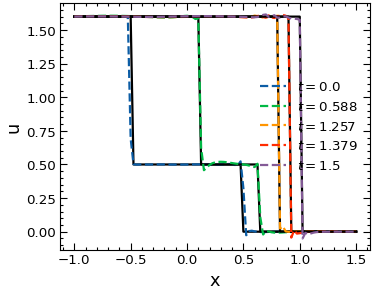

In [114]:
plt.figure(dpi=80, figsize=(5,4))

for ind in range(1, Nt_test,100):
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
for ind in range(Nt_test+51, 2*Nt_test+1,75):
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round(Ti2+(ind-1-Nt_test)*(Tf2-Ti2)/(Nt_test-1),3)}$")

plt.xlabel("x",     fontsize=16)
plt.ylabel("u", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

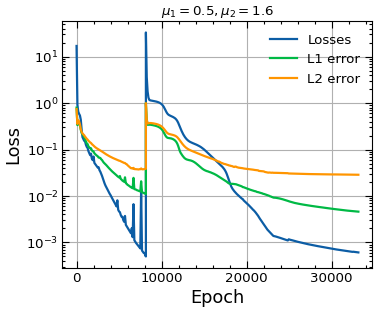

In [115]:
pinn1_losses = torch.tensor(pinn1_losses)
pinn2_losses = torch.tensor(pinn2_losses)
plt.figure(dpi=80, figsize=(5,4))    
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[1],pinn2_losses[1]),0), label="Losses")
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[2],pinn2_losses[2]),0), label="L1 error")
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[3],pinn2_losses[3]),0), label="L2 error")
#plt.plot(pinn1_losses[0], pinn1_losses[4], label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
#plt.xlim(0,max(pinn1_losses[0]))
plt.yscale('log')
plt.title(fr"$\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()

/tmp/ipykernel_121848/4165837517.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pinn1_losses = torch.tensor(pinn1_losses)


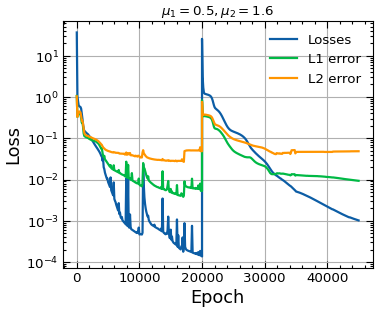

In [131]:
pinn1_losses = torch.tensor(pinn1_losses)
pinn2_losses = torch.tensor(pinn2_losses)
plt.figure(dpi=80, figsize=(5,4))    
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[1],pinn2_losses[1]),0), label="Losses")
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[2],pinn2_losses[2]),0), label="L1 error")
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[3],pinn2_losses[3]),0), label="L2 error")
#plt.plot(pinn1_losses[0], pinn1_losses[4], label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
#plt.xlim(0,max(pinn1_losses[0]))
plt.yscale('log')
plt.title(fr"$\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()